In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sys import exit
import pandas as pd
import glob
import pickle
from textwrap import wrap
import time
import math
import scipy
import itertools
from scipy import signal## because scipy doesn't always load its submodules for some reason
from scipy import stats
import scipy.integrate as integrate
from sklearn.metrics.cluster import adjusted_rand_score
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, pairwise_distances
from scipy.optimize import fsolve
import scipy.optimize
from scipy.stats import levy_stable
import sys
sys.path.append('/Users/ashish/Dropbox/research/James-research/city establishment data/')
import timeit
# import powerlaw
import shared_analysis_functions as shared_func
import importlib
importlib.reload(shared_func)
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance as scipy_spatial_distance
import scipy.io
import warnings
BLS_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
# 


def create_color_list(scheme_name='sns_tab10',num_colors=6): 
    #https://matplotlib.org/3.1.0/gallery/color/named_colors.html
    #https://seaborn.pydata.org/tutorial/color_palettes.html
    if scheme_name.lower()=='tableau':
        color_list=list(mcolors.TABLEAU_COLORS.values())## only had 10 colors
    elif scheme_name.lower()=='css':
        color_list=list(mcolors.CSS4_COLORS.values())
    elif scheme_name.lower()=='base':
        color_list=list(mcolors.BASE_COLORS.values())
    elif scheme_name.lower()=='sns_tab10':
        color_list=list(sns.color_palette(palette='tab10',n_colors=num_colors))
    elif scheme_name.lower()=='sns_deep':
        color_list=list(sns.color_palette(palette='deep',n_colors=num_colors))
    elif scheme_name.lower()=='sns_muted':
        color_list=list(sns.color_palette(palette='muted',n_colors=num_colors))
    elif scheme_name.lower()=='sns_colorblind':
        color_list=list(sns.color_palette(palette='colorblind',n_colors=num_colors))
    elif scheme_name.lower()=='sns_spectral':
        color_list=list(sns.color_palette(palette='Spectral',n_colors=num_colors))
    else:
        print ('scheme not implemented')
    if 'sns' not in scheme_name.lower():
        color_list=[color for color in color_list if sum(mcolors.to_rgb(color))<2.5] ## remove white
        mcolors.to_rgb(color_list[0])
    return  color_list
color_list_def=create_color_list()

def get_abundant_and_prevalent_species_idx(otu_abu_t_mat_full,time_points):
    prev_cutoff=len(time_points)/2
    abu_cutoff=1e-3
    prev_idx=np.where( np.sum(otu_abu_t_mat_full>0,axis=1) >prev_cutoff )[0]
    abu_idx=np.where( np.mean(otu_abu_t_mat_full,axis=1) >abu_cutoff )[0]
    sp_idx=np.intersect1d(abu_idx,prev_idx)
    return sp_idx


def get_logG_microbes(otu_abu_t_mat_full, time_points, tau):
    sp_idx=get_abundant_and_prevalent_species_idx(otu_abu_t_mat_full,time_points)
    otu_abu_t_mat=otu_abu_t_mat_full[sp_idx]

    ## find time stampindexes that are one data apart
    idx_1_list=[]
    idx_2_list=[]
    for j,t2 in enumerate(time_points):
        if np.any(time_points==t2-tau):
            i=int(np.where(time_points==t2-tau)[0])
            t1=time_points[i]
    #         print (i,j, t1, t2)
            idx_1_list.append(i)
            idx_2_list.append(j)
    idxs_1=np.array(idx_1_list)
    idxs_2=np.array(idx_2_list)
    otu_t2=np.ravel(otu_abu_t_mat[:,idxs_2])
    otu_t1=np.ravel(otu_abu_t_mat[:,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    
    # idx_nonzero=np.intersect1d(np.nonzer)
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    log_g=np.log(growth_rates)
    return log_g


def get_logG_arrs_microbes(rel_abu_mat_full,tau=1):
    sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
    rel_abu_mat=rel_abu_t_mat_full[sp_idx]
    idx_1_list=[]
    idx_2_list=[]
    for j,t2 in enumerate(time_points):
        if np.any(time_points==t2-tau):
            i=int(np.where(time_points==t2-tau)[0])
            t1=time_points[i]
            idx_1_list.append(i)
            idx_2_list.append(j)
    idxs_1=np.array(idx_1_list)
    idxs_2=np.array(idx_2_list)
    sp_list=np.arange(len(rel_abu_mat))
    logG_arrs=[]
    for sp in sp_list:
        otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
        otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
        idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
        growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
        logG=np.log(growth_rates)

        logG_arrs.append(logG)
    return logG_arrs

n_BCI_clusts=4


def get_BCI_relabu_by_clust(df_counts, n_BCI_clusts):
    '''
    returns data frame like df_counts where the relative abundance of each tree species is returned
    relabu is calculated relative to total abundance of trees within that height cluster 
    and NOT the total abundance of all trees in the forest.
    '''
    df_BCI_rel_clust=df_counts.copy()
    for clust_id in range(1,n_BCI_clusts+1):
        df_clusti=df_counts[df_counts['height_cluster']==clust_id]
        BCI_popn=df_clusti[BCI_year_list].values
        BCI_f=BCI_popn/np.sum(BCI_popn,axis=0)
        df_BCI_rel_clust.loc[df_BCI_rel_clust['height_cluster']==clust_id,BCI_year_list] = BCI_f
    
    return df_BCI_rel_clust


def get_BCI_clust_logG(df_counts,clust_id ):
    df_clusti=df_counts[df_counts['height_cluster']==clust_id]
    BCI_popn=df_clusti[BCI_year_list].values
    BCI_fold_change=BCI_popn[:,1:]/BCI_popn[:,:-1]
    BCI_fold_change=np.ravel(BCI_fold_change[np.nonzero(BCI_popn[:,:-1])])
    BCI_logG_clusti=np.log(BCI_fold_change[BCI_fold_change>0])
    return BCI_logG_clusti

# fontSize=12
# fontSizeSmall=10
# labelSize=8
# sns.set(rc= {'figure.facecolor':'white'}) #'axes.facecolor':'cornflowerblue',
'''
figure size and font settings
'''   
## figure settings
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

BIGGEST_SIZE = 18
mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams["axes.grid"] = False
# # plt.rcParams.update({"axes.facecolor" : "white","axes.edgecolor":  "black"})
# # plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc('text')

combined_params_path='/Users/ashish/Box/research/James/combined fit params/'



In /Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /User

In [14]:
df_counts.head()
df_BCI_rel_clust=df_counts.copy()

In [6]:
df_clusti=df_counts[df_counts['height_cluster']==1]

In [7]:
df_clusti.head()

,sp,Y1990,Y1995,Y2000,Y2005,height_cluster,genus,species
1,ACALDI,819.0,526.0,490.0,746.0,1,Acalypha,diversifolia
2,ACALMA,44.0,42.0,43.0,52.0,1,Acalypha,macrostachya
6,ALCHLA,3.0,2.0,2.0,2.0,1,Alchornea,latifolia
7,ALIBED,378.0,378.0,356.0,370.0,1,Alibertia,edulis
10,AMAICO,29.0,27.0,25.0,22.0,1,Amaioua,corymbosa


In [32]:
df_BCI_rel_clust.head()

,sp,Y1990,Y1995,Y2000,Y2005,height_cluster,genus,species
0,ACACME,0.000139,0.000154,0.000133,0.000297,2,Acacia,melanoceras
1,ACALDI,0.010645,0.007793,0.008166,0.013123,1,Acalypha,diversifolia
2,ACALMA,0.000572,0.000622,0.000717,0.000915,1,Acalypha,macrostachya
3,ADE1TR,0.003537,0.002818,0.002172,0.001917,2,Adelia,triloba
4,AEGIPA,0.001162,0.000991,0.000826,0.000594,2,Aegiphila,panamensis


## read data

In [3]:
#### Microbiobiome data
# matlab_data_path='/Users/ashish/Documents/GitHub/Macroecological-Relationships_Ji_Dixit_Vitkup/matData/'
matlab_data_path='/Users/ashish/Box/research/James/microbiome data/Ji_dixit_vitkup study/'
output_path='/Users/ashish/Box/research/James/microbiome data/Ji_dixit_vitkup study/'
temp = scipy.io.loadmat(matlab_data_path+'caporaso.mat')
caporaso=deepcopy(temp)
caporaso['f4_rel_abu']=caporaso['f4']/np.sum(caporaso['f4'],axis=0)
caporaso['m3_rel_abu']=caporaso['m3']/np.sum(caporaso['m3'],axis=0)

#### BCI data
BCI_processed_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/'
BCI_year_list=['Y1990','Y1995','Y2000','Y2005']
# df_counts = pd.read_csv(
#     BCI_processed_path+'df_counts.csv', index_col=0)
df_counts = pd.read_csv(
    BCI_processed_path+'df_counts_with_clust.csv', index_col=0)
n_BCI_clusts=4
df_BCI_rel_clust=get_BCI_relabu_by_clust(df_counts, n_BCI_clusts)

BCI_popn=df_counts[BCI_year_list].values
BCI_fold_change=BCI_popn[:,1:]/BCI_popn[:,:-1]
BCI_fold_change=np.ravel(BCI_fold_change[np.nonzero(BCI_popn[:,:-1])])
BCI_logG=np.log(BCI_fold_change[BCI_fold_change>0])






#### BLS data
BLS_processed_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/'
# df_metro_time = pd.read_csv(
#     BLS_processed_path+'df_metro_time_pvt.csv', index_col=0, converters={'FIPS': eval})

df_metro_time = pd.read_csv(
    BLS_processed_path+'df_metro_time_pvt_Nests.csv', index_col=0, converters={'FIPS': eval})

naics_codes=['11', '21', '22', '23', '31-33', '42', '44-45', '48-49', '51',
       '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '92','99']
tot_and_naics_codes=['10']+naics_codes

naics_keys=naics_colnames=['naics_'+i for i in naics_codes]
tot_and_naics_keys=tot_and_naics_colnames=['naics_'+i for i in tot_and_naics_codes]

df_naics_ref = pd.read_csv( '/Users/ashish/Box/research/James/county business count data/2018 data set/naics2017.txt',
                           encoding='ISO-8859–1', dtype=str)



years=[k for k in np.arange(2003,2020).astype(int).astype(str)]#['2005','2006','2007']
qtrs=['1','2','3','4']
months=['1','2','3']
msa_ctr=0
dict_msa = {}
time_stamps_list=[]
time_stamps_likeCBP_list=[] ### doesn't have the '-Y' in the stamp to make it look like CBP stamp
# col_names=main_colnames
for year in years:  
    #####create empty dictionary with column names that we will append to    
    for qtr in qtrs:
        for month in months:  
            time_stamp='-Y'+str(year)[-2:]+'-Q'+str(qtr)+'-M'+str(month)
            time_stamps_list.append(time_stamp)
            time_stamp_noY=str(year)[-2:]+'-Q'+str(qtr)+'-M'+str(month)
            time_stamps_likeCBP_list.append(time_stamp_noY)
                  
##### define df metroF_time, df_metrologF_time, etc.            
df_metroF_time=df_metro_time.copy()
naics_keys_yrs=[]
n_cities_total_imputed_list=[]
for year in time_stamps_likeCBP_list:
    naics_keys_yr=[k+'-Y'+year for k in naics_keys]
    imputed_naics_keys_yr=[k+'_imputed-Y'+year for k in naics_keys]
    naics_keys_yrs.extend(naics_keys_yr)
    df_metroF_time[naics_keys_yr]=df_metro_time[naics_keys_yr].values*1./df_metro_time['naics_10-Y'+year].values[:,None]
    imputed_totals=df_metro_time['naics_10_imputed-Y'+year].values
    n_cities_total_imputed_list.append( len(np.where(imputed_totals==True)[0]))
    if np.any(imputed_totals):    
#         print('number of cities with total emp imputed in year', year, ' = ', 
#               len(np.where(imputed_totals==True)[0]))        
#         imputed_naics_keys_yr=[k+'_imputed'+'-Y'+year for k in naics_keys]    
        for city in np.where(imputed_totals==True)[0]:
            for imputed_key in imputed_naics_keys_yr:
                df_metroF_time.iloc[city,df_metroF_time.columns.get_loc(imputed_key)]=True
# print('avg and max number of cities with total emp imputed', np.mean(n_cities_total_imputed_list),
#      np.max(n_cities_total_imputed_list))

            
fracs=df_metroF_time[naics_keys_yrs].values
##multiplicative pseduo count independent of city size
pseudo_count = np.min(fracs[fracs > 0]/10)
df_metro_logF_time=df_metroF_time.copy()
df_metro_CLRf_time=df_metroF_time.copy()


naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')


for year in time_stamps_likeCBP_list:
    naics_keys_yr=[k+'-Y'+year for k in naics_keys]
    Fracs_yr=df_metroF_time[naics_keys_yr].values    
    for city_idx in range(len(Fracs_yr)):
        if np.any(Fracs_yr[city_idx]==0):
            temp=np.array(Fracs_yr[city_idx])   
            delta=pseudo_count
            n_zeros=len(np.where(temp==0)[0])
            temp[np.nonzero(temp)]=temp[np.nonzero(temp)]*(1.-n_zeros*delta)
            temp[np.where(temp==0)[0]]=delta
            Fracs_yr[city_idx]=temp      

    df_metro_logF_time[naics_keys_yr]=np.log10(Fracs_yr) 
    gmean=scipy.stats.gmean(Fracs_yr,axis=1)
    clr_frac=np.log10(Fracs_yr/gmean[:,np.newaxis])
    df_metro_CLRf_time[naics_keys_yr]=clr_frac


    
# microbe_time_points=np.squeeze(caporaso['f4_days'])
# rel_abu_t_mat_full=caporaso['f4_rel_abu']
# microbe_logG=get_logG_microbes(rel_abu_t_mat_full, microbe_time_points, 1)    

# time_points=np.squeeze(caporaso['m3_days'])
# rel_abu_t_mat_full=caporaso['m3_rel_abu']  
# sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
# rel_abu_mat=rel_abu_t_mat_full[sp_idx]
# logratio_list=shared_func.get_LogRatio(df_metroF_time, naics_keys_to_plot,
#                                        time_stamps_likeCBP_list,tau=12)
# cities_logG=[]
# [cities_logG.extend(k) for k in logratio_list]

# cities_logG=np.ravel(cities_logG)


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide


In [3]:
len(df_metroF_time)

383

In [35]:
df_BCI_rel_clust.head()

,sp,Y1990,Y1995,Y2000,Y2005,height_cluster,genus,species
0,ACACME,0.000139,0.000154,0.000133,0.000297,2,Acacia,melanoceras
1,ACALDI,0.010645,0.007793,0.008166,0.013123,1,Acalypha,diversifolia
2,ACALMA,0.000572,0.000622,0.000717,0.000915,1,Acalypha,macrostachya
3,ADE1TR,0.003537,0.002818,0.002172,0.001917,2,Adelia,triloba
4,AEGIPA,0.001162,0.000991,0.000826,0.000594,2,Aegiphila,panamensis


## basic stats

In [5]:

naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')

max_val=0
for i,naics in enumerate(naics_keys_to_plot):
    emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
    emp=emp[indxs]
    max_val=max(max_val, np.max(emp))
    
print ("max rel abundance in cities:", max_val)




max rel abundance in cities: 0.5230496602108115


In [17]:
max_val=0
for clust_id in range(1,5):
    
    clust_popn_1995=df_BCI_rel_clust[
        df_BCI_rel_clust['height_cluster']==clust_id]['Y1995']
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0] 
    
    max_val=max(max_val, np.max(clust_popn_1995))

    
print ("max rel abundance in BCI clusts:", max_val)

max rel abundance in BCI clusts: 0.5342617971701608


In [20]:
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]

print ("max rel abundance in microbess:", np.max(rel_abu_mat))

max rel abundance in microbess: 0.4802941176470588


In [12]:
print (np.shape(caporaso['f4_rel_abu']), np.shape(caporaso['m3_rel_abu']) )

(2982, 131) (2982, 336)


# plot time series data

### plot for city data

In [67]:
def get_1city_stacked_timeseries_df(df_metro_time,city_name, naics_keys, time_stamps):    
    df_1city=df_metro_time[df_metro_time['msa_name'].str.contains(city_name)]
    assert len(df_1city)==1
#     naics_keys=['naics_'+naics for naics in unq_naics_list]
#     years = [k.zfill(2) for k in np.arange(2, 19).astype(int).astype(str)]
    years=time_stamps
    dict_1city_stacked={'year':[],'total':[]}
    for key in naics_keys:
        dict_1city_stacked.update({key:[]})
    # df_1city_stacked=pd.DataFrame([],columns=['year'].extend(keys_to_plot))
    for t in time_stamps:
        dict_1city_stacked['year'].append(t[:2])
        dict_1city_stacked['total'].append(float(df_1city['naics_10-Y'+t].values))
        for key in naics_keys:
            dict_1city_stacked[key].append(float(df_1city[key+'-Y'+t].values))
    df_1city_stacked=pd.DataFrame.from_dict(dict_1city_stacked)    
    return df_1city_stacked, naics_keys

def stackPlot_1city_timeseries(df_metro_time,city_name,naics_keys, time_stamps ):
    df_1city_stacked,naics_keys=get_1city_stacked_timeseries_df(df_metro_time,city_name,
                                                                naics_keys, time_stamps )
    fig = plt.figure(figsize=(12, 4))
    label_naics=[shared_func.sector_from_naics(df_naics_ref, key, shorten=True
                                              ) for key in naics_keys]
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(df_1city_stacked['year'],
             df_1city_stacked['total'], 'r-', linewidth=4)
    ax1.set_xlabel('year')
    ax1.set_ylabel('total employment')

    ax2 = fig.add_subplot(1, 3, 2)
    color_list=sns.color_palette(palette='tab20',n_colors=20)
    stckplot = ax2.stackplot(
        df_1city_stacked['year'], df_1city_stacked[naics_keys].values.T, labels=label_naics,
         colors=color_list,linewidth=0.0)
    # color_list = plt.cm.get_cmap('nipy_spectral')(np.asarray(np.linspace(0, 256, len(df_1city_stacked)), dtype=int))
    # color_list = plt.cm.get_cmap('tab20')(np.arange(0,len(df_1city_stacked), dtype=int))
#     ax2.plot(df_1city_stacked['year'],
#              df_1city_stacked['total'], 'k--', linewidth=2)
    ax2.set_xlabel('year')
    ax2.set_ylabel('employment in sector')

    fig.legend(stckplot, label_naics, loc='upper right',
               bbox_to_anchor=(.97, 0.9), ncol=2)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.axis('off')
    for ax in [ax1,ax2]:# [ax1, ax2, ax3]:  # make bigger font
        ax.yaxis.label.set_size(12)
        ax.yaxis.label.set_weight('bold')
        ax.xaxis.label.set_size(12)
        ax.xaxis.label.set_weight('bold')
    ax1.set_title(city_name,fontSize=12, weight='bold')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.show()


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


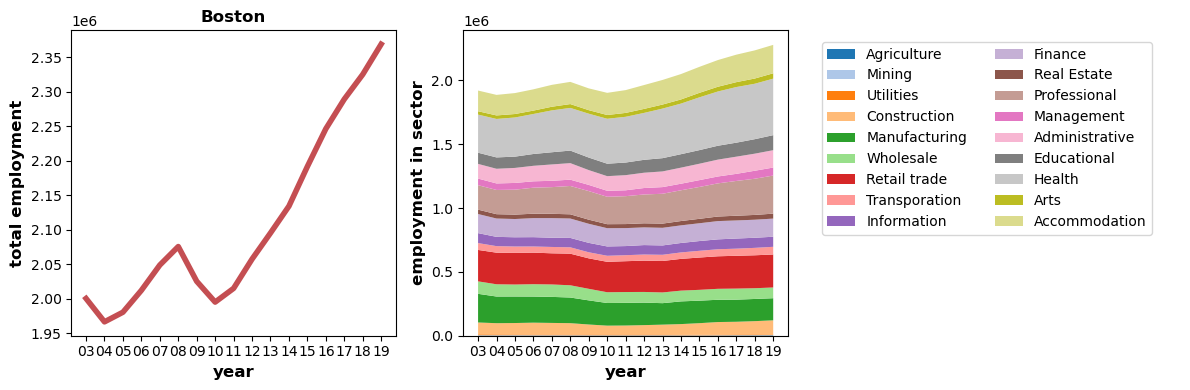

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


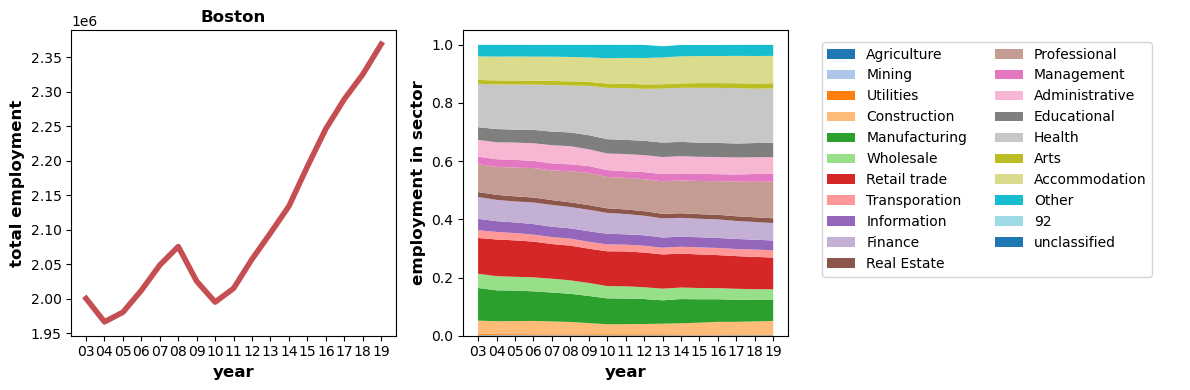

In [68]:
time_stamps_yearly=time_stamps_likeCBP_list[::12]
# stackPlot_1city_timeseries(df_metro_time,'Boston',
#                            naics_keys_to_plot, time_stamps_likeCBP_list)

stackPlot_1city_timeseries(df_metro_time,'Boston',
                           naics_keys_to_plot, time_stamps_yearly)

stackPlot_1city_timeseries(df_metroF_time,'Boston',
                           naics_colnames, time_stamps_yearly)

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


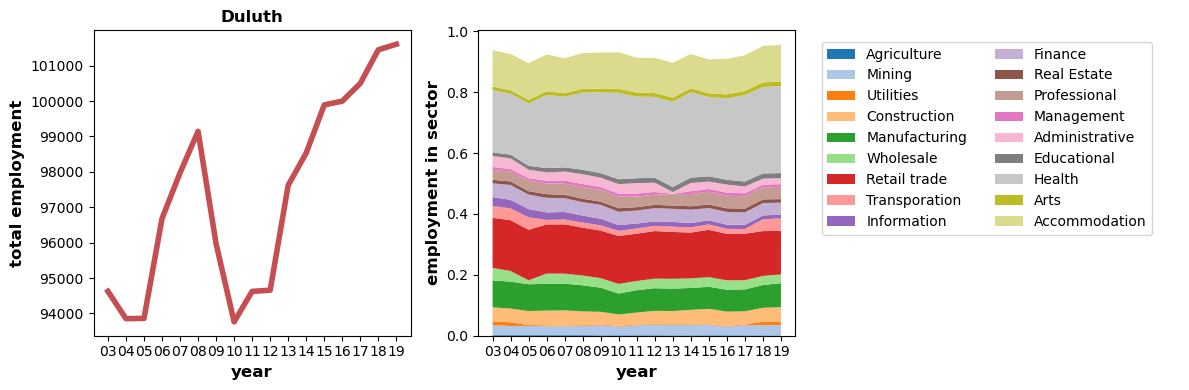

In [69]:
stackPlot_1city_timeseries(df_metroF_time,'Duluth',
                           naics_keys_to_plot, time_stamps_yearly)

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


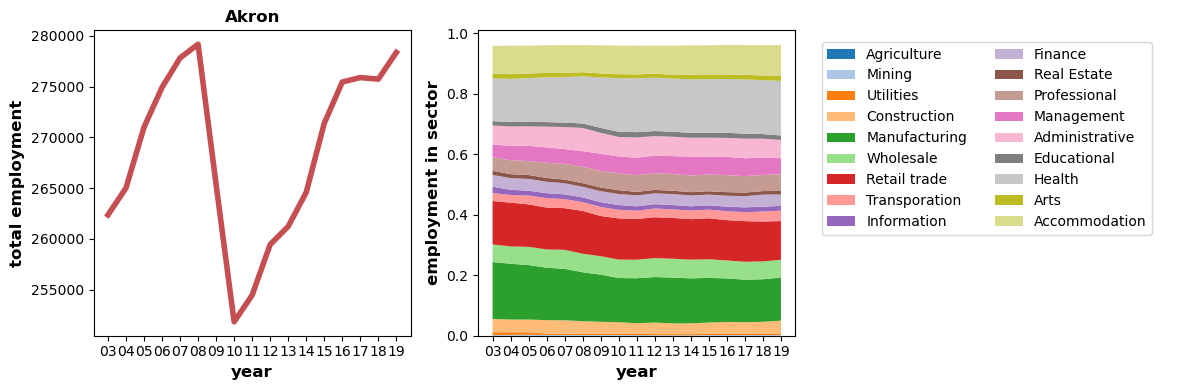

In [70]:
stackPlot_1city_timeseries(df_metroF_time,'Akron',
                           naics_keys_to_plot, time_stamps_yearly)

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


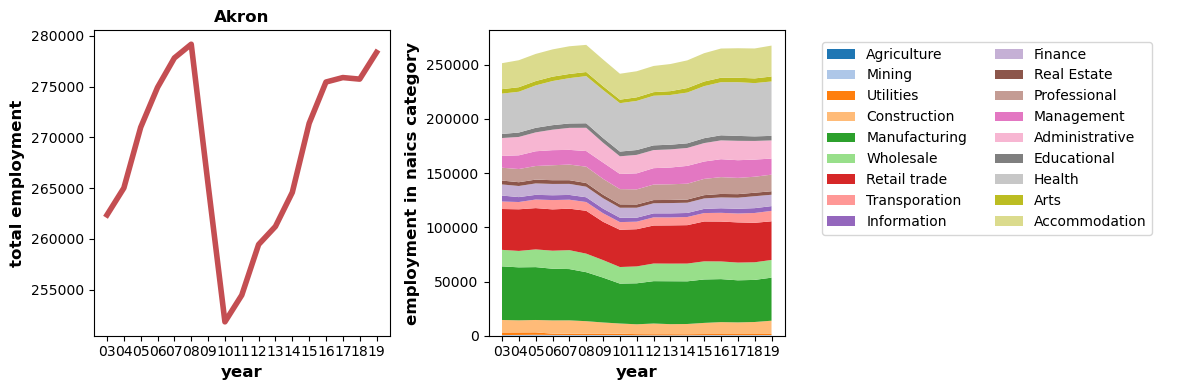

In [66]:
stackPlot_1city_timeseries(df_metro_time,'Akron',
                           naics_keys_to_plot, time_stamps_yearly)

In [63]:
df_metro_time['msa_name']

0                            Abilene, TX Metro Area
1                              Akron, OH Metro Area
2                             Albany, GA Metro Area
3                             Albany, OR Metro Area
4            Albany-Schenectady-Troy, NY Metro Area
                           ...                     
378                           Yakima, WA Metro Area
379                     York-Hanover, PA Metro Area
380    Youngstown-Warren-Boardman, OH-PA Metro Area
381                        Yuba City, CA Metro Area
382                             Yuma, AZ Metro Area
Name: msa_name, Length: 383, dtype: object

In [17]:
np.shape(df_temp['year'])

(17,)

In [12]:
naics_keys_to_plot

['naics_11',
 'naics_21',
 'naics_22',
 'naics_23',
 'naics_31-33',
 'naics_42',
 'naics_44-45',
 'naics_48-49',
 'naics_51',
 'naics_52',
 'naics_53',
 'naics_54',
 'naics_55',
 'naics_56',
 'naics_61',
 'naics_62',
 'naics_71',
 'naics_72']

### plot for microbial data

In [71]:


def stackPlot_microbe_timeseries(rel_abu_mat,time_points ):
    
    
    mean_abu_sp=np.mean(rel_abu_mat,axis=1)
    print (len(mean_abu_sp))
    
    biggest_species=np.argsort(mean_abu_sp)[-20:]
    
    fig = plt.figure(figsize=(4, 4))
    
    ax1 = fig.add_subplot()

    color_list=sns.color_palette(palette='tab20',n_colors=100)
    stckplot = ax1.stackplot(
        time_points[:7], rel_abu_mat[biggest_species,:7], labels='',
         colors=color_list,linewidth=1.0)
    # color_list = plt.cm.get_cmap('nipy_spectral')(np.asarray(np.linspace(0, 256, len(df_1city_stacked)), dtype=int))
    # color_list = plt.cm.get_cmap('tab20')(np.arange(0,len(df_1city_stacked), dtype=int))
#     ax2.plot(df_1city_stacked['year'],
#              df_1city_stacked['total'], 'k--', linewidth=2)
    ax1.set_xlabel('day')
    ax1.set_ylabel('relative abundance of species')

#     fig.legend(stckplot, label_naics, loc='upper right',
#                bbox_to_anchor=(.97, 0.9), ncol=2)
#     ax3 = fig.add_subplot(1, 3, 3)
#     ax3.axis('off')
    for ax in [ax1]:# [ax1, ax2, ax3]:  # make bigger font
        ax.yaxis.label.set_size(12)
        ax.yaxis.label.set_weight('bold')
        ax.xaxis.label.set_size(12)
        ax.xaxis.label.set_weight('bold')

    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.show()


85


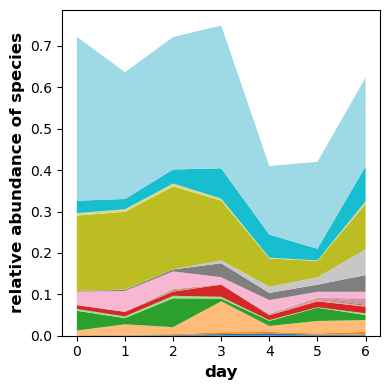

In [72]:
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
stackPlot_microbe_timeseries(rel_abu_mat,time_points )

In [48]:
time_points

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  56,  57,  58,  59,  60,  61,
        62,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  79,  80,
        81,  82,  83,  84,  86,  87,  88,  89,  90,  91,  92,  93,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 112, 113, 114,
       115, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158,
       159, 160, 161, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 179, 180, 181, 182, 183, 185, 186, 187, 189, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

In [45]:
time_points[15:30]

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
      dtype=uint16)

# fit logG and save parameters

### microbe

In [17]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
microbe_logG_params={'sp':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}

tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

# sp_list=[3,10,39]#,39]
sp_list=np.arange(len(rel_abu_mat))
for i,sp in enumerate(sp_list):
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., 1., floc=0,fscale=1.)
    
    ll=neutral_inst.logpdf(logG,  neut_tp, neut_bd, loc=0,scale=1.)
    microbe_logG_params['sp'].append(sp)
    microbe_logG_params['tp_fit'].append(neut_tp)
    microbe_logG_params['bd_fit'].append(neut_bd)
    microbe_logG_params['data_length'].append(len(logG))
    microbe_logG_params['logLk'].append(np.sum(ll) )
with open(combined_params_path+'microbe_logG_fitvals.pkl', 'wb') as handle:
    pickle.dump(microbe_logG_params, handle,protocol=4)  

### cities

In [19]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
city_logG_params={'naics':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}
naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')

for i,naics in enumerate(naics_keys_to_plot):
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            emp_logG,10., 1., floc=0,fscale=1.)
    ll=neutral_inst.logpdf(emp_logG,  neut_tp, neut_bd, loc=0,scale=1.)
    city_logG_params['naics'].append(naics)
    city_logG_params['tp_fit'].append(neut_tp)
    city_logG_params['bd_fit'].append(neut_bd)
    city_logG_params['data_length'].append(len(emp_logG))
    city_logG_params['logLk'].append(np.sum(ll)) 
with open(combined_params_path+'city_logG_fitvals.pkl', 'wb') as handle:
    pickle.dump(city_logG_params, handle,protocol=4)  

#####  city -absolute abundance

In [3]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
city_logG_params={'naics':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}
naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')

for i,naics in enumerate(naics_keys_to_plot):
    logratio_list=shared_func.get_LogRatio(df_metro_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            emp_logG,10., 1., floc=0,fscale=1.)
    ll=neutral_inst.logpdf(emp_logG,  neut_tp, neut_bd, loc=0,scale=1.)
    city_logG_params['naics'].append(naics)
    city_logG_params['tp_fit'].append(neut_tp)
    city_logG_params['bd_fit'].append(neut_bd)
    city_logG_params['data_length'].append(len(emp_logG))
    city_logG_params['logLk'].append(np.sum(ll)) 
with open(combined_params_path+'city_absabu_logG_fitvals.pkl', 'wb') as handle:
    pickle.dump(city_logG_params, handle,protocol=4)  

###  BCI (with and without clustering; relative and absolute)

In [17]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
BCI_logG_clustparams={'sp':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[],
                      'height_cluster':[]}
for clust_id in range(1,n_BCI_clusts+1):  
#     df_clusti=df_counts[df_counts['height_cluster']==clust_id]
#     BCI_popn=df_clusti[BCI_year_list].values
#     BCI_fold_change=BCI_popn[:,1:]/BCI_popn[:,:-1]
#     BCI_fold_change=np.ravel(BCI_fold_change[np.nonzero(BCI_popn[:,:-1])])
#     BCI_logG_clusti=np.log(BCI_fold_change[BCI_fold_change>0])

    BCI_logG_clusti=get_BCI_clust_logG(df_counts,clust_id)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
        BCI_logG_clusti,10., 1., floc=0,fscale=1.)
    ll=neutral_inst.logpdf(BCI_logG_clusti,  neut_tp, neut_bd, loc=0,scale=1.)
    BCI_logG_clustparams['height_cluster'].append(clust_id) 
    BCI_logG_clustparams['tp_fit'].append(neut_tp)
    BCI_logG_clustparams['bd_fit'].append(neut_bd)
    BCI_logG_clustparams['data_length'].append(len(BCI_logG_clusti))  
    BCI_logG_clustparams['logLk'].append(np.sum(ll)) 

with open(combined_params_path+'BCI_logG_clustfitvals.pkl', 'wb') as handle:
    pickle.dump(BCI_logG_clustparams, handle,protocol=4)  
    

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide


In [37]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
BCI_rel_logG_clustparams={'sp':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[],
                      'height_cluster':[]}
for clust_id in range(1,n_BCI_clusts+1):  
#     df_clusti=df_counts[df_counts['height_cluster']==clust_id]
#     BCI_popn=df_clusti[BCI_year_list].values
#     BCI_fold_change=BCI_popn[:,1:]/BCI_popn[:,:-1]
#     BCI_fold_change=np.ravel(BCI_fold_change[np.nonzero(BCI_popn[:,:-1])])
#     BCI_logG_clusti=np.log(BCI_fold_change[BCI_fold_change>0])

    BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
        BCI_logG_clusti,10., 1., floc=0,fscale=1.)
    ll=neutral_inst.logpdf(BCI_logG_clusti,  neut_tp, neut_bd, loc=0,scale=1.)
    BCI_rel_logG_clustparams['height_cluster'].append(clust_id) 
    BCI_rel_logG_clustparams['tp_fit'].append(neut_tp)
    BCI_rel_logG_clustparams['bd_fit'].append(neut_bd)
    BCI_rel_logG_clustparams['data_length'].append(len(BCI_logG_clusti))  
    BCI_rel_logG_clustparams['logLk'].append(np.sum(ll)) 

with open(combined_params_path+'BCI_rel_logG_clustfitvals.pkl', 'wb') as handle:
    pickle.dump(BCI_rel_logG_clustparams, handle,protocol=4)  
    

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide


In [5]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
BCI_logG_params={'sp':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}
neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
        BCI_logG,10., 1., floc=0,fscale=1.)
ll=neutral_inst.logpdf(BCI_logG,  neut_tp, neut_bd, loc=0,scale=1.)
# BCI_logG_params['sp'].append(sp)
BCI_logG_params['tp_fit'].append(neut_tp)
BCI_logG_params['bd_fit'].append(neut_bd)
BCI_logG_params['data_length'].append(len(BCI_logG))  
BCI_logG_params['logLk'].append(np.sum(ll)) 
with open(combined_params_path+'BCI_logG_fitvals.pkl', 'wb') as handle:
    pickle.dump(BCI_logG_params, handle,protocol=4)  

In [18]:
BCI_logG_clustparams

{'sp': [],
 'tp_fit': [0.012762953546702642,
  0.0060625697828357965,
  0.004708126081734841,
  0.006052209650657484],
 'bd_fit': [0.8006774838312702,
  1.2278571845693862,
  0.9945006307769695,
  1.132951916369248],
 'data_length': [251, 225, 179, 189],
 'logLk': [-89.33081305265569,
  103.09857973034929,
  67.39596554343784,
  72.24197785659562],
 'height_cluster': [1, 2, 3, 4]}

## plot BCI cluster logG fits


##### rel abu

Loglikelihood of SLRM model is higher than gaussian and laplace in all cases.


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide


cluster 1
ll BDI -69.7663249337607 , ll normal -118.18623436979367 , ll laplace -75.54555592830324
cluster 2
ll BDI 117.5099902991394 , ll normal 85.1823403538254 , ll laplace 115.87188168731191


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide


cluster 3
ll BDI 84.24891175402252 , ll normal -27.050176492361174 , ll laplace 62.19668380283629
cluster 4
ll BDI 90.4433318931759 , ll normal 31.142181637013323 , ll laplace 82.05675700148782


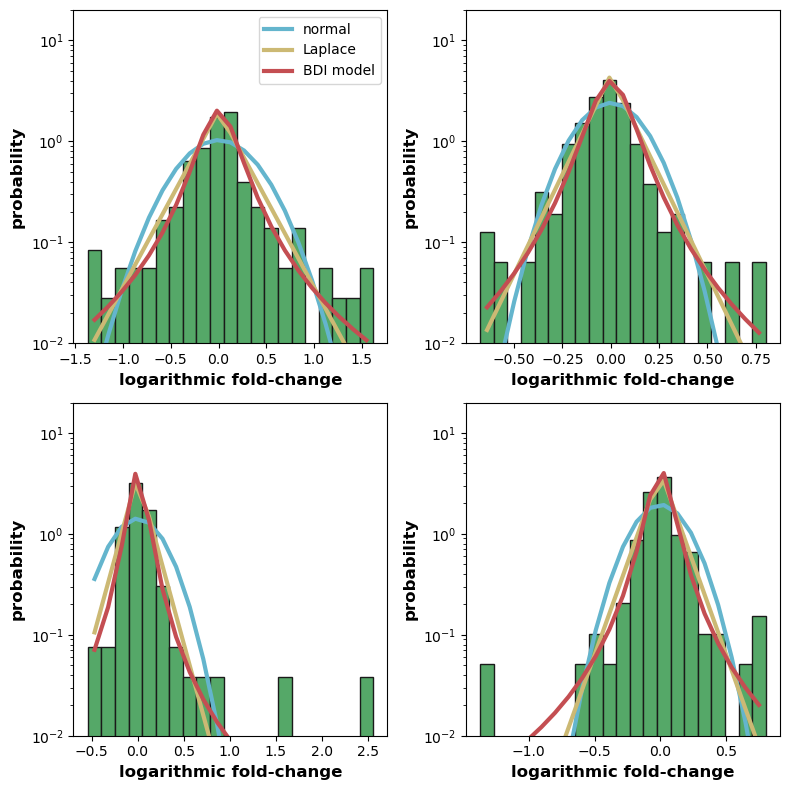

In [38]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'
n_bins=21

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


ax_list=[ax1,ax2,ax3,ax4]

for clust_id in range(1,n_BCI_clusts+1):  
    ax=ax_list[clust_id-1]
    BCI_rel_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)   
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            BCI_rel_logG_clusti,10., 1., floc=0,fscale=1.)
    
    ll_BDI=np.sum(neutral_inst.logpdf(BCI_rel_logG_clusti,  neut_tp, neut_bd, loc=0,scale=1.))
    mu, sigma=scipy.stats.norm.fit(BCI_rel_logG_clusti,floc=0)
    ll_normal=np.sum(scipy.stats.norm.logpdf(BCI_rel_logG_clusti,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(BCI_rel_logG_clusti,floc=0)
    ll_laplace=np.sum(scipy.stats.laplace.logpdf(BCI_rel_logG_clusti,loc=loc_laplace,scale=scale_laplace))
    histogram, bins = np.histogram(BCI_rel_logG_clusti, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(BCI_rel_logG_clusti, bins=n_bins, density=True,facecolor='g',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=mu,scale=sigma),
            'c-',lw=3,label='normal') 
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=loc_laplace,scale=scale_laplace),
            'y-',lw=3,label='Laplace') 
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=3,label='BDI model') 

    ax.set_ylim(1e-2,20) 
    
    print ('cluster', clust_id)
    print('ll BDI', ll_BDI,', ll normal', ll_normal,', ll laplace', ll_laplace)

for ax in ax_list:
    ax.set_xlabel(r'logarithmic fold-change')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')
#     ax.set_ylim(5e-3,3.5) /
ax1.legend(loc='best')

# ax1.set_title('microbiome')
# 
# ax3.set_title('urban employment')
# ax.set_title('tropical forest')
# plt.tick_params(axis='both', which='both') 
fig.patch.set_facecolor('white')  
fig.tight_layout()

# plt.savefig(dest_path+'BCI.png')
plt.show()

##### absolute abundance
BDI outperforms Laplace in 2 out of 4 clusters with laplace with mean is zero. 1 is very close

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide


cluster 1
ll BDI -89.33081305265569 , ll normal -128.7991917889645 , ll laplace -86.1238148490946
cluster 2
ll BDI 103.09857973034929 , ll normal 76.63279101304218 , ll laplace 106.91169294694441


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide


cluster 3
ll BDI 67.39596554343784 , ll normal -26.65955941215525 , ll laplace 53.042905601983435
cluster 4
ll BDI 72.24197785659562 , ll normal 27.724193863470802 , ll laplace 67.43132224955399


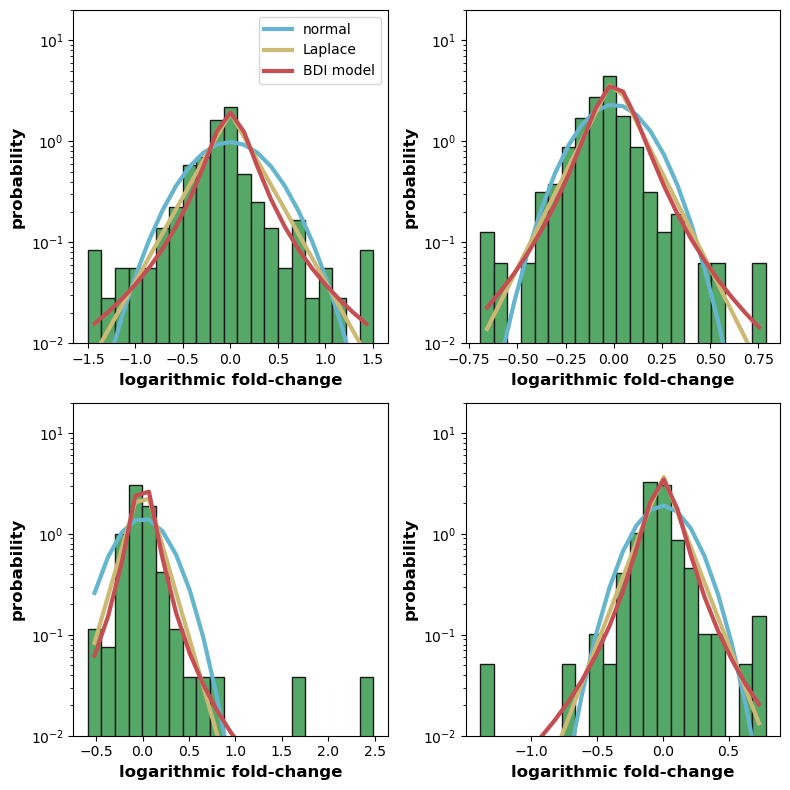

In [25]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'
n_bins=21

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


ax_list=[ax1,ax2,ax3,ax4]

for clust_id in range(1,n_BCI_clusts+1):  
    ax=ax_list[clust_id-1]
    BCI_logG_clusti=get_BCI_clust_logG(df_counts,clust_id)   
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            BCI_logG_clusti,10., 1., floc=0,fscale=1.)
    
    ll_BDI=np.sum(neutral_inst.logpdf(BCI_logG_clusti,  neut_tp, neut_bd, loc=0,scale=1.))
    mu, sigma=scipy.stats.norm.fit(BCI_logG_clusti,floc=0)
    ll_normal=np.sum(scipy.stats.norm.logpdf(BCI_logG_clusti,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(BCI_logG_clusti,floc=0)
    ll_laplace=np.sum(scipy.stats.laplace.logpdf(BCI_logG_clusti,loc=loc_laplace,scale=scale_laplace))
    histogram, bins = np.histogram(BCI_logG_clusti, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(BCI_logG_clusti, bins=n_bins, density=True,facecolor='g',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=mu,scale=sigma),
            'c-',lw=3,label='normal') 
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=loc_laplace,scale=scale_laplace),
            'y-',lw=3,label='Laplace') 
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=3,label='BDI model') 

    ax.set_ylim(1e-2,20) 
    
    print ('cluster', clust_id)
    print('ll BDI', ll_BDI,', ll normal', ll_normal,', ll laplace', ll_laplace)

for ax in ax_list:
    ax.set_xlabel(r'logarithmic fold-change')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')
#     ax.set_ylim(5e-3,3.5) /
ax1.legend(loc='best')

# ax1.set_title('microbiome')
# 
# ax3.set_title('urban employment')
# ax.set_title('tropical forest')
# plt.tick_params(axis='both', which='both') 
fig.patch.set_facecolor('white')  
fig.tight_layout()

# plt.savefig(dest_path+'BCI.png')
plt.show()

## read fit params and generate random samples
takes a long time so migrated to cluster

In [21]:
with open(combined_params_path+'city_logG_fitvals.pkl', 'rb') as handle:
    city_logG_fitvals = pickle.load(handle)

city_logG_fit_and_sim=deepcopy(city_logG_fitvals)
city_logG_fit_and_sim.update('logLk_sims':[])

In [22]:
logLik_sim_lists=[]
start_time = timeit.default_timer()
for nidx in range(len(city_logG_fitvals['naics'])):
    logLik_sim_list=[]
    for i in range (2):

        rnd_sample=neutral_inst.rvs(neut_tp, neut_bd, loc=loc_neut,scale= scale_neut,
                                    size=city_logG_fitvals['data_length'][nidx])
        
        
        ll=neutral_inst.logpdf(rnd_sample,  neut_tp, neut_bd, loc=0,scale=1.)
        logLik_sim_list.append(np.sum(ll))
        print(i, np.sum(ll))
    city_logG_fit_and_sim.append(logLik_sim_list)
    break
    
elapsed = timeit.default_timer() - start_time
print ('time in secs', elapsed)

0 55311.50159889344
1 55077.612018148844
time in secs 124.41013902199984


## Which species/sector had slowest, longest timescale..

### City data
sectors with largest relative abundance had the longest timescales, sectors with smallest relative abundance had fastest timescales.

In [29]:
with open(combined_params_path+'city_logG_fitvals.pkl', 'rb') as handle:
    city_logG_params=pickle.load(handle)  
df_city=pd.DataFrame.from_dict(city_logG_params) 
df_city['sector_name']='A'
df_city['tau']=1./df_city['tp_fit']
df_city['mean_relabu']=0.0
df_city['median_relabu']=0.0
for i, row in df_city.iterrows():
    naics=str(row['naics'])
    df_city.at[i,'sector_name'] = shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    
    emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
    emp=emp[indxs]
    df_city.at[i,'mean_relabu']=np.mean(emp)
    df_city.at[i,'median_relabu']=np.median(emp)
df_city  
    

,naics,tp_fit,bd_fit,data_length,logLk,sector_name,tau,mean_relabu,median_relabu
0,naics_11,0.004136,1.268242,27660,18779.108768,Agriculture,241.777494,0.028227,0.005602
1,naics_21,0.008262,1.050832,25398,3885.201137,Mining,121.033727,0.009725,0.001745
2,naics_22,0.001402,1.063650,29358,30673.994880,Utilities,713.070659,0.005097,0.004109
3,naics_23,0.003466,1.903258,63696,70936.951902,Construction,288.497583,0.059006,0.055506
4,naics_31-33,0.000829,1.427594,65130,103377.810332,Manufacturing,1205.824091,0.121796,0.107279
5,naics_42,0.000838,1.304503,47100,70653.897613,Wholesale,1192.978051,0.039311,0.039474
6,naics_44-45,0.000563,2.393584,70539,154739.221547,Retail trade,1774.747194,0.148517,0.146651
7,naics_48-49,0.001523,1.295840,38484,46026.052034,Transporation,656.649152,0.036754,0.031811
8,naics_51,0.002571,1.413187,54771,55533.321239,Information,388.924248,0.015902,0.013933
9,naics_52,0.000831,1.379942,62433,97131.244574,Finance,1203.009937,0.037548,0.032650


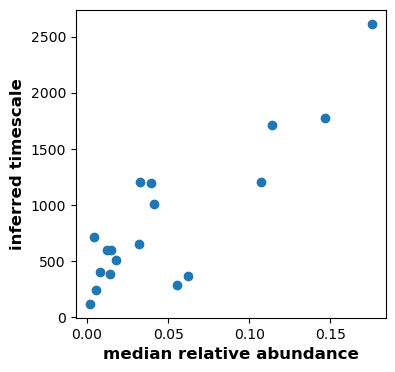

(0.8644002624936695, 3.7232223672338575e-06) SpearmanrResult(correlation=0.6635706914344685, pvalue=0.0026779839744573825)


In [36]:
fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot()

ax1.scatter(df_city['median_relabu'],df_city['tau'])
ax1.set_ylabel('inferred timescale')
ax1.set_xlabel('median relative abundance')
plt.show()

print(scipy.stats.pearsonr( df_city['median_relabu'],df_city['tau']),
      scipy.stats.spearmanr(df_city['median_relabu'],df_city['tau']))

### microbes

In [55]:
with open(combined_params_path+'microbe_logG_fitvals.pkl', 'rb') as handle:
    microbe_logG_params=pickle.load(handle)  
df_microbe=pd.DataFrame.from_dict(microbe_logG_params) 

time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
genus_names_full=caporaso['gtax']
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]

df_microbe['genus_name']=genus_names_list
df_microbe['tau']=1./df_microbe['tp_fit']
df_microbe['mean_relabu']=np.mean(rel_abu_mat, axis=1  )
df_microbe['median_relabu']=np.median(rel_abu_mat, axis=1  )

df_microbe  

,sp,tp_fit,bd_fit,data_length,logLk,genus_name,tau,mean_relabu,median_relabu
0,0,0.008802,0.481262,277,-224.078376,[Bacteroides],113.605564,0.222757,0.230441
1,1,0.017497,0.562214,275,-252.933504,[Bacteroides],57.151371,0.100026,0.104676
2,2,0.029288,0.611102,273,-287.873408,[Bacteroides],34.143825,0.061834,0.058529
3,3,0.083868,0.931739,273,-285.062562,[Faecalibacterium],11.923508,0.040853,0.036029
4,4,0.409789,1.336315,241,-329.548388,[Faecalibacterium],2.440278,0.016147,0.009706
...,...,...,...,...,...,...,...,...,...
80,80,0.033763,0.674554,275,-271.631599,[Bacteroides],29.618592,0.034463,0.032735
81,81,0.106165,1.030795,260,-275.865302,[Bacteroides],9.419283,0.001123,0.001029
82,82,0.824013,1.437466,245,-374.357682,[Roseburia],1.213573,0.002070,0.000912
83,83,0.034351,0.802002,273,-219.883142,[Bacteroides],29.111449,0.007174,0.006765


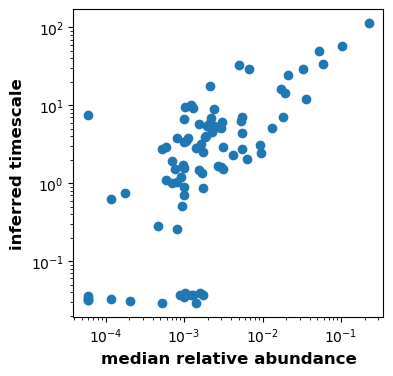

(0.9278179876440826, 2.6782498125009825e-37) SpearmanrResult(correlation=0.6847044527776177, pvalue=4.983132196467938e-13)
most abundant genera ['Bacteroides']


In [57]:
fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot()

ax1.scatter(df_microbe['median_relabu'],df_microbe['tau'])
ax1.set_ylabel('inferred timescale')
ax1.set_xlabel('median relative abundance')
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.show()

print(scipy.stats.pearsonr( df_microbe['median_relabu'],df_microbe['tau']),
      scipy.stats.spearmanr(df_microbe['median_relabu'],df_microbe['tau']))

print ('most abundant genera', df_microbe['genus_name'][np.argmax(df_microbe['median_relabu'].values)])

In [43]:
np.shape(rel_abu_mat)

(85, 336)

# AIC of logG distributions plots

## microbe data

In [4]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
with open(combined_params_path+'microbe_logG_fitvals.pkl', 'rb') as handle:
    microbe_logG_params=pickle.load(handle)  
    
microbe_logG_compare_dists=deepcopy(microbe_logG_params)
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu'] 
logG_arrs=get_logG_arrs_microbes(rel_abu_t_mat_full,tau=1)


ll_normal_list=[]
ll_Laplace_list=[]
ll_normal_list_non0mean=[]
ll_Laplace_list_non0mean=[]
for sp in microbe_logG_params['sp']:
    neut_tp=microbe_logG_params['tp_fit'][sp]
    neut_bd=microbe_logG_params['bd_fit'][sp]
    microbe_logG=logG_arrs[sp]
    ll_BDI=np.sum(neutral_inst.logpdf(microbe_logG,  neut_tp, neut_bd, loc=0,scale=1.))
    ## with and wihtout mean 0 constraint
    mu, sigma=scipy.stats.norm.fit(microbe_logG,floc=0)
    ll_normal=np.sum(scipy.stats.norm.logpdf(microbe_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(microbe_logG,floc=0)
    ll_laplace=np.sum(scipy.stats.laplace.logpdf(microbe_logG,loc=loc_laplace,scale=scale_laplace))

    mu, sigma=scipy.stats.norm.fit(microbe_logG)
    ll_normal_non0mean=np.sum(scipy.stats.norm.logpdf(microbe_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(microbe_logG)
    ll_laplace_non0mean=np.sum(scipy.stats.laplace.logpdf(microbe_logG,loc=loc_laplace,scale=scale_laplace))

    
    assert ll_BDI==microbe_logG_compare_dists['logLk'][sp],'should be?'+str(ll_BDI)+'   '+str(microbe_logG_compare_dists['logLk'][sp])

    
    ll_normal_list.append(ll_normal)
    ll_Laplace_list.append(ll_laplace)
    ll_normal_list_non0mean.append(ll_normal_non0mean)
    ll_Laplace_list_non0mean.append(ll_laplace_non0mean)

    
    
microbe_logG_compare_dists['ll_normal_list']=  ll_normal_list_non0mean
microbe_logG_compare_dists['ll_Laplace_list']=  ll_Laplace_list
microbe_logG_compare_dists['ll_normal_list_non0mean']=  ll_normal_list_non0mean
microbe_logG_compare_dists['ll_Laplace_list_non0mean']=  ll_Laplace_list_non0mean
  




ctr_list=[0,0,0,0,0]
ctr_names=['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace']
## if only mean 0 normal and laplace are compared
ctr_names2=['BDI','normal, mean0','Laplace, mean0']
ctr_list2=[0,0,0]
gap_AIC_min_and_BDI=[]
best_dist_list=[]
for sp in microbe_logG_compare_dists['sp']: 
    AIC_BDI=4-2*microbe_logG_compare_dists['logLk'][sp]
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[sp], 2-2*ll_Laplace_list[sp],
                  4-2*ll_normal_list_non0mean[sp], 4-2*ll_Laplace_list_non0mean[sp]           
                  ])
    idx=np.argmin(AICS)
    ctr_list[idx]=ctr_list[idx]+1
    best_dist_list.append(ctr_names[idx])
    gap_AIC_min_and_BDI.append( AIC_BDI-AICS[idx]  )
    
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[sp], 2-2*ll_Laplace_list[sp]         
                  ])
    idx=np.argmin(AICS)
    ctr_list2[idx]=ctr_list2[idx]+1    
      
gap_AIC_min_and_BDI=np.array(gap_AIC_min_and_BDI) 
print ('mean gap in AIC when BDI is not smallest: ', np.mean(gap_AIC_min_and_BDI[gap_AIC_min_and_BDI>0]))

microbe_logG_compare_dists['ctr_list']=ctr_list
microbe_logG_compare_dists['ctr_names']=ctr_names
microbe_logG_compare_dists['best_dist_list']=best_dist_list


microbe_logG_compare_dists['ctr_list_onlymean0']=ctr_list2
microbe_logG_compare_dists['ctr_names_onlymean0']=ctr_names2

print (ctr_list,ctr_list2)
with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'wb') as handle:
    pickle.dump(microbe_logG_compare_dists, handle,protocol=4)  
    

mean gap in AIC when BDI is not smallest:  3.247353291854674
[46, 18, 21, 0, 0] [46, 18, 21]


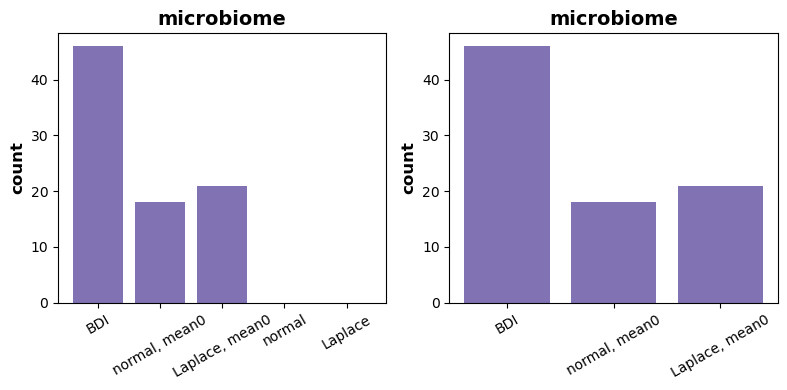

In [5]:

xvals=np.arange(5)
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.bar(xvals,ctr_list, color='m')
ax1.set_xticks(xvals)
ax1.set_xticklabels(['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace'],
                    rotation = 30)
ax1.set_ylabel('count')
ax1.set_title('microbiome')


xvals=np.arange(3)
ax2.bar(xvals,ctr_list2, color='m')
ax2.set_xticks(xvals)
ax2.set_xticklabels(ctr_names2,
                    rotation = 30)
ax2.set_ylabel('count')
ax2.set_title('microbiome')




compare_AIC_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/comparing AICS/'
plt.tight_layout()
plt.savefig(compare_AIC_path+'microbe_logG_AIC.png')

plt.show()

## BCI




##### relative abundance

In [39]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
with open(combined_params_path+'BCI_rel_logG_clustfitvals.pkl', 'rb') as handle:
    BCI_rel_logG_clustparams=pickle.load(handle)  
    
BCI_rel_logG_compare_dists=deepcopy(BCI_rel_logG_clustparams)

ll_normal_list=[]
ll_Laplace_list=[]

ll_normal_list_non0mean=[]
ll_Laplace_list_non0mean=[]
for i, clust_id in enumerate(BCI_rel_logG_clustparams['height_cluster']):
    BCI_rel_logG=get_BCI_clust_logG(df_BCI_rel_clust,clust_id )
    
    neut_tp=BCI_rel_logG_clustparams['tp_fit'][i]
    neut_bd=BCI_rel_logG_clustparams['bd_fit'][i]
    ll_BDI=np.sum(neutral_inst.logpdf(BCI_rel_logG,  neut_tp, neut_bd, loc=0,scale=1.))
    ## with and wihtout mean 0 constraint
    mu, sigma=scipy.stats.norm.fit(BCI_rel_logG,floc=0)
    ll_normal=np.sum(scipy.stats.norm.logpdf(BCI_rel_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(BCI_rel_logG,floc=0)
    ll_laplace=np.sum(scipy.stats.laplace.logpdf(BCI_rel_logG,loc=loc_laplace,scale=scale_laplace))

    mu, sigma=scipy.stats.norm.fit(BCI_rel_logG)
    ll_normal_non0mean=np.sum(scipy.stats.norm.logpdf(BCI_rel_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(BCI_rel_logG)
    ll_laplace_non0mean=np.sum(scipy.stats.laplace.logpdf(BCI_rel_logG,loc=loc_laplace,scale=scale_laplace))

    
    assert ll_BDI==BCI_rel_logG_compare_dists['logLk'][i],'should be?'+str(ll_BDI)+'   '+str(BCI_rel_logG_compare_dists['logLk'][clust_id])

    
    ll_normal_list.append(ll_normal)
    ll_Laplace_list.append(ll_laplace)
    ll_normal_list_non0mean.append(ll_normal_non0mean)
    ll_Laplace_list_non0mean.append(ll_laplace_non0mean)

    
    
BCI_rel_logG_compare_dists['ll_normal_list']=  ll_normal_list_non0mean
BCI_rel_logG_compare_dists['ll_Laplace_list']=  ll_Laplace_list
BCI_rel_logG_compare_dists['ll_normal_list_non0mean']=  ll_normal_list_non0mean
BCI_rel_logG_compare_dists['ll_Laplace_list_non0mean']=  ll_Laplace_list_non0mean    

    

ctr_list=[0,0,0,0,0]
ctr_names=['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace']
## if only mean 0 normal and laplace are compared
ctr_names2=['BDI','normal, mean0','Laplace, mean0']
ctr_list2=[0,0,0]
gap_AIC_min_and_BDI=[]

for i, clust_id in enumerate(BCI_rel_logG_clustparams['height_cluster']):
    AIC_BDI=4-2*BCI_rel_logG_compare_dists['logLk'][i]
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[i], 2-2*ll_Laplace_list[i],
                  4-2*ll_normal_list_non0mean[i], 4-2*ll_Laplace_list_non0mean[i]           
                  ])
    idx=np.argmin(AICS)
    ctr_list[idx]=ctr_list[idx]+1    
    gap_AIC_min_and_BDI.append( AIC_BDI-AICS[idx]  )
    
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[i], 2-2*ll_Laplace_list[i]         
                  ])
    idx=np.argmin(AICS)
    ctr_list2[idx]=ctr_list2[idx]+1    
    print(i, clust_id, 'best dist', ctr_names2[idx])
    
gap_AIC_min_and_BDI=np.array(gap_AIC_min_and_BDI) 
print ('mean gap in AIC when BDI is not smallest: ', np.mean(gap_AIC_min_and_BDI[gap_AIC_min_and_BDI>0]))


BCI_rel_logG_compare_dists['ctr_list']=ctr_list
BCI_rel_logG_compare_dists['ctr_names']=['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace']

BCI_rel_logG_compare_dists['ctr_list_onlymean0']=ctr_list2
BCI_rel_logG_compare_dists['ctr_names_onlymean0']=ctr_names2

print (ctr_list, ctr_list2)
with open(combined_params_path+'BCI_rel_logG_compare_dists.pkl', 'wb') as handle:
    pickle.dump(BCI_rel_logG_compare_dists, handle,protocol=4)  


0 1 best dist BDI
1 2 best dist BDI
2 3 best dist BDI
3 4 best dist BDI
mean gap in AIC when BDI is not smallest:  2.191231716161667
[3, 0, 0, 0, 1] [4, 0, 0]


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide


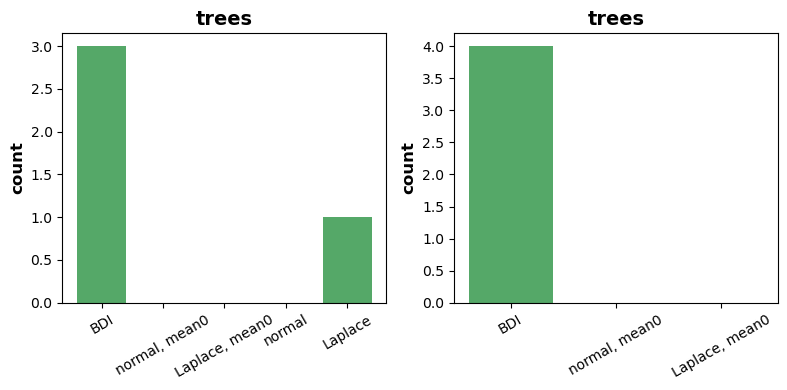

In [40]:
xvals=np.arange(5)
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.bar(xvals,ctr_list, color='g')
ax1.set_xticks(xvals)
ax1.set_xticklabels(['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace'],
                    rotation = 30)
ax1.set_ylabel('count')
ax1.set_title('trees')

xvals=np.arange(3)
ax2.bar(xvals,ctr_list2, color='g')
ax2.set_xticks(xvals)
ax2.set_xticklabels(ctr_names2,
                    rotation = 30)
ax2.set_ylabel('count')
ax2.set_title('trees')



compare_AIC_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/comparing AICS/'
plt.tight_layout()
plt.savefig(compare_AIC_path+'BCI_rel_logG_AIC.png')
plt.show()

##### absolute abundance

In [8]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
with open(combined_params_path+'BCI_logG_clustfitvals.pkl', 'rb') as handle:
    BCI_logG_clustparams=pickle.load(handle)  
    
BCI_logG_compare_dists=deepcopy(BCI_logG_clustparams)

ll_normal_list=[]
ll_Laplace_list=[]

ll_normal_list_non0mean=[]
ll_Laplace_list_non0mean=[]
for i, clust_id in enumerate(BCI_logG_clustparams['height_cluster']):
    BCI_logG=get_BCI_clust_logG(df_counts,clust_id )
    
    neut_tp=BCI_logG_clustparams['tp_fit'][i]
    neut_bd=BCI_logG_clustparams['bd_fit'][i]
    ll_BDI=np.sum(neutral_inst.logpdf(BCI_logG,  neut_tp, neut_bd, loc=0,scale=1.))
    ## with and wihtout mean 0 constraint
    mu, sigma=scipy.stats.norm.fit(BCI_logG,floc=0)
    ll_normal=np.sum(scipy.stats.norm.logpdf(BCI_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(BCI_logG,floc=0)
    ll_laplace=np.sum(scipy.stats.laplace.logpdf(BCI_logG,loc=loc_laplace,scale=scale_laplace))

    mu, sigma=scipy.stats.norm.fit(BCI_logG)
    ll_normal_non0mean=np.sum(scipy.stats.norm.logpdf(BCI_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(BCI_logG)
    ll_laplace_non0mean=np.sum(scipy.stats.laplace.logpdf(BCI_logG,loc=loc_laplace,scale=scale_laplace))

    
    assert ll_BDI==BCI_logG_compare_dists['logLk'][i],'should be?'+str(ll_BDI)+'   '+str(BCI_logG_compare_dists['logLk'][clust_id])

    
    ll_normal_list.append(ll_normal)
    ll_Laplace_list.append(ll_laplace)
    ll_normal_list_non0mean.append(ll_normal_non0mean)
    ll_Laplace_list_non0mean.append(ll_laplace_non0mean)

    
    
BCI_logG_compare_dists['ll_normal_list']=  ll_normal_list_non0mean
BCI_logG_compare_dists['ll_Laplace_list']=  ll_Laplace_list
BCI_logG_compare_dists['ll_normal_list_non0mean']=  ll_normal_list_non0mean
BCI_logG_compare_dists['ll_Laplace_list_non0mean']=  ll_Laplace_list_non0mean    

    

ctr_list=[0,0,0,0,0]
ctr_names=['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace']
## if only mean 0 normal and laplace are compared
ctr_names2=['BDI','normal, mean0','Laplace, mean0']
ctr_list2=[0,0,0]
gap_AIC_min_and_BDI=[]

for i, clust_id in enumerate(BCI_logG_clustparams['height_cluster']):
    AIC_BDI=4-2*BCI_logG_compare_dists['logLk'][i]
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[i], 2-2*ll_Laplace_list[i],
                  4-2*ll_normal_list_non0mean[i], 4-2*ll_Laplace_list_non0mean[i]           
                  ])
    idx=np.argmin(AICS)
    ctr_list[idx]=ctr_list[idx]+1    
    gap_AIC_min_and_BDI.append( AIC_BDI-AICS[idx]  )
    
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[i], 2-2*ll_Laplace_list[i]         
                  ])
    idx=np.argmin(AICS)
    ctr_list2[idx]=ctr_list2[idx]+1    
    print(i, clust_id, 'best dist', ctr_names2[idx])
    
gap_AIC_min_and_BDI=np.array(gap_AIC_min_and_BDI) 
print ('mean gap in AIC when BDI is not smallest: ', np.mean(gap_AIC_min_and_BDI[gap_AIC_min_and_BDI>0]))


BCI_logG_compare_dists['ctr_list']=ctr_list
BCI_logG_compare_dists['ctr_names']=['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace']

BCI_logG_compare_dists['ctr_list_onlymean0']=ctr_list2
BCI_logG_compare_dists['ctr_names_onlymean0']=ctr_names2

print (ctr_list, ctr_list2)
with open(combined_params_path+'BCI_logG_compare_dists.pkl', 'wb') as handle:
    pickle.dump(BCI_logG_compare_dists, handle,protocol=4)  


0 1 best dist Laplace, mean0
1 2 best dist Laplace, mean0
2 3 best dist BDI
3 4 best dist BDI
mean gap in AIC when BDI is not smallest:  23.038865219300295
[1, 0, 0, 0, 3] [2, 0, 2]


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide


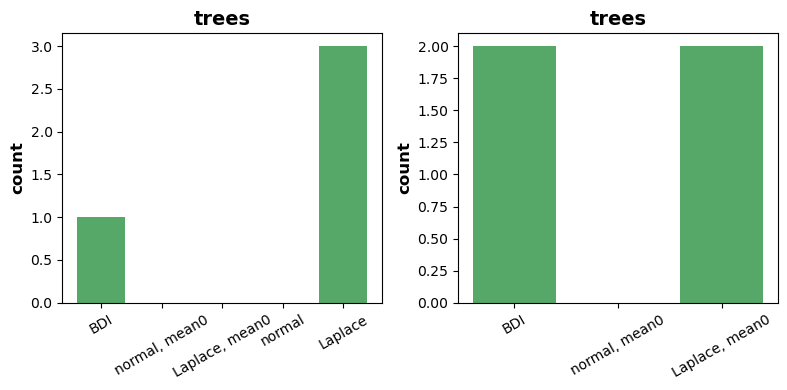

In [10]:
xvals=np.arange(5)
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.bar(xvals,ctr_list, color='g')
ax1.set_xticks(xvals)
ax1.set_xticklabels(['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace'],
                    rotation = 30)
ax1.set_ylabel('count')
ax1.set_title('trees')

xvals=np.arange(3)
ax2.bar(xvals,ctr_list2, color='g')
ax2.set_xticks(xvals)
ax2.set_xticklabels(ctr_names2,
                    rotation = 30)
ax2.set_ylabel('count')
ax2.set_title('trees')



compare_AIC_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/comparing AICS/'
plt.tight_layout()
plt.savefig(compare_AIC_path+'BCI_logG_AIC.png')
plt.show()

In [73]:
ctr_list

[1, 0, 0, 0, 3]

In [74]:
ll_Laplace_list_non0mean

[-76.05721520247836, 116.50252362584017, 60.80652997358132, 80.12273393987786]

In [75]:
gap_AIC_min_and_BDI

array([26.5471957 , 26.80788779,  0.        , 15.76151217])

In [69]:
gap_AIC_min_and_BDI

[-89.33081305265569, 103.09857973034929, 67.39596554343784, 72.24197785659562]

## city data

In [83]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
with open(combined_params_path+'city_logG_fitvals.pkl', 'rb') as handle:
    city_logG_params=pickle.load(handle)  
    
city_logG_compare_dists=deepcopy(city_logG_params)



ll_normal_list=[]
ll_Laplace_list=[]

ll_normal_list_non0mean=[]
ll_Laplace_list_non0mean=[]
naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')

for i,naics in enumerate(naics_keys_to_plot):
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    neut_tp=city_logG_params['tp_fit'][i]
    neut_bd=city_logG_params['bd_fit'][i]

    ll_BDI=np.sum(neutral_inst.logpdf(emp_logG,  neut_tp, neut_bd, loc=0,scale=1.))
    ## with and wihtout mean 0 constraint
    mu, sigma=scipy.stats.norm.fit(emp_logG,floc=0)
    ll_normal=np.sum(scipy.stats.norm.logpdf(emp_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(emp_logG,floc=0)
    ll_laplace=np.sum(scipy.stats.laplace.logpdf(emp_logG,loc=loc_laplace,scale=scale_laplace))

    mu, sigma=scipy.stats.norm.fit(emp_logG)
    ll_normal_non0mean=np.sum(scipy.stats.norm.logpdf(emp_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(emp_logG)
    ll_laplace_non0mean=np.sum(scipy.stats.laplace.logpdf(emp_logG,loc=loc_laplace,scale=scale_laplace))

    
    assert ll_BDI==city_logG_compare_dists['logLk'][i],'should be?'+str(ll_BDI)+'   '+str(city_logG_compare_dists['logLk'][i])

    
    ll_normal_list.append(ll_normal)
    ll_Laplace_list.append(ll_laplace)
    ll_normal_list_non0mean.append(ll_normal_non0mean)
    ll_Laplace_list_non0mean.append(ll_laplace_non0mean)

    
    
city_logG_compare_dists['ll_normal_list']=  ll_normal_list_non0mean
city_logG_compare_dists['ll_Laplace_list']=  ll_Laplace_list
city_logG_compare_dists['ll_normal_list_non0mean']=  ll_normal_list_non0mean
city_logG_compare_dists['ll_Laplace_list_non0mean']=  ll_Laplace_list_non0mean    


ctr_list=[0,0,0,0,0]
ctr_names=['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace']
## if only mean 0 normal and laplace are compared
ctr_names2=['BDI','normal, mean0','Laplace, mean0']
ctr_list2=[0,0,0]
gap_AIC_min_and_BDI=[]
for i,naics in enumerate(naics_keys_to_plot):
    AIC_BDI=4-2*city_logG_compare_dists['logLk'][i]
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[i], 2-2*ll_Laplace_list[i],
                  4-2*ll_normal_list_non0mean[i], 4-2*ll_Laplace_list_non0mean[i]           
                  ])
    idx=np.argmin(AICS)
    ctr_list[idx]=ctr_list[idx]+1
    
    gap_AIC_min_and_BDI.append( AIC_BDI-AICS[idx]  )
    
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[i], 2-2*ll_Laplace_list[i]         
                  ])
    idx=np.argmin(AICS)
    ctr_list2[idx]=ctr_list2[idx]+1   
    
      
gap_AIC_min_and_BDI=np.array(gap_AIC_min_and_BDI) 
print ('mean gap in AIC when BDI is not smallest: ', np.mean(gap_AIC_min_and_BDI[gap_AIC_min_and_BDI>0]))


print (ctr_list, ctr_list2)
city_logG_compare_dists['ctr_list']=ctr_list
city_logG_compare_dists['ctr_names']=ctr_names
city_logG_compare_dists['ctr_list_onlymean0']=ctr_list2
city_logG_compare_dists['ctr_names_onlymean0']=ctr_names2


with open(combined_params_path+'city_logG_compare_dists.pkl', 'wb') as handle:
    pickle.dump(city_logG_compare_dists, handle,protocol=4)  

mean gap in AIC when BDI is not smallest:  3783.4240798886603
[13, 0, 0, 0, 5] [18, 0, 0]


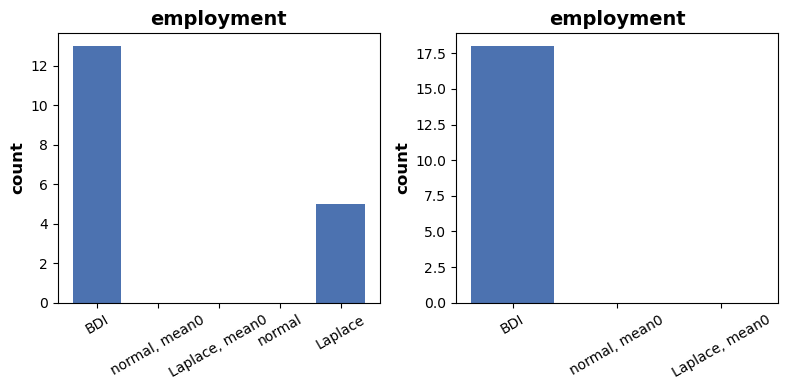

In [84]:

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
xvals=np.arange(5)
ax1.bar(xvals,ctr_list, color='b')
ax1.set_xticks(xvals)
ax1.set_xticklabels(ctr_names,
                    rotation = 30)
ax1.set_ylabel('count')
ax1.set_title('employment')
xvals=np.arange(3)
ax2.bar(xvals,ctr_list2, color='b')
ax2.set_xticks(xvals)
ax2.set_xticklabels(ctr_names2,
                    rotation = 30)
ax2.set_ylabel('count')
ax2.set_title('employment')

compare_AIC_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/comparing AICS/'
plt.tight_layout()
plt.savefig(compare_AIC_path+'city_logG_AIC.png')
plt.show()

##### city-absabu

In [4]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
with open(combined_params_path+'city_absabu_logG_fitvals.pkl', 'rb') as handle:
    city_logG_params=pickle.load(handle)  
    
city_logG_compare_dists=deepcopy(city_logG_params)



ll_normal_list=[]
ll_Laplace_list=[]

ll_normal_list_non0mean=[]
ll_Laplace_list_non0mean=[]
naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')

for i,naics in enumerate(naics_keys_to_plot):
    logratio_list=shared_func.get_LogRatio(df_metro_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    neut_tp=city_logG_params['tp_fit'][i]
    neut_bd=city_logG_params['bd_fit'][i]

    ll_BDI=np.sum(neutral_inst.logpdf(emp_logG,  neut_tp, neut_bd, loc=0,scale=1.))
    ## with and wihtout mean 0 constraint
    mu, sigma=scipy.stats.norm.fit(emp_logG,floc=0)
    ll_normal=np.sum(scipy.stats.norm.logpdf(emp_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(emp_logG,floc=0)
    ll_laplace=np.sum(scipy.stats.laplace.logpdf(emp_logG,loc=loc_laplace,scale=scale_laplace))

    mu, sigma=scipy.stats.norm.fit(emp_logG)
    ll_normal_non0mean=np.sum(scipy.stats.norm.logpdf(emp_logG,loc=mu,scale=sigma))
    loc_laplace, scale_laplace=scipy.stats.laplace.fit(emp_logG)
    ll_laplace_non0mean=np.sum(scipy.stats.laplace.logpdf(emp_logG,loc=loc_laplace,scale=scale_laplace))

    
    assert ll_BDI==city_logG_compare_dists['logLk'][i],'should be?'+str(ll_BDI)+'   '+str(city_logG_compare_dists['logLk'][i])

    
    ll_normal_list.append(ll_normal)
    ll_Laplace_list.append(ll_laplace)
    ll_normal_list_non0mean.append(ll_normal_non0mean)
    ll_Laplace_list_non0mean.append(ll_laplace_non0mean)

    
    
city_logG_compare_dists['ll_normal_list']=  ll_normal_list_non0mean
city_logG_compare_dists['ll_Laplace_list']=  ll_Laplace_list
city_logG_compare_dists['ll_normal_list_non0mean']=  ll_normal_list_non0mean
city_logG_compare_dists['ll_Laplace_list_non0mean']=  ll_Laplace_list_non0mean    


ctr_list=[0,0,0,0,0]
ctr_names=['BDI','normal, mean0','Laplace, mean0', 'normal', 'Laplace']
## if only mean 0 normal and laplace are compared
ctr_names2=['BDI','normal, mean0','Laplace, mean0']
ctr_list2=[0,0,0]
gap_AIC_min_and_BDI=[]
for i,naics in enumerate(naics_keys_to_plot):
    AIC_BDI=4-2*city_logG_compare_dists['logLk'][i]
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[i], 2-2*ll_Laplace_list[i],
                  4-2*ll_normal_list_non0mean[i], 4-2*ll_Laplace_list_non0mean[i]           
                  ])
    idx=np.argmin(AICS)
    ctr_list[idx]=ctr_list[idx]+1
    
    gap_AIC_min_and_BDI.append( AIC_BDI-AICS[idx]  )
    
    AICS=np.array([AIC_BDI,
                  2-2*ll_normal_list[i], 2-2*ll_Laplace_list[i]         
                  ])
    idx=np.argmin(AICS)
    ctr_list2[idx]=ctr_list2[idx]+1   
    
      
gap_AIC_min_and_BDI=np.array(gap_AIC_min_and_BDI) 
print ('mean gap in AIC when BDI is not smallest: ', np.mean(gap_AIC_min_and_BDI[gap_AIC_min_and_BDI>0]))


print (ctr_list, ctr_list2)
city_logG_compare_dists['ctr_list']=ctr_list
city_logG_compare_dists['ctr_names']=ctr_names
city_logG_compare_dists['ctr_list_onlymean0']=ctr_list2
city_logG_compare_dists['ctr_names_onlymean0']=ctr_names2


with open(combined_params_path+'city_absabu_logG_compare_dists.pkl', 'wb') as handle:
    pickle.dump(city_logG_compare_dists, handle,protocol=4)  

mean gap in AIC when BDI is not smallest:  4548.641221755477
[9, 0, 0, 0, 9] [18, 0, 0]


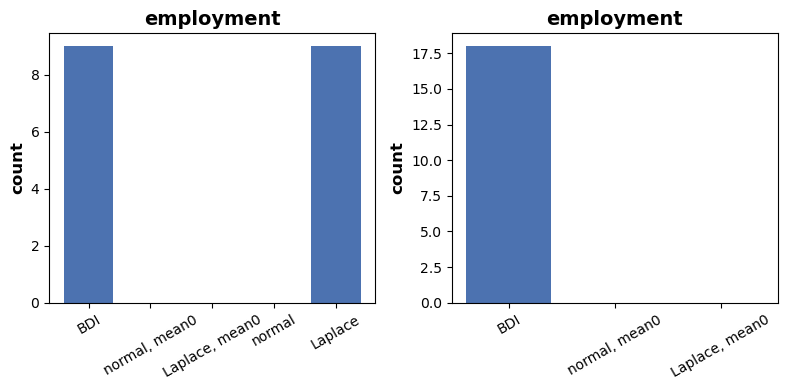

In [5]:

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
xvals=np.arange(5)
ax1.bar(xvals,ctr_list, color='b')
ax1.set_xticks(xvals)
ax1.set_xticklabels(ctr_names,
                    rotation = 30)
ax1.set_ylabel('count')
ax1.set_title('employment')
xvals=np.arange(3)
ax2.bar(xvals,ctr_list2, color='b')
ax2.set_xticks(xvals)
ax2.set_xticklabels(ctr_names2,
                    rotation = 30)
ax2.set_ylabel('count')
ax2.set_title('employment')

compare_AIC_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/comparing AICS/'
plt.tight_layout()
plt.savefig(compare_AIC_path+'city_absabu_logG_AIC.png')
plt.show()

## microbe params where BDI is worse

In [64]:
with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'rb') as handle:
    microbe_logG_compare_dists=pickle.load(handle)  
with open(combined_params_path+'microbe_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    microbe_AFD_atlogG_params=pickle.load(handle)     
with open(combined_params_path+'microbe_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    microbe_logG_atAFD_params=pickle.load( handle)     


with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_logGtrue_df=pd.DataFrame(pickle.load(handle)  )
microbe_tau_true_vals= 1./microbe_logGtrue_df['tp_fit'].values
microbe_logG_shape=np.array(microbe_AFD_atlogG_params['m/D'])
microbe_AFD_shape=np.array(microbe_logG_atAFD_params['bd_fit'])    
microbe_div_time=.175 ## 5.7 divisions per day    
microbe_rescaled_tau_divs=microbe_tau_true_vals/microbe_div_time ##5 divs per day    


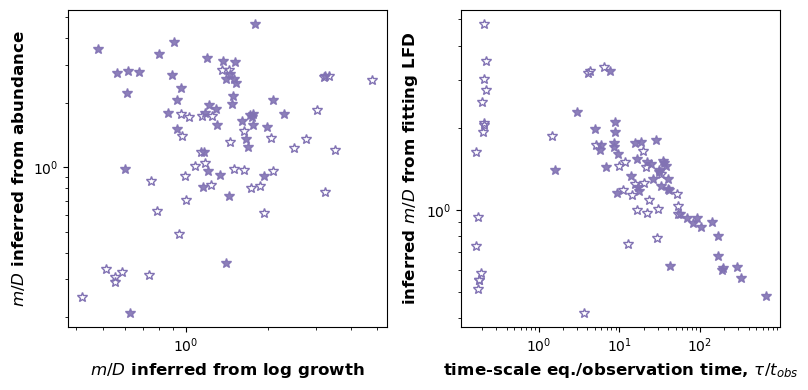

In [67]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

idx_valid=np.zeros(len(microbe_logG_shape)).astype(bool)
for idx,val in enumerate(microbe_logG_compare_dists['best_dist_list']):
    if val =='BDI':
        idx_valid[idx]=True          
idx_invalid=np.logical_not(idx_valid)
microbe_AIC_idx_valid=deepcopy(idx_valid)

if np.any(idx_valid==True):
    ax1.plot(microbe_logG_shape[idx_valid],microbe_AFD_shape[idx_valid],'*', color='m', markersize=7,alpha=0.9,label='microbiome')
    ax2.plot(microbe_rescaled_tau_divs[idx_valid],microbe_logG_shape[idx_valid],'*', color='m', markersize=7,alpha=0.9,label='microbiome')

if np.any(idx_valid==False):
    ax1.plot(microbe_logG_shape[idx_invalid],microbe_AFD_shape[idx_invalid],'*', mec='m', mfc='None', markersize=7)
    ax2.plot(microbe_rescaled_tau_divs[idx_invalid],microbe_logG_shape[idx_invalid],'*', mec='m', mfc='None', markersize=7)
for ax in [ax1,ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylabel(r'$m/D$ inferred from abundance')
    ax.set_xlabel(r'$m/D$ inferred from log growth')
    
ax2.set_ylabel(r'inferred $m/D$ from fitting LFD')
ax2.set_xlabel(r'time-scale eq./observation time, $\tau /t_{obs}$')

fig.tight_layout()
# plt.savefig(dest_path+'com.png')
plt.show()

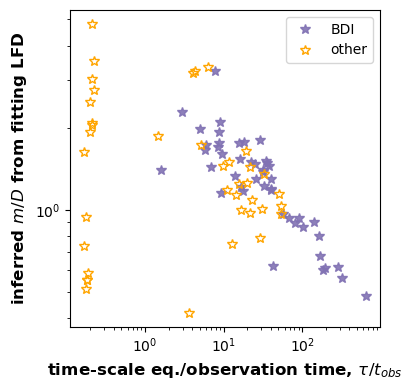

In [68]:
idx_valid=np.zeros(len(microbe_logG_shape)).astype(bool)
for idx,val in enumerate(microbe_logG_compare_dists['best_dist_list']):
    if val =='BDI':
        idx_valid[idx]=True          
idx_invalid=np.logical_not(idx_valid)
microbe_AIC_idx_valid=deepcopy(idx_valid)

fig = plt.figure(figsize=(4, 4))
ax2 = fig.add_subplot()
if np.any(idx_valid==True):
    ax2.plot(microbe_rescaled_tau_divs[idx_valid],microbe_logG_shape[idx_valid],'*', 
             color='m', markersize=7,alpha=0.9, label='BDI')

if np.any(idx_valid==False):
    ax2.plot(microbe_rescaled_tau_divs[idx_invalid],microbe_logG_shape[idx_invalid],'*',
             mec='orange', mfc='None', markersize=7,label='other')
for ax in [ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')

ax2.legend(loc='best')
ax2.set_ylabel(r'inferred $m/D$ from fitting LFD')
ax2.set_xlabel(r'time-scale eq./observation time, $\tau /t_{obs}$')

fig.tight_layout()
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/comparing AICS/'
plt.savefig(dest_path+'phase_plot_poor_AIC.png')
plt.show()

In [69]:
microbe_logG_compare_dists['best_dist_list']

['BDI',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'normal, mean0',
 'BDI',
 'Laplace, mean0',
 'BDI',
 'Laplace, mean0',
 'Laplace, mean0',
 'BDI',
 'Laplace, mean0',
 'BDI',
 'BDI',
 'Laplace, mean0',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'BDI',
 'normal, mean0',
 'Laplace, mean0',
 'Laplace, mean0',
 'normal, mean0',
 'normal, mean0',
 'Laplace, mean0',
 'BDI',
 'BDI',
 'normal, mean0',
 'BDI',
 'normal, mean0',
 'BDI',
 'BDI',
 'BDI',
 'normal, mean0',
 'Laplace, mean0',
 'normal, mean0',
 'BDI',
 'Laplace, mean0',
 'BDI',
 'normal, mean0',
 'normal, mean0',
 'Laplace, mean0',
 'Laplace, mean0',
 'BDI',
 'Laplace, mean0',
 'normal, mean0',
 'normal, mean0',
 'BDI',
 'BDI',
 'BDI',
 'Laplace, mean0',
 'BDI',
 'normal, mean0',
 'Laplace, mean0',
 'BDI',
 'Laplace, mean0',
 'Laplace, mean0',
 'Laplace, mean0',
 'normal, mean0',
 'normal, mean0',
 'BDI',
 'BDI',
 'BDI',
 'normal, mean0',
 'normal, mean0',
 'BDI',
 'Laplace, mean0',
 'BDI',
 'BDI

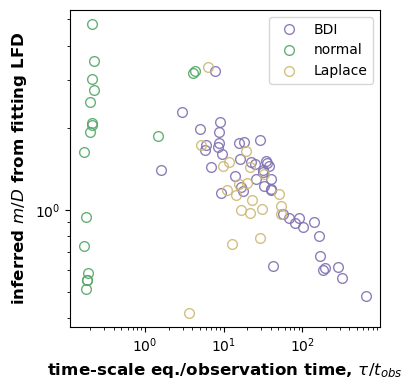

In [75]:
idx_BDI=np.zeros(len(microbe_logG_shape)).astype(bool)
idx_normal=np.zeros(len(microbe_logG_shape)).astype(bool)
idx_laplace=np.zeros(len(microbe_logG_shape)).astype(bool)
for idx,val in enumerate(microbe_logG_compare_dists['best_dist_list']):
    if val =='BDI':
        idx_BDI[idx]=True  
for idx,val in enumerate(microbe_logG_compare_dists['best_dist_list']):
    if val =='normal, mean0':
        idx_normal[idx]=True  
for idx,val in enumerate(microbe_logG_compare_dists['best_dist_list']):
    if val =='Laplace, mean0':
        idx_laplace[idx]=True  




fig = plt.figure(figsize=(4, 4))
ax2 = fig.add_subplot()
if np.any(idx_BDI==True):
    ax2.plot(microbe_rescaled_tau_divs[idx_BDI],microbe_logG_shape[idx_BDI],'o', 
             mec='m',mfc='None', markersize=7,alpha=0.9, label='BDI')
if np.any(idx_normal==True):
    ax2.plot(microbe_rescaled_tau_divs[idx_normal],microbe_logG_shape[idx_normal],'o', 
             mec='g',mfc='None', markersize=7,alpha=0.9, label='normal')
if np.any(idx_laplace==True):
    ax2.plot(microbe_rescaled_tau_divs[idx_laplace],microbe_logG_shape[idx_laplace],'o', 
             mec='y',mfc='None', markersize=7,alpha=0.9, label='Laplace')


for ax in [ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')

ax2.legend(loc='best')
ax2.set_ylabel(r'inferred $m/D$ from fitting LFD')
ax2.set_xlabel(r'time-scale eq./observation time, $\tau /t_{obs}$')

fig.tight_layout()
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/comparing AICS/'
plt.savefig(dest_path+'phase_plot_microbe_best_dist_AIC.png')
plt.show()

Number of points that pass both tests vs passing one of the tests.

In [52]:
print ('fail AIC',np.sum(~microbe_AIC_idx_valid), 'fail gof', np.sum(~microbe_gof_idx_valid))
print ('fail both',np.sum(~microbe_AIC_idx_valid*~microbe_gof_idx_valid))

fail AIC 39 fail gof 28
fail both 14


In [49]:
print ('pass AIC',np.sum(microbe_AIC_idx_valid), 'pass gof', np.sum(microbe_gof_idx_valid))
print ('pass both',np.sum(microbe_AIC_idx_valid*microbe_gof_idx_valid))

pass AIC 46 pass gof 57
pass both 32


# Fit abundance dist and find error bars
NOTE:
this is an old procedure, alternative method of finding consistent data points is used

-However, the final output files are used to get the fit parameters of fitting the SSD for the actual goodness of fit test implemented in the next section 






-notes about results in this section:
error bars are not symmetric smaller shape is more okay than larger shape.
-Lilliefors [1967] corrected KS test is also used. Here, we compute KS_pctile scores in addition to the likelihood based percentile scores

### microbe data
-lot of the microbial data also passes the KS data, but not used for error bar computation as the the test is too strict.

In [39]:
microbe_err_bars_dict={'sp':[],'a_gamma_true':[],'scale_gamma_true':[],
               'xfactors':[],
               'a_guess_arr':[],'scale_gamma_guess_fit':[],
               'pctile_scores':[]}
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]

xfactors=np.logspace(np.log10(.05),np.log10(5),41)
for sp in range(len(rel_abu_mat)):
    otu_abu=rel_abu_mat[sp]
    otu_abu=otu_abu[otu_abu>0]
    a_gamma_true,_, scale_gamma_true=scipy.stats.gamma.fit(
                            otu_abu, 10,floc=0.,scale=2 ) 
    a_guess_arr=xfactors*a_gamma_true
    
    microbe_err_bars_dict['sp'].append(sp)
    microbe_err_bars_dict['a_gamma_true'].append(a_gamma_true)
    microbe_err_bars_dict['xfactors'].append(xfactors)
    microbe_err_bars_dict['scale_gamma_true'].append(scale_gamma_true)

#     kstat_data,pval=scipy.stats.kstest(otu_abu,scipy.stats.gamma.cdf,
#                                    args=(a_gamma_true,0,scale_gamma_true))
#     print(sp, kstat_data,pval) 

    scale_gamma_guess_fit_list=[]
    pctile_score_list=[]
    for i, a_guess in enumerate(a_guess_arr):
        a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                                otu_abu, fa=a_guess,floc=0.,scale=2 )
        scale_gamma_guess_fit_list.append(scale_gamma_fit)
#         print (i, a_gamma_true, a_guess)
#         print (scale_gamma_true, scale_gamma_fit)
        temp=scipy.stats.gamma.logpdf(otu_abu, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_data= np.sum(temp) 

        logLik_sim_list=[]
        for j in range(1000):
            rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                             size=len(otu_abu))
            temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
            logLik_sim_list.append(np.sum(temp) )
        logLik_sim_arr=np.array(logLik_sim_list)
        if np.any(logLik_sim_arr>logLik_data):
            percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
        else:
            percentile_score=0.
        pctile_score_list.append(percentile_score)
        
    microbe_err_bars_dict['a_guess_arr'].append(a_guess_arr)
    microbe_err_bars_dict['scale_gamma_guess_fit'].append(np.array(scale_gamma_guess_fit_list))
    microbe_err_bars_dict['pctile_scores'].append(np.array(pctile_score_list))
    
with open(combined_params_path+'microbe_AFD_shape_error_estimates.pkl', 'wb') as handle:
    pickle.dump(microbe_err_bars_dict, handle,protocol=4)  

0 0.19075688789960477 3.507761151285234e-11
1 0.15878542458384054 7.614145556158269e-08
2 0.0890308471013384 0.009399873724476704
3 0.06768714929164835 0.08948621857865502
4 0.05729061968194046 0.25603452681131356
5 0.043448899399735286 0.5411918733603613
6 0.06668761879932167 0.09883653475396748
7 0.05005516828510814 0.3733506199773444
8 0.10445542212756392 0.0012859827613126984
9 0.14144330020087392 3.85240755969425e-05
10 0.23718995719464586 5.137038290343054e-17
11 0.18247814323301043 1.0879707828321389e-08
12 0.11108909120058985 0.0005168252296422031
13 0.23118762158150596 5.813907794679994e-11
14 0.03702859281932036 0.7778651124579259
15 0.05672781261369575 0.28393839382867925
16 0.07253440603941391 0.058427187302906636
17 0.06394567249895095 0.2300972048612463
18 0.050501395034887014 0.4027453304461375
19 0.061373685946270906 0.1596534432741471
20 0.043624961275828114 0.5436796493187519
21 0.053229347449224584 0.30670128627784987
22 0.06315304464781357 0.13777189101121845
23 0.0

### city data
- many of the city data points actually pass the naive ks test! :O

In [37]:
city_err_bars_dict={'naics':[],'a_gamma_true':[],'scale_gamma_true':[],
               'xfactors':[],
               'a_guess_arr':[],'scale_gamma_guess_fit':[],
               'pctile_scores':[]}#, 'ks_pctile_scores':[]}
# xfactors=np.logspace(np.log10(.2),np.log10(2),21)
xfactors=np.logspace(np.log10(.01),np.log10(3),50)#np.logspace(np.log10(.025),np.log10(5),41)
time_stamp_abu='16-Q3-M1'
city_err_bars_dict.update({'time_stamp_abu':time_stamp_abu})
naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')
for i,naics in enumerate(naics_keys_to_plot):
    emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
    emp=emp[indxs]
    a_gamma_true,_, scale_gamma_true=scipy.stats.gamma.fit(
                            emp, 2,floc=0.,scale=2 )
    a_guess_arr=xfactors*a_gamma_true
    city_err_bars_dict['naics'].append(naics)
    city_err_bars_dict['a_gamma_true'].append(a_gamma_true)
    city_err_bars_dict['xfactors'].append(xfactors)
    city_err_bars_dict['scale_gamma_true'].append(scale_gamma_true)
    
#     kstat_data,pval=scipy.stats.kstest(emp,scipy.stats.gamma.cdf,
#                                    args=(a_gamma_true,0,scale_gamma_true))
#     print(i,naics, kstat_data,pval) 
    
    scale_gamma_guess_fit_list=[]
    pctile_score_list=[]
    for i, a_guess in enumerate(a_guess_arr):
        a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                                emp, fa=a_guess,floc=0.,scale=2 )
        scale_gamma_guess_fit_list.append(scale_gamma_fit)
        
        temp=scipy.stats.gamma.logpdf(emp, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_data= np.sum(temp) 
        logLik_sim_list=[]
        for j in range(1000):
            rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                             size=len(emp))
            temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
            logLik_sim_list.append(np.sum(temp) )
        logLik_sim_arr=np.array(logLik_sim_list)
        if np.any(logLik_sim_arr>logLik_data):
            percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
        else:
            percentile_score=0.
        pctile_score_list.append(percentile_score)
        
    city_err_bars_dict['a_guess_arr'].append(a_guess_arr)
    city_err_bars_dict['scale_gamma_guess_fit'].append(np.array(scale_gamma_guess_fit_list))
    city_err_bars_dict['pctile_scores'].append(np.array(pctile_score_list))

    
with open(combined_params_path+'city_AFD_shape_error_estimates.pkl', 'wb') as handle:
    pickle.dump(city_err_bars_dict, handle,protocol=4)  


### BCI data


##### without clusters

-tried applying ks_test to the data. However, not even the true parameters are accepted by this test..


In [31]:
BCI_err_bars_dict={'sp':[],'a_gamma_true':[],'scale_gamma_true':[],
               'xfactors':[],
               'a_guess_arr':[],'scale_gamma_guess_fit':[],
               'pctile_scores':[], 'ks_pctile_scores':[]}
xfactors=np.logspace(np.log10(.2),np.log10(5),41)

BCI_popn_1995=BCI_popn[:,1]
BCI_popn_1995=BCI_popn_1995[BCI_popn_1995>0]   
BCI_err_bars_dict.update({'year':'1995'})
for sp in range(1):

    a_gamma_true,_, scale_gamma_true=scipy.stats.gamma.fit(
                            BCI_popn_1995, 10,floc=0.,scale=2 ) 
    a_guess_arr=xfactors*a_gamma_true
    
    BCI_err_bars_dict['sp'].append(sp)
    BCI_err_bars_dict['a_gamma_true'].append(a_gamma_true)
    BCI_err_bars_dict['xfactors'].append(xfactors)
    BCI_err_bars_dict['scale_gamma_true'].append(scale_gamma_true)

    kstat_data,pval=scipy.stats.kstest(BCI_popn_1995,scipy.stats.gamma.cdf,
                                   args=(a_gamma_true,0,scale_gamma_true), mode='approx')
#     print(kstat_data,pval) 
    scale_gamma_guess_fit_list=[]
    ll_pctile_score_list=[]
    ks_pctile_score_list=[]
    for i, a_guess in enumerate(a_guess_arr):
        a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                                BCI_popn_1995, fa=a_guess,floc=0.,scale=2 )
        scale_gamma_guess_fit_list.append(scale_gamma_fit)
#         print (i, a_gamma_true, a_guess)
#         print (scale_gamma_true, scale_gamma_fit)
        temp=scipy.stats.gamma.logpdf(BCI_popn_1995, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_data= np.sum(temp) 
        kstat_data,pval=scipy.stats.kstest(BCI_popn_1995,scipy.stats.gamma.cdf,
                                   args=(a_guess,0,scale_gamma_fit), mode='approx')
#         print(kstat_data,pval) 
        logLik_sim_list=[]
        ks_sim_list=[]
        for j in range(1000):
            rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                             size=len(BCI_popn_1995))
            temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
            logLik_sim_list.append(np.sum(temp) )
            kstat,_=scipy.stats.kstest(rnd_sample,scipy.stats.gamma.cdf,
                                   args=(a_guess,0,scale_gamma_fit), mode='approx')
            ks_sim_list.append(kstat)
        logLik_sim_arr=np.array(logLik_sim_list)
        ks_sim_arr=np.array(ks_sim_list)
        ### higher loglikelihood of sim means data is worse
        ### lower ksdistance of sim means data is worse
        if np.any(logLik_sim_arr>logLik_data):
            ll_percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
        else:
            ll_percentile_score=0.
        if np.any(ks_sim_arr<kstat_data):
            ks_percentile_score=np.sum(ks_sim_arr<kstat_data)*100./len(logLik_sim_arr)
        else:
            ks_percentile_score=0.
            
        ll_pctile_score_list.append(ll_percentile_score)
        ks_pctile_score_list.append(ks_percentile_score)
    BCI_err_bars_dict['a_guess_arr'].append(a_guess_arr)
    BCI_err_bars_dict['scale_gamma_guess_fit'].append(np.array(scale_gamma_guess_fit_list))
    BCI_err_bars_dict['pctile_scores'].append(np.array(ll_pctile_score_list))
    BCI_err_bars_dict['ks_pctile_scores'].append(np.array(ks_pctile_score_list))
with open(combined_params_path+'BCI_AFD_shape_error_estimates.pkl', 'wb') as handle:
    pickle.dump(BCI_err_bars_dict, handle,protocol=4)  

In [11]:
kstat_data,_=scipy.stats.kstest(BCI_popn_1995,scipy.stats.gamma.cdf, args=(float(a_guess),0,float(scale_gamma_fit)))

In [40]:
BCI_err_bars_dict

{'sp': [0],
 'a_gamma_true': [0.30010465489668214],
 'scale_gamma_true': [2510.571556398226],
 'xfactors': [array([0.2       , 0.21675968, 0.23492379, 0.25461002, 0.27594593,
         0.29906976, 0.32413132, 0.351293  , 0.38073079, 0.41263541,
         0.4472136 , 0.48468937, 0.52530556, 0.56932532, 0.61703386,
         0.6687403 , 0.72477966, 0.78551503, 0.85133992, 0.92268083,
         1.        , 1.08379839, 1.17461894, 1.27305012, 1.37972966,
         1.49534878, 1.6206566 , 1.756465  , 1.90365394, 2.06317707,
         2.23606798, 2.42344687, 2.6265278 , 2.8466266 , 3.08516931,
         3.34370152, 3.62389832, 3.92757515, 4.25669961, 4.61340417,
         5.        ])],
 'a_guess_arr': [array([0.06002093, 0.06505059, 0.07050172, 0.07640965, 0.08281266,
         0.08975223, 0.09727332, 0.10542466, 0.11425908, 0.12383381,
         0.13421088, 0.14545754, 0.15764664, 0.17085718, 0.18517473,
         0.20069208, 0.21750975, 0.23573672, 0.25549107, 0.27690081,
         0.30010465, 0.3252

In [25]:
kstat_data

0.4979510495459463

In [34]:
ks_sim_arr[:5]

array([0.07470173, 0.07984145, 0.07407924, 0.03525513, 0.07611069])

##### BCI clusts with relabus

In [43]:
BCI_relabu_err_bars_dict={'height_cluster':[],'a_gamma_true':[],'scale_gamma_true':[],
               'xfactors':[],
               'a_guess_arr':[],'scale_gamma_guess_fit':[],
               'pctile_scores':[], 'ks_pctile_scores':[]}
xfactors=np.logspace(np.log10(.2),np.log10(5),41)


BCI_relabu_err_bars_dict.update({'year':'1995'})
for clust_id in range(1,5):
    
    clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==clust_id]['Y1995']
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0] 
    
    
    a_gamma_true,_, scale_gamma_true=scipy.stats.gamma.fit(
                            clust_popn_1995, 10,floc=0.,scale=2 ) 
    a_guess_arr=xfactors*a_gamma_true
    
    BCI_relabu_err_bars_dict['height_cluster'].append(clust_id)
    BCI_relabu_err_bars_dict['a_gamma_true'].append(a_gamma_true)
    BCI_relabu_err_bars_dict['xfactors'].append(xfactors)
    BCI_relabu_err_bars_dict['scale_gamma_true'].append(scale_gamma_true)

    kstat_data,pval=scipy.stats.kstest(clust_popn_1995,scipy.stats.gamma.cdf,
                                   args=(a_gamma_true,0,scale_gamma_true), mode='approx')
#     print(kstat_data,pval) 
    scale_gamma_guess_fit_list=[]
    ll_pctile_score_list=[]
    ks_pctile_score_list=[]
    for i, a_guess in enumerate(a_guess_arr):
        a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                                clust_popn_1995, fa=a_guess,floc=0.,scale=2 )
        scale_gamma_guess_fit_list.append(scale_gamma_fit)
#         print (i, a_gamma_true, a_guess)
#         print (scale_gamma_true, scale_gamma_fit)
        temp=scipy.stats.gamma.logpdf(clust_popn_1995, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_data= np.sum(temp) 
        kstat_data,pval=scipy.stats.kstest(clust_popn_1995,scipy.stats.gamma.cdf,
                                   args=(a_guess,0,scale_gamma_fit), mode='approx')
#         print(kstat_data,pval) 
        logLik_sim_list=[]
        ks_sim_list=[]
        for j in range(1000):
            rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                             size=len(clust_popn_1995))
            temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
            logLik_sim_list.append(np.sum(temp) )
            kstat,_=scipy.stats.kstest(rnd_sample,scipy.stats.gamma.cdf,
                                   args=(a_guess,0,scale_gamma_fit), mode='approx')
            ks_sim_list.append(kstat)
        logLik_sim_arr=np.array(logLik_sim_list)
        ks_sim_arr=np.array(ks_sim_list)
        ### higher loglikelihood of sim means data is worse
        ### lower ksdistance of sim means data is worse
        if np.any(logLik_sim_arr>logLik_data):
            ll_percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
        else:
            ll_percentile_score=0.
        if np.any(ks_sim_arr<kstat_data):
            ks_percentile_score=np.sum(ks_sim_arr<kstat_data)*100./len(logLik_sim_arr)
        else:
            ks_percentile_score=0.
            
        ll_pctile_score_list.append(ll_percentile_score)
        ks_pctile_score_list.append(ks_percentile_score)
    BCI_relabu_err_bars_dict['a_guess_arr'].append(a_guess_arr)
    BCI_relabu_err_bars_dict['scale_gamma_guess_fit'].append(np.array(scale_gamma_guess_fit_list))
    BCI_relabu_err_bars_dict['pctile_scores'].append(np.array(ll_pctile_score_list))
    BCI_relabu_err_bars_dict['ks_pctile_scores'].append(np.array(ks_pctile_score_list))
with open(combined_params_path+'BCI_rel_clust_AFD_shape_error_estimates.pkl', 'wb') as handle:
    pickle.dump(BCI_relabu_err_bars_dict, handle,protocol=4)  

##### for BCI clusters with absolute counts

In [44]:
BCI_err_bars_dict={'height_cluster':[],'a_gamma_true':[],'scale_gamma_true':[],
               'xfactors':[],
               'a_guess_arr':[],'scale_gamma_guess_fit':[],
               'pctile_scores':[], 'ks_pctile_scores':[]}
xfactors=np.logspace(np.log10(.2),np.log10(5),41)


BCI_err_bars_dict.update({'year':'1995'})
for clust_id in range(1,5):
    
    clust_popn_1995=df_counts[df_counts['height_cluster']==clust_id]['Y1995']
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0] 
    
    
    a_gamma_true,_, scale_gamma_true=scipy.stats.gamma.fit(
                            clust_popn_1995, 10,floc=0.,scale=2 ) 
    a_guess_arr=xfactors*a_gamma_true
    
    BCI_err_bars_dict['height_cluster'].append(clust_id)
    BCI_err_bars_dict['a_gamma_true'].append(a_gamma_true)
    BCI_err_bars_dict['xfactors'].append(xfactors)
    BCI_err_bars_dict['scale_gamma_true'].append(scale_gamma_true)

    kstat_data,pval=scipy.stats.kstest(clust_popn_1995,scipy.stats.gamma.cdf,
                                   args=(a_gamma_true,0,scale_gamma_true), mode='approx')
#     print(kstat_data,pval) 
    scale_gamma_guess_fit_list=[]
    ll_pctile_score_list=[]
    ks_pctile_score_list=[]
    for i, a_guess in enumerate(a_guess_arr):
        a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                                clust_popn_1995, fa=a_guess,floc=0.,scale=2 )
        scale_gamma_guess_fit_list.append(scale_gamma_fit)
#         print (i, a_gamma_true, a_guess)
#         print (scale_gamma_true, scale_gamma_fit)
        temp=scipy.stats.gamma.logpdf(clust_popn_1995, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_data= np.sum(temp) 
        kstat_data,pval=scipy.stats.kstest(clust_popn_1995,scipy.stats.gamma.cdf,
                                   args=(a_guess,0,scale_gamma_fit), mode='approx')
#         print(kstat_data,pval) 
        logLik_sim_list=[]
        ks_sim_list=[]
        for j in range(1000):
            rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                             size=len(clust_popn_1995))
            temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
            logLik_sim_list.append(np.sum(temp) )
            kstat,_=scipy.stats.kstest(rnd_sample,scipy.stats.gamma.cdf,
                                   args=(a_guess,0,scale_gamma_fit), mode='approx')
            ks_sim_list.append(kstat)
        logLik_sim_arr=np.array(logLik_sim_list)
        ks_sim_arr=np.array(ks_sim_list)
        ### higher loglikelihood of sim means data is worse
        ### lower ksdistance of sim means data is worse
        if np.any(logLik_sim_arr>logLik_data):
            ll_percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
        else:
            ll_percentile_score=0.
        if np.any(ks_sim_arr<kstat_data):
            ks_percentile_score=np.sum(ks_sim_arr<kstat_data)*100./len(logLik_sim_arr)
        else:
            ks_percentile_score=0.
            
        ll_pctile_score_list.append(ll_percentile_score)
        ks_pctile_score_list.append(ks_percentile_score)
    BCI_err_bars_dict['a_guess_arr'].append(a_guess_arr)
    BCI_err_bars_dict['scale_gamma_guess_fit'].append(np.array(scale_gamma_guess_fit_list))
    BCI_err_bars_dict['pctile_scores'].append(np.array(ll_pctile_score_list))
    BCI_err_bars_dict['ks_pctile_scores'].append(np.array(ks_pctile_score_list))
with open(combined_params_path+'BCIclust_AFD_shape_error_estimates.pkl', 'wb') as handle:
    pickle.dump(BCI_err_bars_dict, handle,protocol=4)  

## use this to make m/D comparison plot

In [84]:
with open(combined_params_path+'microbe_AFD_shape_error_estimates.pkl', 'rb') as handle:
    microbe_err_bars_dict=pickle.load(handle)  
microbe_error_bars_df=pd.DataFrame(microbe_err_bars_dict)
microbe_error_bars_df.head()

with open(combined_params_path+'city_AFD_shape_error_estimates.pkl', 'rb') as handle:
    city_err_bars_dict=pickle.load(handle)  
city_error_bars_df=pd.DataFrame(city_err_bars_dict)
# city_error_bars_df.head()

with open(combined_params_path+'BCI_AFD_shape_error_estimates.pkl', 'rb') as handle:
    BCI_err_bars_dict=pickle.load(handle)  
BCI_error_bars_df=pd.DataFrame(BCI_err_bars_dict)
# BCI_error_bars_df.head()


calculate lower and upper bounds of m/D value as the m/D values that will be rejected at the 95% level when sampling from fitted distributions.

In [96]:
# threshold=97.7 ### 2 sigma accuracy
threshold=95 ### 5% pvalue

print ('microbe')
microbe_a_trues=[]
microbe_a_lbs=[]
microbe_a_ubs=[]
for sp in microbe_error_bars_df['sp'].values:
    a_true=float(microbe_error_bars_df[microbe_error_bars_df['sp']==sp]['a_gamma_true'].values[0])
    a_guesses=np.ravel(microbe_error_bars_df[microbe_error_bars_df['sp']==sp]['a_guess_arr'].values[0])
    pctile_scores=np.ravel(microbe_error_bars_df[microbe_error_bars_df['sp']==sp]['pctile_scores'].values[0])
    
    idx_true=np.argmin(np.abs(a_true-a_guesses))
    microbe_a_trues.append(a_true)
    if pctile_scores[0]<threshold:
        microbe_a_lbs.append(a_guesses[0])
        print('lower range was insufficient', sp)
    else:
        idx=np.where(pctile_scores<threshold)[0][0]
        microbe_a_lbs.append(a_guesses[idx])
    
    if pctile_scores[-1]<threshold:
        microbe_a_ubs.append(a_guesses[-1])
        print('upper range was insufficient', sp)
    else:
        idx=np.where(pctile_scores<threshold)[0][-1]
        microbe_a_ubs.append(a_guesses[idx])


## convert lower and upper bounds to error bars, which distance from true value rather than bound value
microbe_a_lbars=np.array(microbe_a_trues)-np.array(microbe_a_lbs)
microbe_a_ubars=np.array(microbe_a_ubs)-np.array(microbe_a_trues)


print ('BCI')

BCI_a_trues=[]
BCI_a_lbs=[]
BCI_a_ubs=[]
for sp in BCI_error_bars_df['sp'].values:
    a_true=float(BCI_error_bars_df[BCI_error_bars_df['sp']==sp]['a_gamma_true'].values[0])
    a_guesses=np.ravel(BCI_error_bars_df[BCI_error_bars_df['sp']==sp]['a_guess_arr'].values[0])
    pctile_scores=np.ravel(BCI_error_bars_df[BCI_error_bars_df['sp']==sp]['pctile_scores'].values[0])
    
    idx_true=np.argmin(np.abs(a_true-a_guesses))
    BCI_a_trues.append(a_true)
    if pctile_scores[0]<threshold:
        BCI_a_lbs.append(a_guesses[0])
        print('lower range was insufficient', sp)
    else:
        idx=np.where(pctile_scores<threshold)[0][0]
        BCI_a_lbs.append(a_guesses[idx])
    
    if pctile_scores[-1]<threshold:
        BCI_a_ubs.append(a_guesses[-1])
        print('upper range was insufficient', sp)
    else:
        idx=np.where(pctile_scores<threshold)[0][-1]
        BCI_a_ubs.append(a_guesses[idx])
    

## convert lower and upper bounds to error bars, which distance from true value rather than bound value
BCI_a_lbars=np.array(BCI_a_trues)-np.array(BCI_a_lbs)
BCI_a_ubars=np.array(BCI_a_ubs)-np.array(BCI_a_trues)

print ('city')

city_a_trues=[]
city_a_lbs=[]
city_a_ubs=[]
for naics in city_error_bars_df['naics'].values:
    a_true=float(city_error_bars_df[city_error_bars_df['naics']==naics]['a_gamma_true'].values[0])
    a_guesses=np.ravel(city_error_bars_df[city_error_bars_df['naics']==naics]['a_guess_arr'].values[0])
    pctile_scores=np.ravel(city_error_bars_df[city_error_bars_df['naics']==naics]['pctile_scores'].values[0])
    
    idx_true=np.argmin(np.abs(a_true-a_guesses))
    city_a_trues.append(a_true)
    if pctile_scores[0]<threshold:
        city_a_lbs.append(a_guesses[0])
        print('lower range was insufficient', naics)
    else:
        idx=np.where(pctile_scores<threshold)[0][0]
        city_a_lbs.append(a_guesses[idx])
    
    if pctile_scores[-1]<threshold:
        city_a_ubs.append(a_guesses[-1])
        print('upper range was insufficient', naics)
    else:
        idx=np.where(pctile_scores<threshold)[0][-1]
        city_a_ubs.append(a_guesses[idx])
    
## convert lower and upper bounds to error bars, which distance from true value rather than bound value
city_a_lbars=np.array(city_a_trues)-np.array(city_a_lbs)
city_a_ubars=np.array(city_a_ubs)-np.array(city_a_trues)

microbe
BCI
city
lower range was insufficient naics_44-45


In [135]:
city_error_bars_df[city_error_bars_df['naics']=='naics_44-45']['pctile_scores'].values

array([array([ 86.6,  37.5,   4.2,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
                0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
                0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
                8.9,  61.1,  98.2, 100. , 100. , 100. , 100. , 100. , 100. ,
              100. , 100. , 100. , 100. , 100. ])                           ],
      dtype=object)

In [130]:
city_error_bars_df[city_error_bars_df['naics']=='naics_21']['a_gamma_true'].values[0]*xfac

0.4443742098026734

In [131]:
city_error_bars_df[city_error_bars_df['naics']=='naics_21']['a_gamma_true'].values[0]*np.logspace(np.log10(.025),np.log10(5),41)

array([0.08887484, 0.09632241, 0.10439407, 0.11314213, 0.12262326,
       0.13289889, 0.1440356 , 0.15610555, 0.16918694, 0.18336454,
       0.19873019, 0.21538346, 0.23343224, 0.25299349, 0.27419394,
       0.29717094, 0.32207339, 0.34906262, 0.37831351, 0.41001557,
       0.44437421, 0.48161205, 0.52197036, 0.56571064, 0.61311628,
       0.66449443, 0.72017799, 0.78052775, 0.84593471, 0.91682268,
       0.99365094, 1.07691729, 1.16716122, 1.26496744, 1.37096968,
       1.48585472, 1.61036695, 1.7453131 , 1.89156753, 2.05007783,
       2.22187105])

In [137]:
np.logspace(np.log10(.015),np.log10(3),51)*city_error_bars_df[city_error_bars_df['naics']=='naics_21']['a_gamma_true'].values[0]


array([0.00666561, 0.00741073, 0.00823913, 0.00916014, 0.0101841 ,
       0.01132252, 0.0125882 , 0.01399537, 0.01555983, 0.01729918,
       0.01923296, 0.0213829 , 0.02377318, 0.02643065, 0.02938519,
       0.03267   , 0.036322  , 0.04038223, 0.04489634, 0.04991505,
       0.05549478, 0.06169823, 0.06859513, 0.076263  , 0.08478802,
       0.09426601, 0.10480348, 0.11651888, 0.12954388, 0.14402487,
       0.16012462, 0.17802406, 0.19792438, 0.22004925, 0.24464734,
       0.27199511, 0.30239994, 0.33620356, 0.37378589, 0.41556934,
       0.46202354, 0.51367059, 0.57109098, 0.63493008, 0.70590539,
       0.78481465, 0.87254473, 0.97008168, 1.07852173, 1.1990837 ,
       1.33312263])

In [151]:
city_error_bars_df[city_error_bars_df['naics']=='naics_11']['a_guess_arr'].values

array([array([0.01224911, 0.01398396, 0.01596452, 0.01822559, 0.0208069 ,
              0.0237538 , 0.02711808, 0.03095884, 0.03534357, 0.04034931,
              0.04606403, 0.05258812, 0.06003623, 0.06853922, 0.0782465 ,
              0.08932863, 0.10198033, 0.1164239 , 0.13291314, 0.15173776,
              0.17322853, 0.19776305, 0.22577243, 0.2577488 , 0.29425402,
              0.33592951, 0.38350754, 0.43782409, 0.49983356, 0.57062548,
              0.65144373, 0.74370835, 0.8490405 , 0.96929095, 1.10657259,
              1.26329756, 1.44221965, 1.64648264, 1.87967561, 2.14589593,
              2.4498213 ])                                               ],
      dtype=object)

In [146]:
 np.logspace(np.log10(.01),np.log10(3),50)*city_error_bars_df[
     city_error_bars_df['naics']=='naics_21']['a_gamma_true'].values[0]

array([0.00444374, 0.00499232, 0.00560862, 0.006301  , 0.00707885,
       0.00795273, 0.00893449, 0.01003745, 0.01127656, 0.01266865,
       0.01423259, 0.01598959, 0.01796349, 0.02018107, 0.02267241,
       0.02547131, 0.02861573, 0.03214832, 0.03611701, 0.04057563,
       0.04558466, 0.05121206, 0.05753415, 0.06463671, 0.07261607,
       0.08158047, 0.09165153, 0.10296585, 0.11567692, 0.12995716,
       0.14600028, 0.16402392, 0.18427257, 0.20702089, 0.23257749,
       0.26128903, 0.29354499, 0.32978292, 0.37049441, 0.4162317 ,
       0.46761523, 0.52534202, 0.59019515, 0.66305435, 0.74490798,
       0.83686638, 0.94017698, 1.05624122, 1.1866335 , 1.33312263])

In [158]:
 np.logspace(np.log10(.01),np.log10(3),50)*city_error_bars_df[
     city_error_bars_df['naics']=='naics_11']['a_gamma_true'].values[0]


array([0.00489964, 0.0055045 , 0.00618403, 0.00694744, 0.0078051 ,
       0.00876863, 0.00985111, 0.01106723, 0.01243347, 0.01396837,
       0.01569276, 0.01763002, 0.01980644, 0.02225153, 0.02499846,
       0.02808451, 0.03155152, 0.03544654, 0.03982239, 0.04473844,
       0.05026137, 0.0564661 , 0.0634368 , 0.07126804, 0.08006603,
       0.08995013, 0.10105441, 0.11352951, 0.12754465, 0.14328996,
       0.16097901, 0.18085176, 0.20317779, 0.22825996, 0.2564385 ,
       0.28809567, 0.32366089, 0.36361661, 0.40850485, 0.4589345 ,
       0.51558966, 0.57923887, 0.65074553, 0.73107964, 0.82133094,
       0.9227237 , 1.03663334, 1.16460505, 1.30837477, 1.46989278])

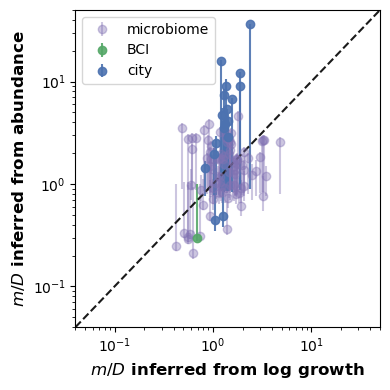

In [98]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'


shape_logG_list=[]
shape_AFD_list=[]

Delta_t=1
with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
    microbe_fit_vals_logG = pickle.load(handle)
microbe_logG_shape= microbe_fit_vals_logG['m/D_logG']
# with open(microbiome_fit_fold+'fit_logG_with_AFD_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
#     microbe_fit_vals_AFD = pickle.load(handle)
# microbe_AFD_shape=microbe_fit_vals_AFD['m/D_AFD']


with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
    BCI_fit_vals_logG = pickle.load(handle)
BCI_logG_shape=BCI_fit_vals_logG ['m/D_logG']
# with open(BCI_fit_params_path+'fit_logG_with_AFD-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_AFD = pickle.load(handle)
# BCI_AFD_shape=BCI_fit_vals_AFD['m/D_AFD']

Delta_t=12
with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
    city_fit_vals_logG = pickle.load(handle)
city_logG_shape= np.array(city_fit_vals_logG['NeutralTheory'])[:,1]
# with open(city_fit_params_path+'logG_usingAFD_fit-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     city_fit_vals_AFD = pickle.load(handle)
# city_AFD_shape=np.array(city_fit_vals_AFD['NeutralTheory'])[:,1]





fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot()
# ax1.plot(microbe_logG_shape,microbe_AFD_shape,'m*', markersize=7,alpha=0.5,label='microbiome')

ax1.errorbar(microbe_logG_shape,microbe_a_trues, yerr=np.vstack((microbe_a_lbars,microbe_a_ubars)),
             color='m',fmt='o',alpha=0.4,label='microbiome')

ax1.errorbar(BCI_logG_shape,BCI_a_trues, yerr=np.vstack((BCI_a_lbars,BCI_a_ubars)),
             color='g',fmt='o',alpha=0.9,label='BCI')

ax1.errorbar(city_logG_shape,city_a_trues, yerr=np.vstack((city_a_lbars,city_a_ubars)),
             color='b',fmt='o',alpha=0.9,label='city')


ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlim(4e-2, 5e1)
ax1.set_ylim(4e-2, 5e1)
minval=min(ax1.get_xlim()[0],ax1.get_ylim()[0])
maxval=max(ax1.get_xlim()[1],ax1.get_ylim()[1])
ax1.plot((minval,maxval), (minval,maxval),'k--')
# xvals=np.linspace(ax1.get_xlim()[0],ax1.get_xlim()[1] )
# yvals_upper=5*xvals
# yvals_lower=.2*xvals
# ax1.fill_between(xvals, yvals_lower, yvals_upper, facecolor='y',alpha=0.3)

ax1.legend(loc=2)
ax1.set_ylabel(r'$m/D$ inferred from abundance')
ax1.set_xlabel(r'$m/D$ inferred from log growth')
fig.tight_layout()
plt.savefig(dest_path+'compare_inferred_shapes_errbars.png')
plt.show()




plot only data that misses y=x and data that agrees with y=x

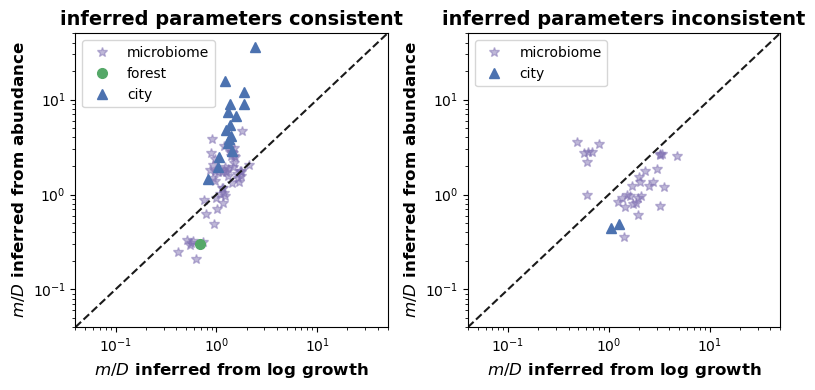

In [113]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'


shape_logG_list=[]
shape_AFD_list=[]

Delta_t=1
with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
    microbe_fit_vals_logG = pickle.load(handle)
microbe_logG_shape= np.array(microbe_fit_vals_logG['m/D_logG'])
# with open(microbiome_fit_fold+'fit_logG_with_AFD_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
#     microbe_fit_vals_AFD = pickle.load(handle)
# microbe_AFD_shape=microbe_fit_vals_AFD['m/D_AFD']


with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
    BCI_fit_vals_logG = pickle.load(handle)
BCI_logG_shape=BCI_fit_vals_logG ['m/D_logG']
# with open(BCI_fit_params_path+'fit_logG_with_AFD-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_AFD = pickle.load(handle)
# BCI_AFD_shape=BCI_fit_vals_AFD['m/D_AFD']

Delta_t=12
with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
    city_fit_vals_logG = pickle.load(handle)
city_logG_shape= np.array(city_fit_vals_logG['NeutralTheory'])[:,1]
# with open(city_fit_params_path+'logG_usingAFD_fit-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     city_fit_vals_AFD = pickle.load(handle)
# city_AFD_shape=np.array(city_fit_vals_AFD['NeutralTheory'])[:,1]





fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

idx_valid=np.zeros(len(microbe_logG_shape)).astype(bool)
for idx,val in enumerate(microbe_logG_shape):
    if val > microbe_a_lbs[idx] and val< microbe_a_ubs[idx]:
        idx_valid[idx]=True
idx_invalid=np.logical_not(idx_valid)
if np.any(idx_valid==True):
    ax1.plot(microbe_logG_shape[idx_valid],np.array(microbe_a_trues)[idx_valid],'m*', markersize=7,alpha=0.5,label='microbiome')
if np.any(idx_valid==False):
    ax2.plot(microbe_logG_shape[idx_invalid],np.array(microbe_a_trues)[idx_invalid],'m*', markersize=7,alpha=0.5,label='microbiome')
    
if BCI_logG_shape >= BCI_a_lbs and BCI_logG_shape<=BCI_a_ubs:    
    ax1.plot(BCI_logG_shape,BCI_a_trues,'go', markersize=7,label='forest')
else:
    ax2.plot(BCI_logG_shape,BCI_a_trues,'go', markersize=7,label='forest')

idx_valid=np.zeros(len(city_logG_shape)).astype(bool)
for idx,val in enumerate(city_logG_shape):
    if val >= city_a_lbs[idx] and val<=city_a_ubs[idx]:
        idx_valid[idx]=True
idx_invalid=np.logical_not(idx_valid)
if np.any(idx_valid==True):
    ax1.plot(city_logG_shape[idx_valid],np.array(city_a_trues)[idx_valid],'b^',
             markersize=7,label='city')
if np.any(idx_valid==False):
    ax2.plot(city_logG_shape[idx_invalid],np.array(city_a_trues)[idx_invalid],'b^', 
             markersize=7,label='city')
       
for ax in [ax1,ax2]:
    ax.legend(loc='best') 
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(4e-2, 5e1)
    ax.set_ylim(4e-2, 5e1)
    minval=min(ax.get_xlim()[0],ax.get_ylim()[0])
    maxval=max(ax.get_xlim()[1],ax.get_ylim()[1])
    ax.plot((minval,maxval), (minval,maxval),'k--')
    ax.set_ylabel(r'$m/D$ inferred from abundance')
    ax.set_xlabel(r'$m/D$ inferred from log growth')
ax1.set_title('inferred parameters consistent')
ax2.set_title('inferred parameters inconsistent')
fig.tight_layout()
# plt.savefig(dest_path+'compare_inferred_shapes.png')
plt.show()




# goodness of fit test AFD pctile score at logG shape 

## evaluate pctile scores by sampling AFD 1000 times at logG ENR

In [56]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'

with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_logG_df=pd.DataFrame(pickle.load(handle)  )
microbe_logG_shape= microbe_logG_df['bd_fit'].values
microbe_AFD_atlogG_params={'m/D':microbe_logG_shape}

with open(combined_params_path+'city_logG_fit_and_simvals.pkl', 'rb') as handle:
    city_logG_df=pd.DataFrame(pickle.load(handle)  )
city_logG_shape= city_logG_df['bd_fit'].values
city_AFD_atlogG_params={'m/D':city_logG_shape}


### for BCI clusters, relabu\
with open(combined_params_path+'BCI_rel_logG_clustfit_and_simvals.pkl', 'rb') as handle:
    BCI_ll_dict=pickle.load(handle)  
    del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
    BCI_rel_clust_logG_df=pd.DataFrame(BCI_ll_dict)
BCI_rel_clust_logG_shape= BCI_rel_clust_logG_df['bd_fit'].values
BCI_rel_clust_AFD_atlogG_params={'m/D':BCI_rel_clust_logG_shape}

### for BCI clusters, absolute counts
with open(combined_params_path+'BCI_logG_clustfit_and_simvals.pkl', 'rb') as handle:
    BCI_ll_dict=pickle.load(handle)  
    del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
    BCIclust_logG_df=pd.DataFrame(BCI_ll_dict)
BCIclust_logG_shape= BCIclust_logG_df['bd_fit'].values
BCIclust_AFD_atlogG_params={'m/D':BCIclust_logG_shape}

### for BCI forest as a whole without clusters.
with open(combined_params_path+'BCI_logG_fit_and_simvals.pkl', 'rb') as handle:
    BCI_ll_dict=pickle.load(handle)  
    del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
    BCI_logG_df=pd.DataFrame(BCI_ll_dict)
BCI_logG_shape= BCI_logG_df['bd_fit'].values
BCI_AFD_atlogG_params={'m/D':BCI_logG_shape}



# city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
# BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
# microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'
# Delta_t=1
# with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
#     microbe_fit_vals_logG = pickle.load(handle)
# microbe_logG_shape= np.array(microbe_fit_vals_logG['m/D_logG'])
# microbe_AFD_atlogG_params={'m/D':microbe_logG_shape}
# with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_logG = pickle.load(handle)
# BCI_logG_shape=BCI_fit_vals_logG ['m/D_logG']
# BCI_AFD_atlogG_params={'m/D':BCI_logG_shape}
# Delta_t=12
# with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     city_AFD_atlogG_params = pickle.load(handle)
# city_logG_shape= np.array(city_fit_vals_logG['NeutralTheory'])[:,1]
# city_AFD_atlogG_params={'m/D':city_logG_shape}


time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]

microbe_pctile_score_list=[]
microbe_scale_gamma_guess_fit_list=[]
for sp in range(len(rel_abu_mat)):
    otu_abu=rel_abu_mat[sp]
    otu_abu=otu_abu[otu_abu>0]
    a_guess=microbe_logG_shape[sp]
    a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                            otu_abu, fa=a_guess,floc=0.,scale=2 )
    microbe_scale_gamma_guess_fit_list.append(scale_gamma_fit)
    temp=scipy.stats.gamma.logpdf(otu_abu, a_guess, loc=0,scale= scale_gamma_fit)
    logLik_data= np.sum(temp) 

    logLik_sim_list=[]
    for j in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                         size=len(otu_abu))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_sim_list.append(np.sum(temp) )
    logLik_sim_arr=np.array(logLik_sim_list)
    if np.any(logLik_sim_arr>logLik_data):
        percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
    else:
        percentile_score=0.
    microbe_pctile_score_list.append(percentile_score)
#######BCI neut
BCI_scale_gamma_guess_fit_list=[]
BCI_popn_1995=BCI_popn[:,1]
BCI_popn_1995=BCI_popn_1995[BCI_popn_1995>0]   
a_guess=BCI_logG_shape
a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                        BCI_popn_1995, fa=a_guess,floc=0.,scale=2 )
BCI_scale_gamma_guess_fit_list.append(scale_gamma_fit)
temp=scipy.stats.gamma.logpdf(BCI_popn_1995, a_guess, loc=0,scale= scale_gamma_fit)
logLik_data= np.sum(temp) 

logLik_sim_list=[]
for j in range(1000):
    rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                     size=len(BCI_popn_1995))
    temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
    logLik_sim_list.append(np.sum(temp) )
logLik_sim_arr=np.array(logLik_sim_list)
if np.any(logLik_sim_arr>logLik_data):
    percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
else:
    percentile_score=0.
BCI_pctile_score=percentile_score

##### BCI clusters relabu
BCI_rel_clust_pctile_score_list=[]
BCI_rel_clust_scale_gamma_guess_fit_list=[]
for i in range(4):
    clust_id=i+1
    clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==clust_id]['Y1995'].values
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0]

    a_guess=BCI_rel_clust_logG_shape[i]
    a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                            clust_popn_1995, fa=a_guess,floc=0.,scale=2 )
    BCI_rel_clust_scale_gamma_guess_fit_list.append(scale_gamma_fit)
    temp=scipy.stats.gamma.logpdf(clust_popn_1995, a_guess, loc=0,scale= scale_gamma_fit)
    logLik_data= np.sum(temp) 
    logLik_sim_list=[]
    for j in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                         size=len(clust_popn_1995))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_sim_list.append(np.sum(temp) )
    logLik_sim_arr=np.array(logLik_sim_list)
    if np.any(logLik_sim_arr>logLik_data):
        percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
    else:
        percentile_score=0.
    BCI_rel_clust_pctile_score_list.append(percentile_score)



##### BCI clusters absolute counts
BCIclust_pctile_score_list=[]
BCIclust_scale_gamma_guess_fit_list=[]
for i in range(4):
    clust_id=i+1
    clust_popn_1995=df_counts[df_counts['height_cluster']==clust_id]['Y1995'].values
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0]

    a_guess=BCIclust_logG_shape[i]
    a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                            clust_popn_1995, fa=a_guess,floc=0.,scale=2 )
    BCIclust_scale_gamma_guess_fit_list.append(scale_gamma_fit)
    temp=scipy.stats.gamma.logpdf(clust_popn_1995, a_guess, loc=0,scale= scale_gamma_fit)
    logLik_data= np.sum(temp) 
    logLik_sim_list=[]
    for j in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                         size=len(clust_popn_1995))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_sim_list.append(np.sum(temp) )
    logLik_sim_arr=np.array(logLik_sim_list)
    if np.any(logLik_sim_arr>logLik_data):
        percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
    else:
        percentile_score=0.
    BCIclust_pctile_score_list.append(percentile_score)




####city
city_scale_gamma_guess_fit_list=[]
city_pctile_score_list=[]
naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')
for i,naics in enumerate(naics_keys_to_plot):
    emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
    emp=emp[indxs]
    
    a_guess=city_logG_shape[i]
    a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                            emp, fa=a_guess,floc=0.,scale=2 )
    city_scale_gamma_guess_fit_list.append(scale_gamma_fit)

    temp=scipy.stats.gamma.logpdf(emp, a_guess, loc=0,scale= scale_gamma_fit)
    logLik_data= np.sum(temp) 
    logLik_sim_list=[]
    for j in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                         size=len(emp))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_sim_list.append(np.sum(temp) )
    logLik_sim_arr=np.array(logLik_sim_list)
    if np.any(logLik_sim_arr>logLik_data):
        percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
    else:
        percentile_score=0.
    city_pctile_score_list.append(percentile_score)

city_AFD_atlogG_params.update({'scale_gamma_atlogG_fit':city_scale_gamma_guess_fit_list})
microbe_AFD_atlogG_params.update({'scale_gamma_atlogG_fit':microbe_scale_gamma_guess_fit_list}) 
BCI_AFD_atlogG_params.update({'scale_gamma_atlogG_fit':BCI_scale_gamma_guess_fit_list}) 
BCIclust_AFD_atlogG_params.update({'scale_gamma_atlogG_fit':BCIclust_scale_gamma_guess_fit_list}) 
BCI_rel_clust_AFD_atlogG_params.update({'scale_gamma_atlogG_fit':BCI_rel_clust_scale_gamma_guess_fit_list}) 


BCI_rel_clust_AFD_atlogG_params.update({'pctile_scores':BCI_rel_clust_pctile_score_list}) 
BCIclust_AFD_atlogG_params.update({'pctile_scores':BCIclust_pctile_score_list}) 
city_AFD_atlogG_params.update({'pctile_scores':city_pctile_score_list})
microbe_AFD_atlogG_params.update({'pctile_scores':microbe_pctile_score_list}) 
BCI_AFD_atlogG_params.update({'pctile_scores':[BCI_pctile_score]}) 
    
with open(combined_params_path+'microbe_AFD_atlogG_params_pctiles.pkl', 'wb') as handle:
    pickle.dump(microbe_AFD_atlogG_params, handle,protocol=4)     
with open(combined_params_path+'BCI_AFD_atlogG_params_pctiles.pkl', 'wb') as handle:
    pickle.dump(BCI_AFD_atlogG_params, handle,protocol=4)  
with open(combined_params_path+'BCIclust_AFD_atlogG_params_pctiles.pkl', 'wb') as handle:
    pickle.dump(BCIclust_AFD_atlogG_params, handle,protocol=4)      
with open(combined_params_path+'BCI_rel_clust_AFD_atlogG_params_pctiles.pkl', 'wb') as handle:
    pickle.dump(BCI_rel_clust_AFD_atlogG_params, handle,protocol=4)    
with open(combined_params_path+'city_AFD_atlogG_params_pctiles.pkl', 'wb') as handle:
    pickle.dump(city_AFD_atlogG_params, handle,protocol=4)  

In [42]:
BCIclust_AFD_atlogG_params

{'m/D': array([0.80067748, 1.22785718, 0.99450063, 1.13295192]),
 'scale_gamma_atlogG_fit': [1003.5400282733964,
  843.8549257637883,
  482.6040176817499,
  769.6147518164656],
 'pctile_scores': [0.0, 99.4, 49.8, 91.0]}

In [12]:
threshold=95
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

idx_valid=np.ones(len(microbe_logG_shape)).astype(bool)
for idx,val in enumerate(microbe_pctile_score_list):
    if val > threshold:
        idx_valid[idx]=False
idx_invalid=np.logical_not(idx_valid)
if np.any(idx_valid==True):
    ax1.plot(microbe_logG_shape[idx_valid],np.array(microbe_a_trues)[idx_valid],'m*', markersize=7,alpha=0.5,label='microbiome')
if np.any(idx_valid==False):
    ax2.plot(microbe_logG_shape[idx_invalid],np.array(microbe_a_trues)[idx_invalid],'m*', markersize=7,alpha=0.5,label='microbiome')
    
if BCI_pctile_score<threshold:    
    ax1.plot(BCI_logG_shape,BCI_a_trues,'go', markersize=7,label='forest')
else:
    ax2.plot(BCI_logG_shape,BCI_a_trues,'go', markersize=7,label='forest')

idx_valid=np.ones(len(city_logG_shape)).astype(bool)
for idx,val in enumerate(city_pctile_score_list):
    if val > threshold:
        idx_valid[idx]=False
idx_invalid=np.logical_not(idx_valid)
if np.any(idx_valid==True):
    ax1.plot(city_logG_shape[idx_valid],np.array(city_a_trues)[idx_valid],'b^',
             markersize=7,label='city')
if np.any(idx_valid==False):
    ax2.plot(city_logG_shape[idx_invalid],np.array(city_a_trues)[idx_invalid],'b^', 
             markersize=7,label='city')
       
for ax in [ax1,ax2]:
    ax.legend(loc='best') 
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(4e-2, 5e1)
    ax.set_ylim(4e-2, 5e1)
    minval=min(ax.get_xlim()[0],ax.get_ylim()[0])
    maxval=max(ax.get_xlim()[1],ax.get_ylim()[1])
    ax.plot((minval,maxval), (minval,maxval),'k--')
    ax.set_ylabel(r'$m/D$ inferred from abundance')
    ax.set_xlabel(r'$m/D$ inferred from log growth')
ax1.set_title('inferred parameters consistent')
ax2.set_title('inferred parameters inconsistent')
fig.tight_layout()
# plt.savefig(dest_path+'compare_inferred_shapes.png')
plt.show()




NameError: name 'microbe_a_trues' is not defined

# goodness of fit test logG at AFD fit params


--- CORRECT ERROR IN MICROBES
emp_logG was used to calculate loglikelihood! INSTEAD OF logG.  - but this loglikelihood was not used in any downstream analysis. So its fine. 
Error was:

    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., fbd=microbe_err_bars_dict['a_gamma_true'][i], floc=0,fscale=1.)
    ll=neutral_inst.logpdf(emp_logG,  neut_tp, neut_bd, loc=0,scale=1.)
    
replace ll line with  
    ll=neutral_inst.logpdf(logG,  neut_tp, neut_bd, loc=0,scale=1.)

## find best fit tau at AFD m/D

In [54]:
with open(combined_params_path+'microbe_AFD_shape_error_estimates.pkl', 'rb') as handle:
    microbe_err_bars_dict=pickle.load(handle)  


neutral_inst = shared_func.azaele_neutral_logG_distribution()
microbe_logG_atAFD_params={'sp':[],
                        'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

for i,sp in enumerate(microbe_err_bars_dict['sp']):
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)

    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., fbd=microbe_err_bars_dict['a_gamma_true'][i], floc=0,fscale=1.)
#     ll=neutral_inst.logpdf(emp_logG,  neut_tp, neut_bd, loc=0,scale=1.)
    ## correct line:
    ll=neutral_inst.logpdf(logG,  neut_tp, neut_bd, loc=0,scale=1.)
    
    microbe_logG_atAFD_params['sp'].append(sp)
    microbe_logG_atAFD_params['tp_fit'].append(neut_tp)
    microbe_logG_atAFD_params['bd_fit'].append(neut_bd)
    microbe_logG_atAFD_params['data_length'].append(len(logG))
    microbe_logG_atAFD_params['logLk'].append(np.sum(ll)) 
with open(combined_params_path+'microbe_logG_atAFD_fitvals.pkl', 'wb') as handle:
    pickle.dump(microbe_logG_atAFD_params, handle,protocol=4)  

In [50]:
with open(combined_params_path+'city_AFD_shape_error_estimates.pkl', 'rb') as handle:
    city_err_bars_dict=pickle.load(handle)  
assert city_err_bars_dict['time_stamp_abu']=='16-Q3-M1'

neutral_inst = shared_func.azaele_neutral_logG_distribution()
city_logG_atAFD_params={'naics':[],'time_stamp_abu':'16-Q3-M1',
                        'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}
naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')

for i,naics in enumerate(naics_keys_to_plot):
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            emp_logG,10., fbd=city_err_bars_dict['a_gamma_true'][i], floc=0,fscale=1.)
    ll=neutral_inst.logpdf(emp_logG,  neut_tp, neut_bd, loc=0,scale=1.)
    city_logG_atAFD_params['naics'].append(naics)
    city_logG_atAFD_params['tp_fit'].append(neut_tp)
    city_logG_atAFD_params['bd_fit'].append(neut_bd)
    city_logG_atAFD_params['data_length'].append(len(emp_logG))
    city_logG_atAFD_params['logLk'].append(np.sum(ll)) 
with open(combined_params_path+'city_logG_atAFD_fitvals.pkl', 'wb') as handle:
    pickle.dump(city_logG_atAFD_params, handle,protocol=4)  

##### for BCI without clusters, absolute abundance

In [48]:
with open(combined_params_path+'BCI_AFD_shape_error_estimates.pkl', 'rb') as handle:
    BCI_err_bars_dict=pickle.load(handle)  

assert BCI_err_bars_dict['year']=='1995',' year we chose at random'

neutral_inst = shared_func.azaele_neutral_logG_distribution()
BCI_logG_atAFD_params={'sp':[0],'year':BCI_err_bars_dict['year'],
                       'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}
neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
        BCI_logG,10., fbd=BCI_err_bars_dict['a_gamma_true'][0], floc=0,fscale=1.)

ll=neutral_inst.logpdf(BCI_logG,  neut_tp, neut_bd, loc=0,scale=1.)
# BCI_logG_atAFD_params['sp'].append(sp)
BCI_logG_atAFD_params['tp_fit'].append(neut_tp)
BCI_logG_atAFD_params['bd_fit'].append(neut_bd)
BCI_logG_atAFD_params['data_length'].append(len(BCI_logG))  
BCI_logG_atAFD_params['logLk'].append(np.sum(ll)) 
with open(combined_params_path+'BCI_logG_atAFD_fitvals.pkl', 'wb') as handle:
    pickle.dump(BCI_logG_atAFD_params, handle,protocol=4)  


In [49]:
BCI_err_bars_dict['a_gamma_true'][0]

0.30010465489668214

##### for BCI clusts rel abus

In [46]:
with open(combined_params_path+'BCI_rel_clust_AFD_shape_error_estimates.pkl', 'rb') as handle:
    BCI_rel_clust_err_bars_dict=pickle.load(handle)  
neutral_inst = shared_func.azaele_neutral_logG_distribution()
BCI_rel_clust_logG_atAFD_params={'height_cluster':[],'year':'1995',
                       'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}

for i in range(4):
    clust_id=i+1
    BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)   

    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            BCI_logG_clusti,10., fbd=BCI_rel_clust_err_bars_dict['a_gamma_true'][i], floc=0,fscale=1.)

    ll=neutral_inst.logpdf(BCI_logG,  neut_tp, neut_bd, loc=0,scale=1.)
    # BCI_rel_clust_logG_atAFD_params['sp'].append(sp)
    BCI_rel_clust_logG_atAFD_params['tp_fit'].append(neut_tp)
    BCI_rel_clust_logG_atAFD_params['bd_fit'].append(neut_bd)
    BCI_rel_clust_logG_atAFD_params['data_length'].append(len(BCI_logG_clusti))  
    BCI_rel_clust_logG_atAFD_params['logLk'].append(np.sum(ll)) 
    BCI_rel_clust_logG_atAFD_params['height_cluster'].append(
        BCI_rel_clust_err_bars_dict['height_cluster'][i])
with open(combined_params_path+'BCI_rel_clust_logG_atAFD_fitvals.pkl', 'wb') as handle:
    pickle.dump(BCI_rel_clust_logG_atAFD_params, handle,protocol=4)  


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide


##### for BCI clusts absolute abundances

In [120]:
with open(combined_params_path+'BCIclust_AFD_shape_error_estimates.pkl', 'rb') as handle:
    BCIclust_err_bars_dict=pickle.load(handle)  

neutral_inst = shared_func.azaele_neutral_logG_distribution()
BCIclust_logG_atAFD_params={'height_cluster':[],'year':'1995',
                       'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}

for i in range(4):
    clust_id=i+1
    BCI_logG_clusti=get_BCI_clust_logG(df_counts,clust_id)   

    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            BCI_logG_clusti,10., fbd=BCIclust_err_bars_dict['a_gamma_true'][i], floc=0,fscale=1.)

    ll=neutral_inst.logpdf(BCI_logG,  neut_tp, neut_bd, loc=0,scale=1.)
    # BCIclust_logG_atAFD_params['sp'].append(sp)
    BCIclust_logG_atAFD_params['tp_fit'].append(neut_tp)
    BCIclust_logG_atAFD_params['bd_fit'].append(neut_bd)
    BCIclust_logG_atAFD_params['data_length'].append(len(BCI_logG_clusti))  
    BCIclust_logG_atAFD_params['logLk'].append(np.sum(ll)) 
    BCIclust_logG_atAFD_params['height_cluster'].append(
        BCIclust_err_bars_dict['height_cluster'][i])
with open(combined_params_path+'BCIclust_logG_atAFD_fitvals.pkl', 'wb') as handle:
    pickle.dump(BCIclust_logG_atAFD_params, handle,protocol=4)  


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide


In [121]:
BCIclust_logG_atAFD_params

{'height_cluster': [1, 2, 3, 4],
 'year': '1995',
 'tp_fit': [0.000934600830078125,
  0.0005702972412109375,
  0.001300811767578125,
  0.001007080078125],
 'bd_fit': [0.2478811653855468,
  0.34524596301014454,
  0.4785116256333881,
  0.39678952979696863],
 'data_length': [251, 225, 179, 189],
 'logLk': [24.446339889636096,
  46.95388128587766,
  60.16000897447068,
  53.76509027282932]}

## evaluate percentile scores

In [52]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'

with open(combined_params_path+'microbe_logG_atAFD_fit_and_simvals.pkl', 'rb') as handle:
    microbe_fit_logLkhd = pickle.load(handle)
with open(combined_params_path+'city_logG_atAFD_fit_and_simvals.pkl', 'rb') as handle:
    city_fit_logLkhd = pickle.load(handle)


microbe_pctile_score_list=[]
for sp in range(len(microbe_fit_logLkhd['sp'])):
    logLik_data=microbe_fit_logLkhd['logLk'][sp]
    logLik_sim_arr=microbe_fit_logLkhd['logLk_sims'][sp]

    if np.any(logLik_sim_arr>logLik_data):
        percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
    else:
        percentile_score=0.
    microbe_pctile_score_list.append(percentile_score)
    
microbe_fit_logLkhd.update({'pctile_scores':microbe_pctile_score_list})


city_pctile_score_list=[]
for i in range(len(city_fit_logLkhd['naics'])):
    logLik_data=city_fit_logLkhd['logLk'][i]
    logLik_sim_arr=city_fit_logLkhd['logLk_sims'][i]

    if np.any(logLik_sim_arr>logLik_data):
        percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
    else:
        percentile_score=0.
    city_pctile_score_list.append(percentile_score)

city_fit_logLkhd.update({'pctile_scores':city_pctile_score_list})
        
#### for all trees together. 
with open(combined_params_path+'BCI_logG_atAFD_fit_and_simvals.pkl', 'rb') as handle:
    BCI_fit_logLkhd = pickle.load(handle)
BCI_pctile_score_list=[]
logLik_data=BCI_fit_logLkhd['logLk'][0]
logLik_sim_arr=BCI_fit_logLkhd['logLk_sims'][0]
if np.any(logLik_sim_arr>logLik_data):
    percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
else:
    percentile_score=0.
BCI_pctile_score_list.append(percentile_score)
BCI_fit_logLkhd.update({'pctile_scores':BCI_pctile_score_list})



with open(combined_params_path+'microbe_logG_atAFD_fit_and_simvals_pctiles.pkl', 'wb') as handle:
    pickle.dump(microbe_fit_logLkhd, handle,protocol=4)     
with open(combined_params_path+'BCI_logG_atAFD_fit_and_simvals_pctiles.pkl', 'wb') as handle:
    pickle.dump(BCI_fit_logLkhd, handle,protocol=4)  
with open(combined_params_path+'city_logG_atAFD_fit_and_simvals_pctiles.pkl', 'wb') as handle:
    pickle.dump(city_fit_logLkhd, handle,protocol=4)  
    
    
    
####### for BCI height clusters, absolute counts    
with open(combined_params_path+'BCIclust_logG_atAFD_fit_and_simvals.pkl', 'rb') as handle:
    BCIclust_fit_logLkhd = pickle.load(handle)
BCIclust_pctile_score_list=[]
for i in range(len( BCIclust_fit_logLkhd['height_cluster'])):
    
    logLik_data=BCIclust_fit_logLkhd['logLk'][i]
    logLik_sim_arr=BCIclust_fit_logLkhd['logLk_sims'][i]
    if np.any(logLik_sim_arr>logLik_data):
        percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
    else:
        percentile_score=0.
    BCIclust_pctile_score_list.append(percentile_score)
    BCIclust_fit_logLkhd.update({'pctile_scores':BCIclust_pctile_score_list})
with open(combined_params_path+'BCIclust_logG_atAFD_fit_and_simvals_pctiles.pkl', 'wb') as handle:
    pickle.dump(BCIclust_fit_logLkhd, handle,protocol=4)  
    
####### for BCI height clusters, relative abundances
with open(combined_params_path+'BCI_rel_clust_logG_atAFD_fit_and_simvals.pkl', 'rb') as handle:
    BCI_rel_clust_fit_logLkhd = pickle.load(handle)
BCI_rel_clust_pctile_score_list=[]
for i in range(len( BCI_rel_clust_fit_logLkhd['height_cluster'])):  
    logLik_data=BCI_rel_clust_fit_logLkhd['logLk'][i]
    logLik_sim_arr=BCI_rel_clust_fit_logLkhd['logLk_sims'][i]
    if np.any(logLik_sim_arr>logLik_data):
        percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
    else:
        percentile_score=0.
    BCI_rel_clust_pctile_score_list.append(percentile_score)
    BCI_rel_clust_fit_logLkhd.update({'pctile_scores':BCI_rel_clust_pctile_score_list})
with open(combined_params_path+'BCI_rel_clust_logG_atAFD_fit_and_simvals_pctiles.pkl', 'wb') as handle:
    pickle.dump(BCI_rel_clust_fit_logLkhd, handle,protocol=4)  

In [53]:
BCIclust_pctile_score_list

[0.0, 0.0, 4.0, 0.0]

In [54]:
BCI_rel_clust_pctile_score_list

[0.0, 13.0, 10.0, 25.0]

# combine both pctile scores into one figure

we evaluate pctile score of logG dist fit at AFD m/D and AFD dist fit at logG m/D, and see which data points fail both tests.

## for BCI clusts (absolute counts)

for microbiome data
n valid= 57 n invalid= 28


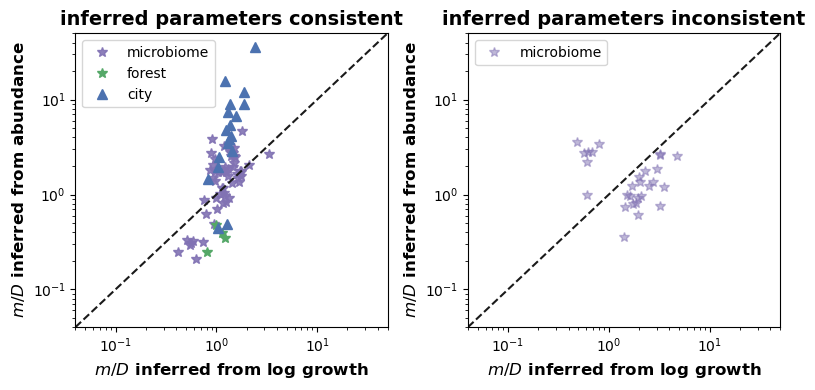

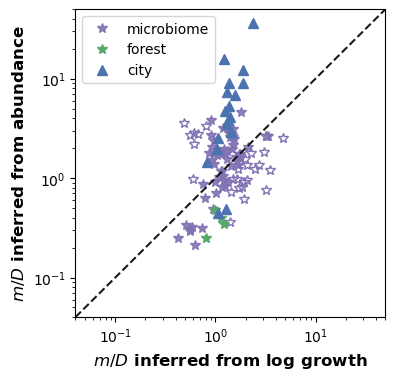

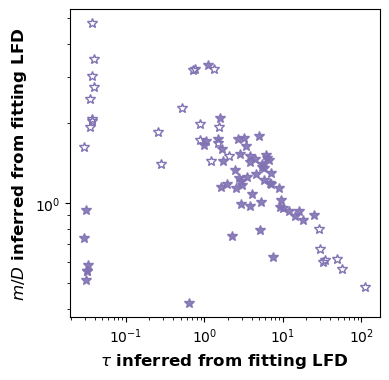

In [46]:
threshold=95 # for rejection (only if both pctile scores>95 is data rejected)

with open(combined_params_path+'microbe_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    microbe_AFD_atlogG_params=pickle.load(handle)     
with open(combined_params_path+'BCIclust_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    BCIclust_AFD_atlogG_params=pickle.load(handle)  
with open(combined_params_path+'city_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    city_AFD_atlogG_params=pickle.load( handle)  
    
    
    
with open(combined_params_path+'microbe_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    microbe_logG_atAFD_params=pickle.load( handle)     
with open(combined_params_path+'BCIclust_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    BCIclust_logG_atAFD_params=pickle.load( handle)  
with open(combined_params_path+'city_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    city_logG_atAFD_params=pickle.load( handle)  

with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_logGtrue_df=pd.DataFrame(pickle.load(handle)  )
microbe_tau_true_vals= 1./microbe_logGtrue_df['tp_fit'].values
    
    
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig2 = plt.figure(figsize=(4, 4))
ax2_1 = fig2.add_subplot()
fig3 = plt.figure(figsize=(4, 4))
ax3_1 = fig3.add_subplot()

microbe_logG_shape=np.array(microbe_AFD_atlogG_params['m/D'])
microbe_AFD_shape=np.array(microbe_logG_atAFD_params['bd_fit'])
idx_valid=np.zeros(len(microbe_logG_shape)).astype(bool)
### if idx is cannot be rejected in one of the two cases, then it is valid (cannto be rejected )
for idx,val in enumerate(microbe_AFD_atlogG_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
for idx,val in enumerate(microbe_logG_atAFD_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True      
        
idx_invalid=np.logical_not(idx_valid)

microbe_gof_idx_valid=deepcopy(idx_valid)

if np.any(idx_valid==True):
    ax1.plot(microbe_logG_shape[idx_valid],microbe_AFD_shape[idx_valid],'m*', markersize=7,alpha=0.9,label='microbiome')
    ax2_1.plot(microbe_logG_shape[idx_valid],microbe_AFD_shape[idx_valid],'*', color='m', markersize=7,alpha=0.9,label='microbiome')
    ax3_1.plot(microbe_tau_true_vals[idx_valid],microbe_logG_shape[idx_valid],'*', color='m', markersize=7,alpha=0.9,label='microbiome')

if np.any(idx_valid==False):
    ax2.plot(microbe_logG_shape[idx_invalid],microbe_AFD_shape[idx_invalid],'m*', markersize=7,alpha=0.5,label='microbiome')
    ax2_1.plot(microbe_logG_shape[idx_invalid],microbe_AFD_shape[idx_invalid],'*', mec='m', mfc='None', markersize=7)
    ax3_1.plot(microbe_tau_true_vals[idx_invalid],microbe_logG_shape[idx_invalid],'*', mec='m', mfc='None', markersize=7)
print('for microbiome data')    
print ( 'n valid=', np.sum(idx_valid), 'n invalid=', np.sum(idx_invalid))    
BCIclust_logG_shape=np.array(BCIclust_AFD_atlogG_params['m/D'])
BCIclust_AFD_shape=np.array(BCIclust_logG_atAFD_params['bd_fit'])
# BCIclust_pctile_score1=float(BCIclust_AFD_atlogG_params['pctile_scores'][0])
# BCIclust_pctile_score2=float(BCIclust_logG_atAFD_params['pctile_scores'][0])

idx_valid=np.zeros(len(BCIclust_logG_shape)).astype(bool)

for idx,val in enumerate(BCIclust_AFD_atlogG_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
for idx,val in enumerate(BCIclust_logG_atAFD_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
idx_invalid=np.logical_not(idx_valid)

if np.any(idx_valid==True):
    ax1.plot(BCIclust_logG_shape[idx_valid],BCIclust_AFD_shape[idx_valid],'g*',
             markersize=7,label='forest')
    ax2_1.plot(BCIclust_logG_shape[idx_valid],BCIclust_AFD_shape[idx_valid],'g*',
             markersize=7,label='forest')
if np.any(idx_valid==False):
    ax2.plot(BCIclust_logG_shape[idx_invalid],BCIclust_AFD_shape[idx_invalid],'g*' ,
             markersize=7,label='forest')
    ax2_1.plot(BCIclust_logG_shape[idx_invalid],BCIclust_AFD_shape[idx_invalid],'*',mec='g', mfc='None' ,
             markersize=7,label='forest')
    
    
    
city_logG_shape=np.array(city_AFD_atlogG_params['m/D'])
city_AFD_shape=np.array(city_logG_atAFD_params['bd_fit'])
idx_valid=np.zeros(len(city_logG_shape)).astype(bool)

for idx,val in enumerate(city_AFD_atlogG_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
for idx,val in enumerate(city_logG_atAFD_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
idx_invalid=np.logical_not(idx_valid)
if np.any(idx_valid==True):
    ax1.plot(city_logG_shape[idx_valid],city_AFD_shape[idx_valid],'b^',
             markersize=7,label='city')
    ax2_1.plot(city_logG_shape[idx_valid],city_AFD_shape[idx_valid],'b^',
             markersize=7,label='city')
if np.any(idx_valid==False):
    ax2.plot(city_logG_shape[idx_invalid],city_AFD_shape[idx_invalid],'b^' ,
             markersize=7,label='city')
    ax2_1.plot(city_logG_shape[idx_invalid],city_AFD_shape[idx_invalid],'^',mec='b', mfc='None' ,
             markersize=7,label='city')
       
for ax in [ax1,ax2,ax2_1]:
    ax.legend(loc='best') 
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(4e-2, 5e1)
    ax.set_ylim(4e-2, 5e1)
    minval=min(ax.get_xlim()[0],ax.get_ylim()[0])
    maxval=max(ax.get_xlim()[1],ax.get_ylim()[1])
    ax.plot((minval,maxval), (minval,maxval),'k--')
    ax.set_ylabel(r'$m/D$ inferred from abundance')
    ax.set_xlabel(r'$m/D$ inferred from log growth')
    
    
ax3_1.set_xscale('log')
ax3_1.set_yscale('log')
ax3_1.set_ylabel(r'$m/D$ inferred from fitting LFD')
ax3_1.set_xlabel(r'$\tau$ inferred from fitting LFD')


ax1.set_title('inferred parameters consistent')
ax2.set_title('inferred parameters inconsistent')
fig.tight_layout()
# plt.savefig(dest_path+'com.png')
plt.show()







## for BCI neut

In [15]:
with open(combined_params_path+'microbe_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    microbe_AFD_atlogG_params=pickle.load(handle)     
with open(combined_params_path+'BCI_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    BCI_AFD_atlogG_params=pickle.load(handle)  
with open(combined_params_path+'city_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    city_AFD_atlogG_params=pickle.load( handle)  
    
    
    
with open(combined_params_path+'microbe_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    microbe_logG_atAFD_params=pickle.load( handle)     
with open(combined_params_path+'BCI_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    BCI_logG_atAFD_params=pickle.load( handle)  
with open(combined_params_path+'city_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    city_logG_atAFD_params=pickle.load( handle)  

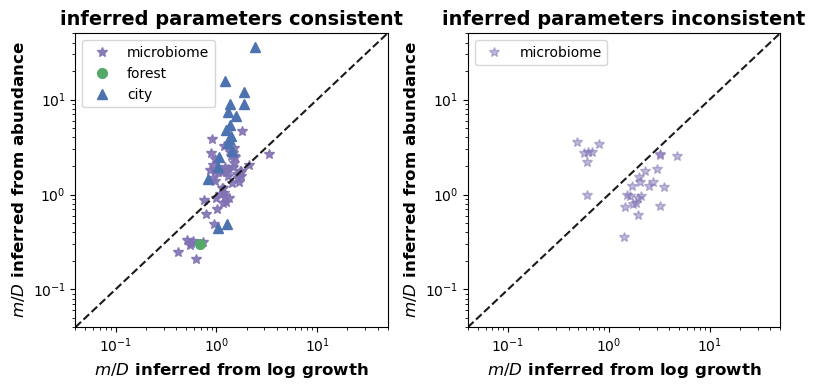

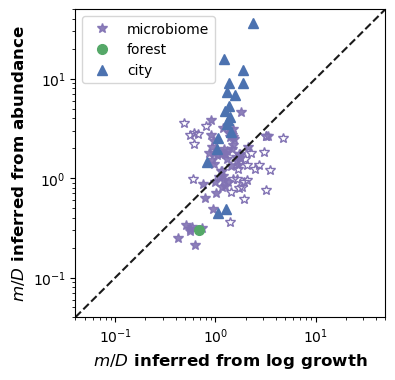

In [16]:
threshold=95



fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig2 = plt.figure(figsize=(4, 4))
ax2_1 = fig2.add_subplot()

microbe_logG_shape=np.array(microbe_AFD_atlogG_params['m/D'])
microbe_AFD_shape=np.array(microbe_logG_atAFD_params['bd_fit'])
idx_valid=np.zeros(len(microbe_logG_shape)).astype(bool)
### if idx is cannot be rejected in one of the two cases, then it is valid (cannto be rejected )
for idx,val in enumerate(microbe_AFD_atlogG_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
for idx,val in enumerate(microbe_logG_atAFD_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True      
        
idx_invalid=np.logical_not(idx_valid)
if np.any(idx_valid==True):
    ax1.plot(microbe_logG_shape[idx_valid],microbe_AFD_shape[idx_valid],'m*', markersize=7,alpha=0.9,label='microbiome')
    ax2_1.plot(microbe_logG_shape[idx_valid],microbe_AFD_shape[idx_valid],'*', color='m', markersize=7,alpha=0.9,label='microbiome')
if np.any(idx_valid==False):
    ax2.plot(microbe_logG_shape[idx_invalid],microbe_AFD_shape[idx_invalid],'m*', markersize=7,alpha=0.5,label='microbiome')
    ax2_1.plot(microbe_logG_shape[idx_invalid],microbe_AFD_shape[idx_invalid],'*', mec='m', mfc='None', markersize=7)
    
    
BCI_logG_shape=np.array(BCI_AFD_atlogG_params['m/D'])
BCI_AFD_shape=np.array(BCI_logG_atAFD_params['bd_fit'])
BCI_pctile_score1=float(BCI_AFD_atlogG_params['pctile_scores'][0])
BCI_pctile_score2=float(BCI_logG_atAFD_params['pctile_scores'][0])
if BCI_pctile_score1<threshold or BCI_pctile_score2<threshold :    
    ax1.plot(BCI_logG_shape,BCI_AFD_shape,'go', markersize=7,label='forest')
    ax2_1.plot(BCI_logG_shape,BCI_AFD_shape,'go', markersize=7,label='forest',)
else:
    ax2.plot(BCI_logG_shape,BCI_AFD_shape,'go', markersize=7,label='forest')
    ax2_1.plot(BCI_logG_shape,BCI_AFD_shape,'o', markersize=7,label='forest',mec='g', mfc='None')

city_logG_shape=np.array(city_AFD_atlogG_params['m/D'])
city_AFD_shape=np.array(city_logG_atAFD_params['bd_fit'])
idx_valid=np.zeros(len(city_logG_shape)).astype(bool)

for idx,val in enumerate(city_AFD_atlogG_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
for idx,val in enumerate(city_logG_atAFD_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
idx_invalid=np.logical_not(idx_valid)
if np.any(idx_valid==True):
    ax1.plot(city_logG_shape[idx_valid],city_AFD_shape[idx_valid],'b^',
             markersize=7,label='city')
    ax2_1.plot(city_logG_shape[idx_valid],city_AFD_shape[idx_valid],'b^',
             markersize=7,label='city')
if np.any(idx_valid==False):
    ax2.plot(city_logG_shape[idx_invalid],city_AFD_shape[idx_invalid],'b^' ,
             markersize=7,label='city')
    ax2_1.plot(city_logG_shape[idx_invalid],city_AFD_shape[idx_invalid],'^',mec='b', mfc='None' ,
             markersize=7,label='city')
       
for ax in [ax1,ax2,ax2_1]:
    ax.legend(loc='best') 
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(4e-2, 5e1)
    ax.set_ylim(4e-2, 5e1)
    minval=min(ax.get_xlim()[0],ax.get_ylim()[0])
    maxval=max(ax.get_xlim()[1],ax.get_ylim()[1])
    ax.plot((minval,maxval), (minval,maxval),'k--')
    ax.set_ylabel(r'$m/D$ inferred from abundance')
    ax.set_xlabel(r'$m/D$ inferred from log growth')
ax1.set_title('inferred parameters consistent')
ax2.set_title('inferred parameters inconsistent')
fig.tight_layout()
# plt.savefig(dest_path+'com.png')
plt.show()







## plot microbes where other dist is better

In [53]:
with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'rb') as handle:
    microbe_logG_compare_dists=pickle.load(handle)  
idx_valid=np.zeros(len(microbe_logG_shape)).astype(bool)
for idx,val in enumerate(microbe_logG_compare_dists['best_dist_list']):
    if val =='BDI':
        idx_valid[idx]=True          
idx_invalid=np.logical_not(idx_valid)

microbe_AIC_idx_valid=deepcopy(idx_valid)

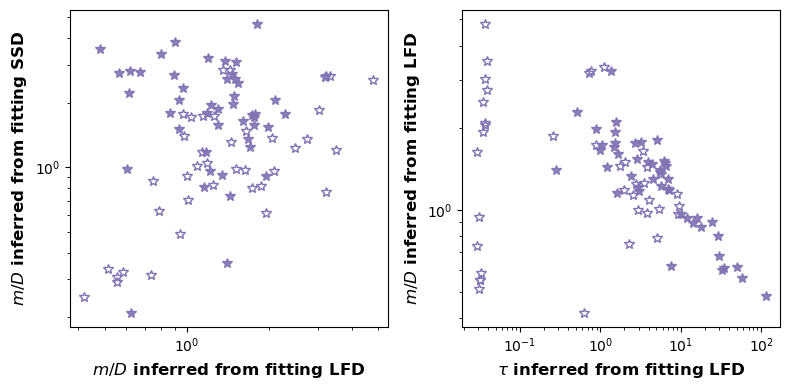

In [43]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


if np.any(idx_valid==True):
    ax1.plot(microbe_logG_shape[idx_valid],microbe_AFD_shape[idx_valid],'*', color='m', markersize=7,alpha=0.9,label='microbiome')
    ax2.plot(microbe_tau_true_vals[idx_valid],microbe_logG_shape[idx_valid],'*', color='m', markersize=7,alpha=0.9,label='microbiome')

if np.any(idx_valid==False):
    ax1.plot(microbe_logG_shape[idx_invalid],microbe_AFD_shape[idx_invalid],'*', mec='m', mfc='None', markersize=7)
    ax2.plot(microbe_tau_true_vals[idx_invalid],microbe_logG_shape[idx_invalid],'*', mec='m', mfc='None', markersize=7)
for ax in [ax1,ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylabel(r'$m/D$ inferred from abundance')
    ax.set_xlabel(r'$m/D$ inferred from log growth')
    

ax1.set_ylabel(r'$m/D$ inferred from fitting SSD')
ax1.set_xlabel(r'$m/D$ inferred from fitting LFD')

ax2.set_ylabel(r'$m/D$ inferred from fitting LFD')
ax2.set_xlabel(r'$\tau$ inferred from fitting LFD')

fig.tight_layout()
# plt.savefig(dest_path+'com.png')
plt.show()

Number of points that pass both tests vs passing one of the tests.

In [52]:
print ('fail AIC',np.sum(~microbe_AIC_idx_valid), 'fail gof', np.sum(~microbe_gof_idx_valid))
print ('fail both',np.sum(~microbe_AIC_idx_valid*~microbe_gof_idx_valid))

fail AIC 39 fail gof 28
fail both 14


In [49]:
print ('pass AIC',np.sum(microbe_AIC_idx_valid), 'pass gof', np.sum(microbe_gof_idx_valid))
print ('pass both',np.sum(microbe_AIC_idx_valid*microbe_gof_idx_valid))

pass AIC 46 pass gof 57
pass both 32


In [ ]:
fig = plt.figure(figsize=(4, 4))
ax2 = fig.add_subplot()
if np.any(idx_valid==True):
    ax2.plot(microbe_tau_true_vals[idx_valid],microbe_logG_shape[idx_valid],'*', color='m', markersize=7,alpha=0.9,label='microbiome')

if np.any(idx_valid==False):
    ax2.plot(microbe_tau_true_vals[idx_invalid],microbe_logG_shape[idx_invalid],'*', mec='m', mfc='None', markersize=7)
for ax in [ax1,ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylabel(r'$m/D$ inferred from abundance')
    ax.set_xlabel(r'$m/D$ inferred from log growth')
    

ax1.set_ylabel(r'$m/D$ inferred from fitting SSD')
ax1.set_xlabel(r'$m/D$ inferred from fitting LFD')

ax2.set_ylabel(r'$m/D$ inferred from fitting LFD')
ax2.set_xlabel(r'$\tau$ inferred from fitting LFD')

fig.tight_layout()
dest_path
plt.savefig(dest_path+'com.png')
plt.show()

# Some of the loglikelihoods of observed data is better than any random sample from the pdf of similar size !! 
this is because the random sample of the data will have some samples in the tail of the distribution that the actualy data does not have.

the samples from the tails suppress the expected likelihood of the samples. This is why smaller shapes are preferred than larger shapes.

In [166]:
print(city_pctile_score_list)
naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')
print (naics_keys_to_plot)

[99.9, 74.1, 41.1, 0.0, 2.5, 2.1, 0.0, 7.9, 1.8, 1.3, 0.0, 4.5, 76.7, 0.7, 47.7, 3.5, 5.1, 0.0]
['naics_11', 'naics_21', 'naics_22', 'naics_23', 'naics_31-33', 'naics_42', 'naics_44-45', 'naics_48-49', 'naics_51', 'naics_52', 'naics_53', 'naics_54', 'naics_55', 'naics_56', 'naics_61', 'naics_62', 'naics_71', 'naics_72']


In [194]:

naics='naics_72'
emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
emp=emp[indxs]

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

a_true,_, scale_true=scipy.stats.gamma.fit(
                        emp, 2,floc=0.,scale=2)
temp=scipy.stats.gamma.logpdf(emp,a_true, loc=0,scale= scale_true)
logLik_true_data= np.sum(temp) 


a_guess=city_fit_vals_logG_df[city_fit_vals_logG_df['naics']==
                              naics.replace('naics_','')]['NeutralTheory'].values[0][1]
a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                        emp, fa=a_guess,floc=0.,scale=2 )
scale_gamma_guess_fit_list.append(scale_gamma_fit)

temp=scipy.stats.gamma.logpdf(emp, a_guess, loc=0,scale= scale_gamma_fit)
logLik_data= np.sum(temp) 
logLik_sim_list=[]
for j in range(1000):
    rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                     size=len(emp))
    temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
    logLik_sim_list.append(np.sum(temp) )
logLik_sim_arr=np.array(logLik_sim_list)
if np.any(logLik_sim_arr>logLik_data):
    percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
else:
    percentile_score=0.

print('the best fit parameter has a higher likelihood than guessed (from logG) parameter')
print (logLik_true_data)
print (logLik_data)
print ('but likelihood of data from logG parameter is greater than likelihood from randomly generated samples from logG parameter')

print (logLik_sim_arr[:10])


print(' the likelihood of the data calculated manually agrees')
loglkhd_sample=np.sum(np.log(scipy.stats.gamma.pdf(rnd_sample, a_guess,
                        loc=0, scale= scale_gamma_fit)  ))
print (loglkhd_sample)


loglkhd_data=np.sum(np.log(scipy.stats.gamma.pdf(emp, a_guess,
                        loc=0, scale= scale_gamma_fit)  ))
print (loglkhd_data)



the best fit parameter has a higher likelihood than guessed (from logG) parameter
578.7011156605505
417.64943756075513
but likelihood of data from logG parameter is greater than likelihood from randomly generated samples from logG parameter
[332.49614791 350.64837208 336.53293674 353.14444697 333.77583313
 359.8791724  355.66548926 325.77151681 370.74666523 340.56973899]


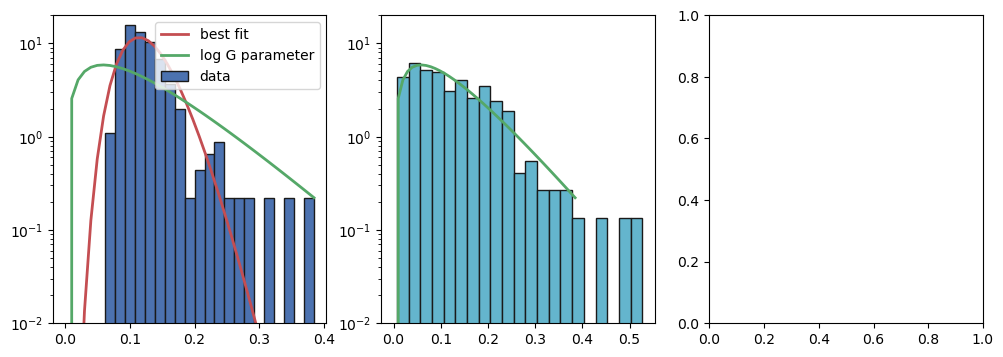

In [219]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
n_bins=21

histogram, bins = np.histogram(emp, bins=n_bins, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
xvalues=np.linspace(0,bins[-1], 40)
ax1.hist(emp, bins=n_bins, density=True,facecolor='b', edgecolor='k',label=
        'data')
ax1.plot(xvalues, scipy.stats.gamma.pdf(xvalues, a_true,
                                           loc=0, scale= scale_true),
         'r-',lw=2,label='best fit') 
ax1.plot(xvalues, scipy.stats.gamma.pdf(xvalues, a_guess,
                                           loc=0, scale= scale_gamma_fit),
         'g-',lw=2,label='log G parameter')
ax2.hist(rnd_sample,bins=n_bins, density=True,facecolor='c', edgecolor='k',label=
        'sample')

ax2.plot(xvalues, scipy.stats.gamma.pdf(xvalues, a_guess,
                                           loc=0, scale= scale_gamma_fit),
         'g-',lw=2,label='log G parameter')

ax1.legend(loc='best')

for ax in [ax1,ax2]:
#     ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-2,20 )
# ax1.plot(xvalues, scipy.stats.gamma.pdf(xvalues, a_guess,
#                                            loc=0, scale= scale_gamma_fit),
#          'g-',lw=2,label='log G parameter')


plt.show()


In [204]:
len(rnd_sample)

298

In [ ]:
lkhd_sample=scipy.stats.gamma.pdf(xvalues, a_guess,
                                           loc=0, scale= scale_gamma_fit)

In [210]:
lkhd_sample=np.product(scipy.stats.gamma.pdf(rnd_sample, a_guess,
                        loc=0, scale= scale_gamma_fit))
print (lkhd_sample)

1.5502025475281135e+154


355.03648991930146
417.64943756075513


In [214]:
print (np.min(np.log(scipy.stats.gamma.pdf(rnd_sample, a_guess,
                        loc=0, scale= scale_gamma_fit))), np.max(np.log(scipy.stats.gamma.pdf(rnd_sample, a_guess,
                        loc=0, scale= scale_gamma_fit))))

-3.3803843907285507 1.7706696605929075


# plotting parameters m, D, m tau, etc.

In [2]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'

microbe_params={}
Delta_t=1
with open(combined_params_path+'microbe_logG_fitvals.pkl', 'rb') as handle:
    microbe_fit_vals_logG = pickle.load(handle)
microbe_params.update({'m/D_logG':np.array(microbe_fit_vals_logG['bd_fit'])})
microbe_params.update({'tau_logG':1./np.array(microbe_fit_vals_logG['tp_fit'])})
with open(combined_params_path+'microbe_AFD_shape_error_estimates.pkl', 'rb') as handle:
    microbe_fit_vals_AFD = pickle.load(handle)
microbe_params.update({'m/D_AFD':np.array(microbe_fit_vals_AFD['a_gamma_true'])})
microbe_params.update({'Dtau_AFD':np.array(microbe_fit_vals_AFD['scale_gamma_true'])})
assert len(microbe_params['m/D_AFD'])==len(microbe_params['m/D_logG'])
gm=np.exp((np.log(microbe_params['m/D_AFD'])+np.log(microbe_params['m/D_logG']))/2)
microbe_params.update({'m/D_GeomMean':gm})

microbe_params.update(
    {'m_i': microbe_params['m/D_GeomMean']*microbe_params['Dtau_AFD']/microbe_params['tau_logG'] })
microbe_params.update(
    {'D_i': microbe_params['m_i']/microbe_params['m/D_GeomMean']})


# with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_logG = pickle.load(handle)
# BCI_logG_shape=BCI_fit_vals_logG ['m/D_logG']
# BCI_AFD_atlogG_params={'m/D':BCI_logG_shape}

# Delta_t=12
# with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     city_AFD_atlogG_params = pickle.load(handle)
# city_logG_shape= np.array(city_fit_vals_logG['NeutralTheory'])[:,1]
# city_AFD_atlogG_params={'m/D':city_logG_shape}

In [3]:
BCI_params={}
with open(combined_params_path+'BCI_logG_fitvals.pkl', 'rb') as handle:
    BCI_fit_vals_logG = pickle.load(handle)
BCI_params.update({'m/D_logG':np.array(BCI_fit_vals_logG['bd_fit'])})
BCI_params.update({'tau_logG':1./np.array(BCI_fit_vals_logG['tp_fit'])})
with open(combined_params_path+'BCI_AFD_shape_error_estimates.pkl', 'rb') as handle:
    BCI_fit_vals_AFD = pickle.load(handle)
BCI_params.update({'m/D_AFD':np.array(BCI_fit_vals_AFD['a_gamma_true'])})
BCI_params.update({'Dtau_AFD':np.array(BCI_fit_vals_AFD['scale_gamma_true'])})
assert len(BCI_params['m/D_AFD'])==len(BCI_params['m/D_logG'])
gm=np.exp((np.log(BCI_params['m/D_AFD'])+np.log(BCI_params['m/D_logG']))/2)
BCI_params.update({'m/D_GeomMean':gm})

BCI_params.update(
    {'m_i': BCI_params['m/D_GeomMean']*BCI_params['Dtau_AFD']/BCI_params['tau_logG'] })
BCI_params.update(
    {'D_i': BCI_params['m_i']/BCI_params['m/D_GeomMean']})

OSError: [Errno 5] Input/output error

In [4]:
city_params={}
with open(combined_params_path+'city_logG_fitvals.pkl', 'rb') as handle:
    city_fit_vals_logG = pickle.load(handle)
city_params.update({'m/D_logG':np.array(city_fit_vals_logG['bd_fit'])})
city_params.update({'tau_logG':1./np.array(city_fit_vals_logG['tp_fit'])})
with open(combined_params_path+'city_AFD_shape_error_estimates.pkl', 'rb') as handle:
    city_fit_vals_AFD = pickle.load(handle)
city_params.update({'m/D_AFD':np.array(city_fit_vals_AFD['a_gamma_true'])})
city_params.update({'Dtau_AFD':np.array(city_fit_vals_AFD['scale_gamma_true'])})
assert len(city_params['m/D_AFD'])==len(city_params['m/D_logG'])
gm=np.exp((np.log(city_params['m/D_AFD'])+np.log(city_params['m/D_logG']))/2)
city_params.update({'m/D_GeomMean':gm})

city_params.update(
    {'m_i': city_params['m/D_GeomMean']*city_params['Dtau_AFD']/city_params['tau_logG'] })
city_params.update(
    {'D_i': city_params['m_i']/city_params['m/D_GeomMean']})

microbe m/D CV, 4.2e-01,  std_log=4.8e-01
city m/D CV, 6.7e-01,  std_log=6.3e-01


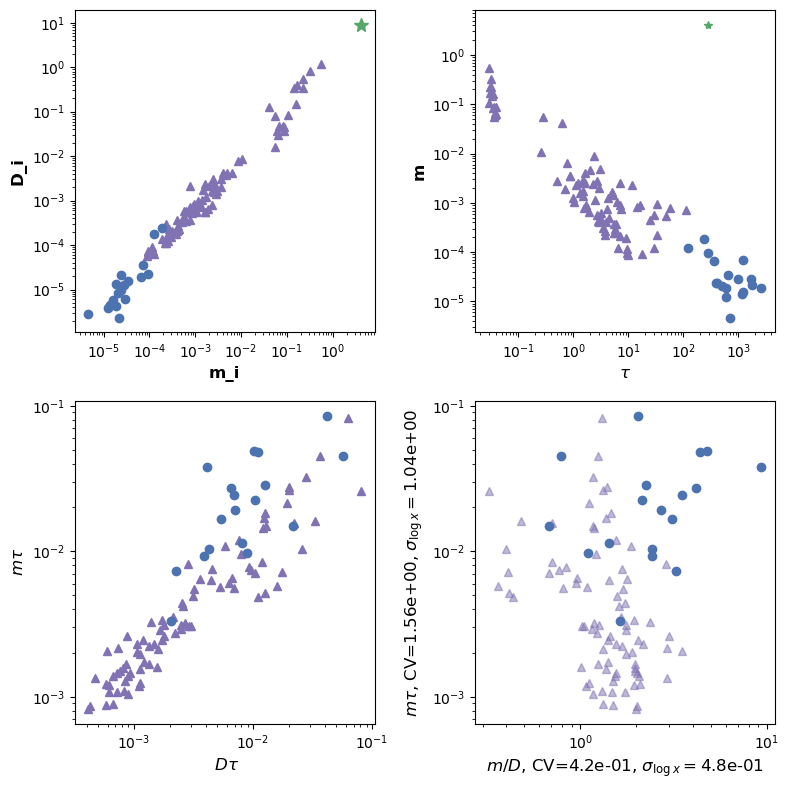

In [24]:
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2,2,1)



ax1.plot(microbe_params['m_i'],microbe_params['D_i'],'m^')
ax1.plot(city_params['m_i'],city_params['D_i'],'bo')
ax1.plot(BCI_params['m_i'],BCI_params['D_i'],'g*',ms=10)

ax1.set_xlabel('m_i')

ax1.set_ylabel('D_i')
ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_ylim(1e-1, 10)

ax2 = fig2.add_subplot(2,2,2)
ax2.loglog(microbe_params['tau_logG'],microbe_params['m_i'],'m^',label='microbe')
ax2.loglog(city_params['tau_logG'],city_params['m_i'],'bo',label='urban')
ax2.loglog(BCI_params['tau_logG'],BCI_params['m_i'],'g*',label='forest')
# ax2.legend(loc=3)
ax2.set_ylabel(r'm')
ax2.set_xlabel(r'$\tau$')



ax3 = fig2.add_subplot(2,2,3)
ax3.loglog(microbe_params['tau_logG']*microbe_params['D_i'],microbe_params['m_i']*microbe_params['tau_logG'],'m^',label='microbe')
ax3.loglog(city_params['tau_logG']*city_params['D_i'],city_params['m_i']*city_params['tau_logG'],'bo',label='urban')
# ax3.loglog(BCI_params['tau_logG']*BCI_params['D_i'],BCI_params['m_i']*BCI_params['tau_logG'],'g*',label='forest')

ax3.set_ylabel(r'$m \tau$')
ax3.set_xlabel(r' $D \tau$')

ax4 = fig2.add_subplot(2,2,4)
ax4.loglog(microbe_params['m_i']/microbe_params['D_i'],microbe_params['m_i']*microbe_params['tau_logG'],'m^',label='microbe',alpha=.5)
ax4.loglog(city_params['m_i']/city_params['D_i'],city_params['m_i']*city_params['tau_logG'],'bo',label='urban')
# ax3.loglog(BCI_params['tau_logG']*BCI_params['D_i'],BCI_params['m_i']*BCI_params['tau_logG'],'g*',label='forest')


temp=microbe_params['m_i']*microbe_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
ax4.set_ylabel(r'$m \tau$, CV={:.2e}'.format(cv)+ r', $\sigma_{\log x}=$'+ '{:.2e}'.format(std_log), fontweight='normal' )
m_ov_D=microbe_params['m_i']/microbe_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
ax4.set_xlabel(r'$m/D$, CV={:.1e}'.format(cv) +r', $\sigma_{\log x}=$'+ '{:.1e}'.format(std_log), fontweight='normal' )

 

m_ov_D=microbe_params['m_i']/microbe_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
print('microbe m/D CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))


m_ov_D=city_params['m_i']/city_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
print('city m/D CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

fig2.tight_layout()

plt.savefig(dest_path+'params_scatterplots.png')
plt.show()

## compare variability of different parameters for taylor's law
Microbe data shows a separation of scales in the variability of m/D versus other parameters. This serves to explain temporal Taylor's law

In [5]:
m_ov_D=microbe_params['m_i']/microbe_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
print('microbe m/D CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['m_i']*microbe_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe m tau CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['D_i']*microbe_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe D tau CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['m_i']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe m CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['D_i']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe D  CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe tau  CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))


m_ov_D=city_params['m_i']/city_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
print('city m/D CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=city_params['m_i']*city_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('city mtau CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))


temp=city_params['m_i']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('city m CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=city_params['D_i']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('city D  CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))



temp=city_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('city tau  CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))


microbe m/D CV, 4.2e-01,  std_log=4.8e-01
microbe m tau CV, 1.6e+00,  std_log=1.0e+00
microbe D tau CV, 1.7e+00,  std_log=1.3e+00
microbe m CV, 2.6e+00,  std_log=2.2e+00
microbe D  CV, 3.3e+00,  std_log=2.5e+00
microbe tau  CV, 2.1e+00,  std_log=2.1e+00
city m/D CV, 6.7e-01,  std_log=6.3e-01
city mtau CV, 7.7e-01,  std_log=7.9e-01
city m CV, 1.0e+00,  std_log=8.9e-01
city D  CV, 1.9e+00,  std_log=1.2e+00
city tau  CV, 7.3e-01,  std_log=7.7e-01


# robustness analysis: fitting different time intervals
- fit for different sampling intervals, Delta t, and see how parameters change. 
- What happens if you constrain shape parameter to gamma dist value?

In [67]:
###function to plot results.
def plot_rescaled_Dt_plots(sys_logG_Dt_params, sp_key='sp',show_legend=False):
    Delta_T_list=np.sort(list(set(sys_logG_Dt_params['DeltaT'])))
    if sp_key=='sp':
        sp_list=np.sort(list(set(sys_logG_Dt_params[sp_key])))
    else:
        sp_list=list(set(sys_logG_Dt_params[sp_key]))

    fig2 = plt.figure(figsize=(8, 8))
    ax1 = fig2.add_subplot(2,2,1)
    ax3 = fig2.add_subplot(2,2,3)
    ax4 = fig2.add_subplot(2,2,4)
    ax2 = fig2.add_subplot(2,2,2)
    for sp in sp_list:
        t_over_tau_inferred_list=[]
        bd_inferred_list=[]
        idx_sp=np.where(np.asarray(sys_logG_Dt_params[sp_key])==sp)[0]
        for Dt in Delta_T_list:
            idx_Dt=np.where(np.asarray(sys_logG_Dt_params['DeltaT'])==Dt)[0]

            
            idx=int(np.intersect1d(idx_Dt,idx_sp))
            t_over_tau_inferred_list.append(sys_logG_Dt_params['tp_fit'][idx])
            bd_inferred_list.append(sys_logG_Dt_params['bd_fit'][idx])


        ax1.plot(Delta_T_list,t_over_tau_inferred_list, label=str(sp))
        ax2.plot(Delta_T_list,bd_inferred_list, label=str(sp))
        ax3.plot(Delta_T_list,t_over_tau_inferred_list, label=str(sp))
        ax4.plot(Delta_T_list,np.asarray(t_over_tau_inferred_list)*1./np.asarray(Delta_T_list), label=str(sp)) 
        

    if show_legend:
        ax1.legend(loc=2, ncol=2)
        
    
    ax1.set_xlabel(r'time interval $\Delta t$')
    ax1.set_ylabel(r'inferred parameter $[\Delta t/\tau]^{\dag}$')


    ax3.set_xlabel(r'time interval $\Delta t$')
    ax3.set_ylabel(r'inferred parameter $[\Delta t/\tau]^{\dag}$')

    ax4.set_xlabel(r'time interval $\Delta t$')
    ax4.set_ylabel(r'rescaled inferred parameter $ (1/ \Delta t) \times [\Delta t/\tau]^{\dag}  $  ')

    ax4.set_xscale('log')
    ax4.set_yscale('log')
    
    ax3.set_yscale('log')
    ax3.set_xscale('log')
    if sp_key=='sp':
        ax4.set_ylim(1e-3,1e2)
        ax3.set_ylim(1e-3,1e2)
    
    ax2.set_xlabel(r'time interval $\Delta t$')
    ax2.set_ylabel(r'inferred parameter, $ENR=x^*/(\sigma \tau)$')

    fig2.tight_layout()
    # plt.savefig(dest_path+'test.png')
    plt.show()


## microbes

In [57]:
##fit to obtain parameters
neutral_inst = shared_func.azaele_neutral_logG_distribution()
microbe_logG_params={'sp':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[],
                    'DeltaT':[]}
microbe_logG_atAFD_params={'sp':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[],
                    'DeltaT':[]}
with open(combined_params_path+'microbe_AFD_shape_error_estimates.pkl', 'rb') as handle:
    microbe_err_bars_dict=pickle.load(handle)  

time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]


Dt_list=[1,2,4,8,12,16,20,24,28,32,36,40,44,48]
for Dt in Dt_list:
    idx_1_list=[]
    idx_2_list=[]
    for j,t2 in enumerate(time_points):
        if np.any(time_points==t2-Dt):
            i=int(np.where(time_points==t2-Dt)[0])
            t1=time_points[i]
    #         print (i,j, t1, t2)
            idx_1_list.append(i)
            idx_2_list.append(j)
    idxs_1=np.array(idx_1_list)
    idxs_2=np.array(idx_2_list)

    # sp_list=[3,10,39]#,39]
    sp_list=np.arange(len(rel_abu_mat))

    for i,sp in enumerate(microbe_err_bars_dict['sp']):
        otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
        otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
        idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
        growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
        logG=np.log(growth_rates)

        neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
                logG,10., 1., floc=0,fscale=1.)
        
    
        ll=neutral_inst.logpdf(logG,  neut_tp, neut_bd, loc=0,scale=1.)
        microbe_logG_params['sp'].append(sp)
        microbe_logG_params['DeltaT'].append(Dt)
        microbe_logG_params['tp_fit'].append(neut_tp)
        microbe_logG_params['bd_fit'].append(neut_bd)
        microbe_logG_params['data_length'].append(len(logG))
        microbe_logG_params['logLk'].append(np.sum(ll) )
        
        neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., fbd=microbe_err_bars_dict['a_gamma_true'][i], floc=0,fscale=1.)
        ll=neutral_inst.logpdf(logG,  neut_tp, neut_bd, loc=0,scale=1.)
        microbe_logG_atAFD_params['sp'].append(sp)
        microbe_logG_atAFD_params['DeltaT'].append(Dt)
        microbe_logG_atAFD_params['tp_fit'].append(neut_tp)
        microbe_logG_atAFD_params['bd_fit'].append(neut_bd)
        microbe_logG_atAFD_params['data_length'].append(len(logG))
        microbe_logG_atAFD_params['logLk'].append(np.sum(ll) )        
        
        
with open(combined_params_path+'microbe_logG_fitvals_vary_Dt.pkl', 'wb') as handle:
    pickle.dump(microbe_logG_params, handle,protocol=4)  
with open(combined_params_path+'microbe_logG_atAFD_fitvals_vary_Dt.pkl', 'wb') as handle:
    pickle.dump(microbe_logG_atAFD_params, handle,protocol=4)  

/Users/ashish/Dropbox/research/James-research/city establishment data/shared_analysis_functions.py:113: RuntimeWarning: divide by zero encountered in log
  return (2*bd-1)*math.log(2)-math.log(math.pi)/2 + scipy.special.gammaln(bd+1./2)-scipy.special.gammaln(bd) +np.log(l+1)+ bd*r +bd*np.log(q-1) + tp/2. - (bd+1./2) * np.log(
/Users/ashish/Dropbox/research/James-research/city establishment data/shared_analysis_functions.py:114: RuntimeWarning: divide by zero encountered in log
  np.square(l+1)*q-4*l)
/Users/ashish/Dropbox/research/James-research/city establishment data/shared_analysis_functions.py:114: RuntimeWarning: invalid value encountered in subtract
  np.square(l+1)*q-4*l)


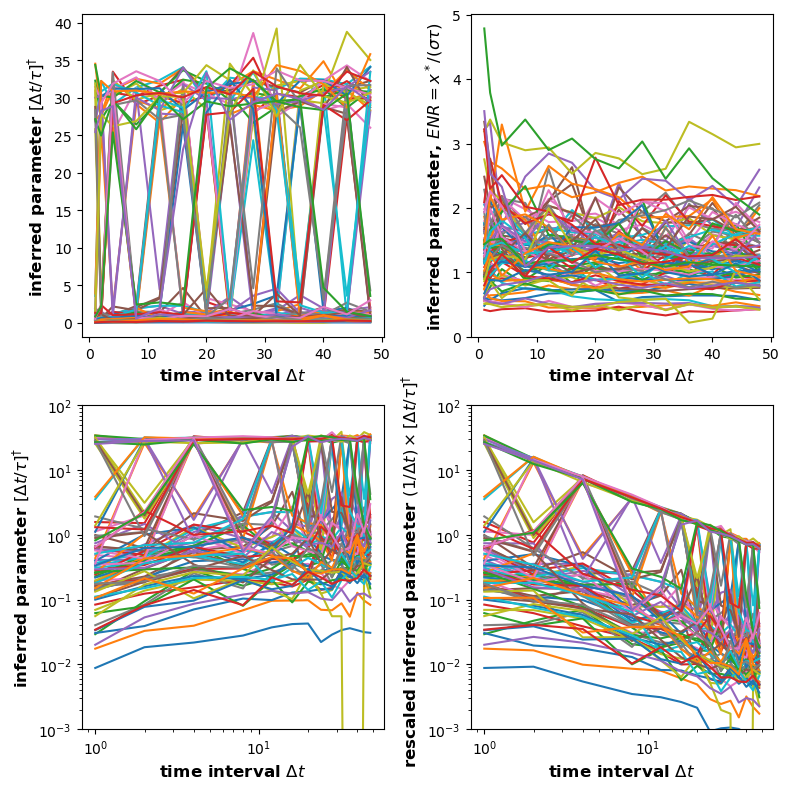

at AFD parameters


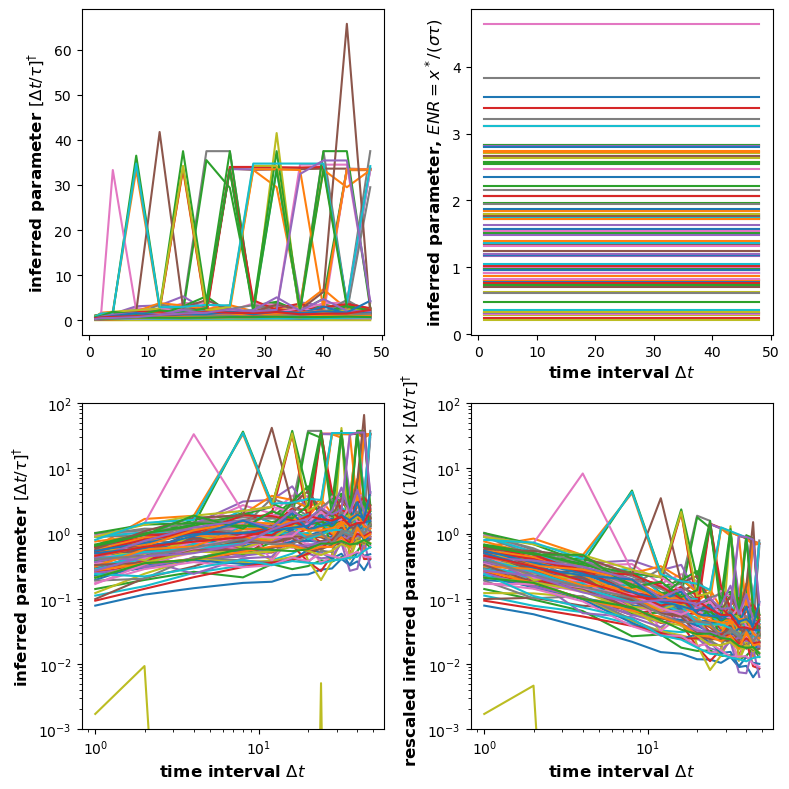

In [65]:
with open(combined_params_path+'microbe_logG_fitvals_vary_Dt.pkl', 'rb') as handle:
    microbe_logG_Dt_params=pickle.load(handle)    
plot_rescaled_Dt_plots(microbe_logG_Dt_params, sp_key='sp')
print('at AFD parameters')
with open(combined_params_path+'microbe_logG_atAFD_fitvals_vary_Dt.pkl', 'rb') as handle:
    microbe_logG_atAFD_Dt_params=pickle.load(handle)    
plot_rescaled_Dt_plots(microbe_logG_atAFD_Dt_params, sp_key='sp')

### investigate up-down behavior of some microbes

In [106]:
with open(combined_params_path+'microbe_logG_fitvals_vary_Dt.pkl', 'rb') as handle:
    microbe_logG_fitvals_vary_Dt=pickle.load(handle) 
df_microbe_logG_fitvals_vary_Dt= pd.DataFrame.from_dict(microbe_logG_fitvals_vary_Dt)

tpvals=df_microbe_logG_fitvals_vary_Dt[df_microbe_logG_fitvals_vary_Dt['DeltaT']==1]['tp_fit'].values
np.max(tpvals), np.min(tpvals)

(34.52855266098192, 0.008802385761323396)

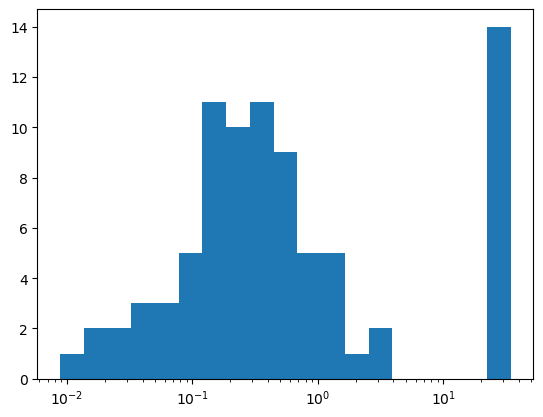

In [93]:
plt.hist(tpvals,
        bins=np.logspace(np.log10(np.min(tpvals)),np.log10(np.max(tpvals)), 20))
plt.xscale('log')
plt.show()

##### AT AFD params

In [105]:
with open(combined_params_path+'microbe_logG_atAFD_fitvals_vary_Dt.pkl', 'rb') as handle:
    microbe_logG_atAFD_Dt_params=pickle.load(handle) 
df_microbe_logG_atAFD_Dt= pd.DataFrame.from_dict(microbe_logG_atAFD_Dt_params)
df_microbe_logG_atAFD_Dt

,sp,tp_fit,bd_fit,data_length,logLk,DeltaT
0,0,0.537109,3.544404,277,-378.802691,1
1,1,0.429321,2.740978,275,-328.030423,1
2,2,0.418274,2.219299,273,-327.310393,1
3,3,0.320251,2.066063,273,-300.919034,1
4,4,0.215759,0.919846,241,-332.122042,1
...,...,...,...,...,...,...
1185,80,4.308655,2.793279,237,-362.543678,48
1186,81,0.972900,1.721584,225,-341.011696,48
1187,82,0.695129,0.731551,211,-410.385045,48
1188,83,2.287903,3.375471,235,-305.037930,48


1.0216064453125 0.001708984375


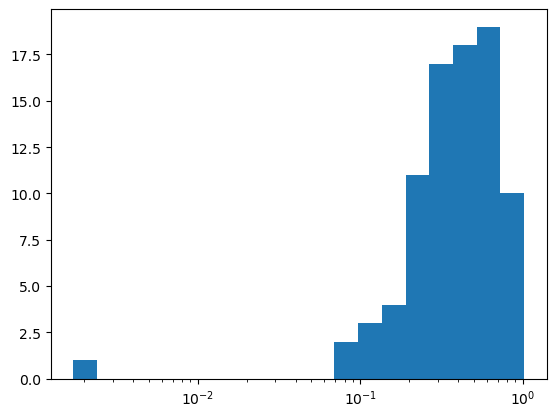

In [97]:
tpvals=df_microbe_logG_atAFD_Dt[df_microbe_logG_atAFD_Dt['DeltaT']==1]['tp_fit'].values
print(np.max(tpvals), np.min(tpvals))
plt.hist(tpvals,
        bins=np.logspace(np.log10(np.min(tpvals)),np.log10(np.max(tpvals)), 20))
plt.xscale('log')
plt.show()

#### Investigating one of the species that have these funky oscillations.

In [130]:
df_microbe_logG_atAFD_Dt[df_microbe_logG_atAFD_Dt['tp_fit']>10]
DT_vals=np.unique(df_microbe_logG_atAFD_Dt['DeltaT'].values)

In [128]:
df_microbe_logG_atAFD_Dt[df_microbe_logG_atAFD_Dt['tp_fit']>10]['sp'].values

array([56, 21, 42, 69, 65, 21, 23, 52, 68,  7, 22,  2,  7, 15, 22, 23, 34,
       52, 63, 72, 15, 21, 23, 34, 61, 68, 69, 15, 21, 23, 34, 48, 49, 52,
       61, 68, 69, 72,  6, 15, 23, 61, 69, 84,  6,  7, 15, 21, 23, 52, 69,
       72, 84,  1,  2,  6, 15, 21, 35, 36, 52, 61, 65, 84,  1,  2,  7,  9,
       15, 21, 34, 35, 36, 47, 56, 61, 69])

In [133]:
df_microbe_logG_atAFD_Dt[df_microbe_logG_atAFD_Dt['sp']==52]

,sp,tp_fit,bd_fit,data_length,logLk,DeltaT
52,52,0.677368,2.576145,271,-303.576182,1
137,52,1.003296,2.576145,267,-325.259308,2
222,52,1.312622,2.576145,262,-332.330742,4
307,52,1.959778,2.576145,251,-333.432784,8
392,52,2.555603,2.576145,254,-350.638259,12
477,52,37.500000,2.576145,247,-361.112160,16
562,52,4.092712,2.576145,244,-346.731390,20
647,52,37.500000,2.576145,243,-351.768935,24
732,52,2.888611,2.576145,243,-333.257649,28
817,52,37.500000,2.576145,238,-350.441251,32


##### for species 56

2.474408 0.9114990234375
2.474408 1.42218017578125
2.474408 33.6171875
2.474408 2.1463623046875
2.474408 2.58551025390625
2.474408 2.13006591796875


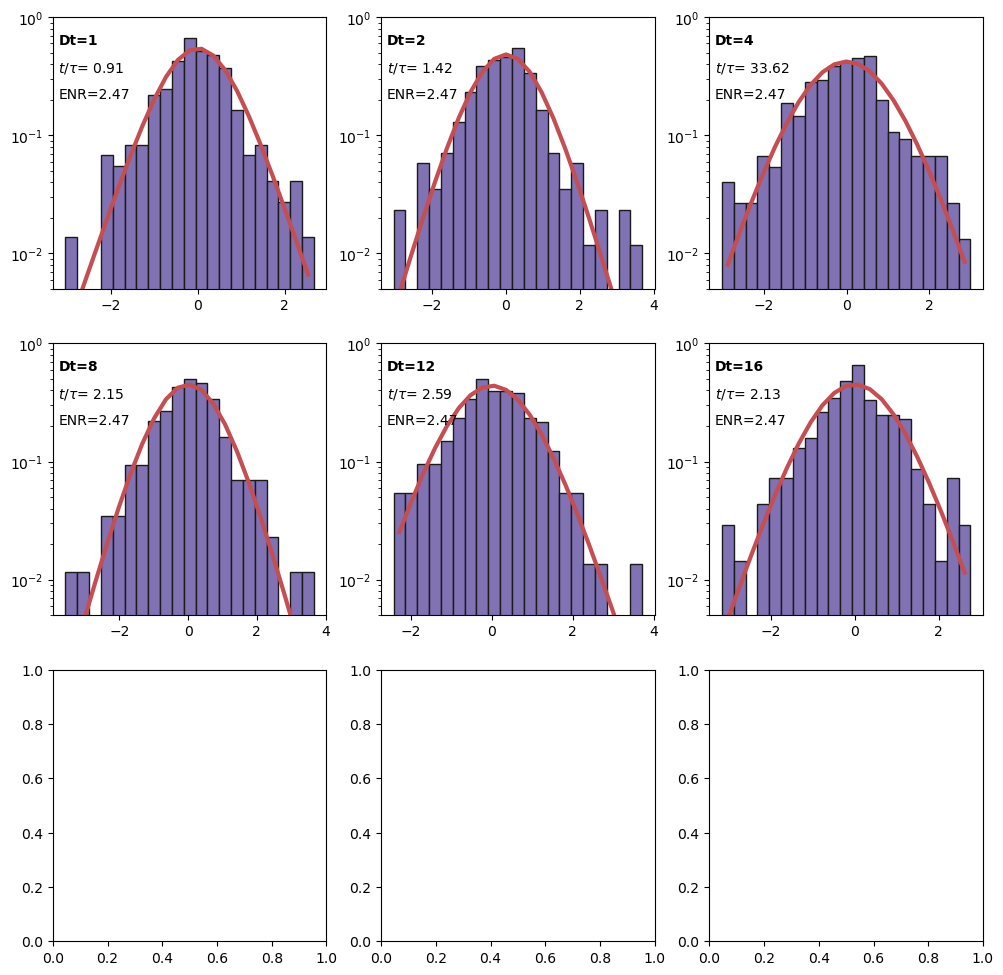

In [125]:
sp=56
bd_fixed=2.474408
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

ax_list=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]




genus_names_full=caporaso['gtax']
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)

rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]



for idx,Dt in enumerate(DT_vals):
    ax=ax_list[idx]
    
    idx_1_list=[]
    idx_2_list=[]
    for j,t2 in enumerate(time_points):
        if np.any(time_points==t2-Dt):
            i=int(np.where(time_points==t2-Dt)[0])
            t1=time_points[i]
    #         print (i,j, t1, t2)
            idx_1_list.append(i)
            idx_2_list.append(j)
    idxs_1=np.array(idx_1_list)
    idxs_2=np.array(idx_2_list)
    
    
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
    n_bins=21
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., fbd=bd_fixed, floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(logG,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
    histogram, bins = np.histogram(logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
    
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
            ,'r-',lw=3,label=r'$P_{fluc}$') 
    
    print (neut_bd, neut_tp)
    ax.text(.02,.9,'Dt='+str(int(Dt)),fontweight="bold",
            transform=ax.transAxes)
    ax.text(.02,.8,r'$t/\tau$= {:.2f}'.format(neut_tp),transform=ax.transAxes)
    ax.text(.02,.7,r'ENR={:.2f}'.format(neut_bd),transform=ax.transAxes)
    
    ax.set_yscale('log')
    ax.set_ylim(5e-3,1)
    if idx>=5:
        break
        
    
plt.show()


##### for species 52

2.576145 0.6773681640625
2.576145 1.0032958984375
2.576145 1.3126220703125
2.576145 1.95977783203125
2.576145 2.55560302734375
2.576145 34.328125
2.576145 4.09271240234375
2.576145 29.49853515625
2.576145 2.88861083984375


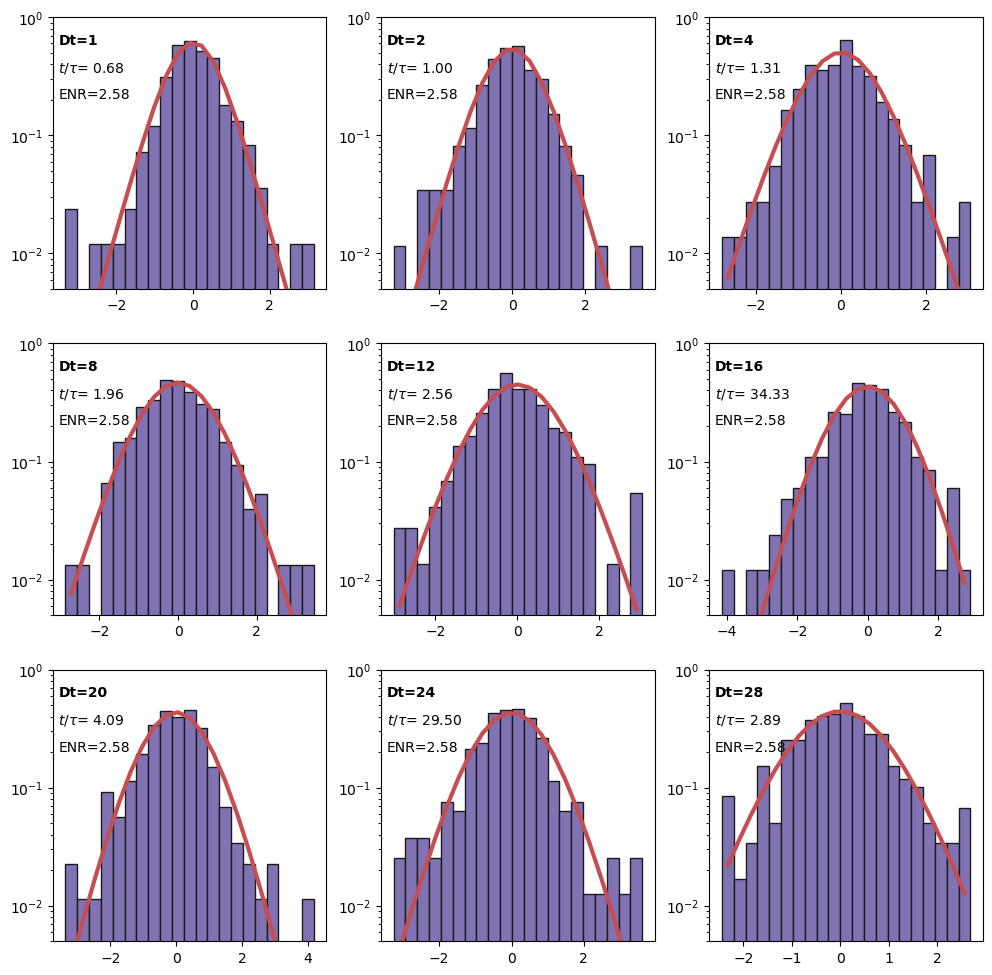

In [134]:
sp=52
bd_fixed=2.576145	
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

ax_list=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]




genus_names_full=caporaso['gtax']
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)

rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]



for idx,Dt in enumerate(DT_vals):
    ax=ax_list[idx]
    
    idx_1_list=[]
    idx_2_list=[]
    for j,t2 in enumerate(time_points):
        if np.any(time_points==t2-Dt):
            i=int(np.where(time_points==t2-Dt)[0])
            t1=time_points[i]
    #         print (i,j, t1, t2)
            idx_1_list.append(i)
            idx_2_list.append(j)
    idxs_1=np.array(idx_1_list)
    idxs_2=np.array(idx_2_list)
    
    
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
    n_bins=21
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., fbd=bd_fixed, floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(logG,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
    histogram, bins = np.histogram(logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
    
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
            ,'r-',lw=3,label=r'$P_{fluc}$') 
    
    print (neut_bd, neut_tp)
    ax.text(.02,.9,'Dt='+str(int(Dt)),fontweight="bold",
            transform=ax.transAxes)
    ax.text(.02,.8,r'$t/\tau$= {:.2f}'.format(neut_tp),transform=ax.transAxes)
    ax.text(.02,.7,r'ENR={:.2f}'.format(neut_bd),transform=ax.transAxes)
    
    ax.set_yscale('log')
    ax.set_ylim(5e-3,1)
    if idx>=8:
        break
        
    
plt.show()


## LFD stiff when dt/tau >~1
this stiffness of the LFD means that fits of the microbiome become less robust quickly.

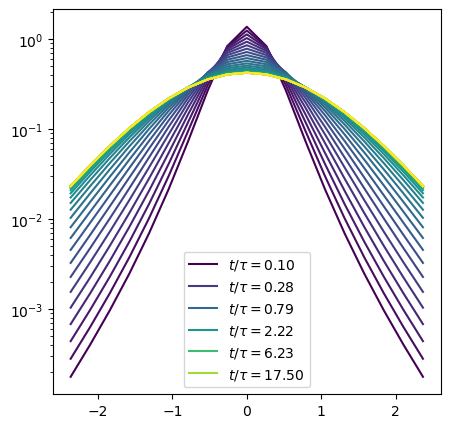

In [157]:
import matplotlib.pylab as pylab
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()


bins=np.linspace(-2.5,2.5,20)
bin_centers = 0.5*(bins[1:] + bins[:-1])

bd_val=2.5

# np.logspace(np.log(1e-2),np.log(1e2),20)
tp_arr=np.logspace(np.log10(1e-1),np.log10(4e1),30)

color_list = pylab.cm.viridis(np.linspace(0,1,len(tp_arr)))
for i, tp in enumerate(tp_arr):
    if i%5==0:
        ax.plot(bin_centers,neutral_inst.pdf(bin_centers, tp, bd_val, loc=0,scale= 1),
                                 '-',color=color_list[i], label=r'$t/\tau=$'+'{:.2f}'.format(tp))
    else:
        ax.plot(bin_centers,neutral_inst.pdf(bin_centers, tp, bd_val, loc=0,scale= 1),
                                 '-',color=color_list[i])
    ax.legend(loc='best') 
    ax.set_yscale('log')
plt.show()

## cities

In [59]:
##fit params
with open(combined_params_path+'city_AFD_shape_error_estimates.pkl', 'rb') as handle:
    city_err_bars_dict=pickle.load(handle) 
neutral_inst = shared_func.azaele_neutral_logG_distribution()
city_logG_params={'naics':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[],
                 'DeltaT':[]}
city_logG_atAFD_params={'naics':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[],
                 'DeltaT':[]}
naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')

Dt_list=[1,2,3,4,5,6,7,8]
for Dt in Dt_list:
    for i,naics in enumerate(naics_keys_to_plot):
        logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                           time_stamps_likeCBP_list,tau=12*Dt)
        emp_logG=np.ravel(logratio_list)
        neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
                emp_logG,10., 1., floc=0,fscale=1.)
        ll=neutral_inst.logpdf(emp_logG,  neut_tp, neut_bd, loc=0,scale=1.)
        city_logG_params['naics'].append(naics)
        city_logG_params['DeltaT'].append(Dt)
        city_logG_params['tp_fit'].append(neut_tp)
        city_logG_params['bd_fit'].append(neut_bd)
        city_logG_params['data_length'].append(len(emp_logG))
        city_logG_params['logLk'].append(np.sum(ll)) 
        
        neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            emp_logG,10., fbd=city_err_bars_dict['a_gamma_true'][i], floc=0,fscale=1.)
        ll=neutral_inst.logpdf(emp_logG,  neut_tp, neut_bd, loc=0,scale=1.)
        city_logG_atAFD_params['naics'].append(naics)
        city_logG_atAFD_params['DeltaT'].append(Dt)
        city_logG_atAFD_params['tp_fit'].append(neut_tp)
        city_logG_atAFD_params['bd_fit'].append(neut_bd)
        city_logG_atAFD_params['data_length'].append(len(emp_logG))
        city_logG_atAFD_params['logLk'].append(np.sum(ll)) 
        
with open(combined_params_path+'city_logG_fitvals_vary_Dt.pkl', 'wb') as handle:
    pickle.dump(city_logG_params, handle,protocol=4)  
with open(combined_params_path+'city_logG_atAFD_fitvals_vary_Dt.pkl', 'wb') as handle:
    pickle.dump(city_logG_atAFD_params, handle,protocol=4)  

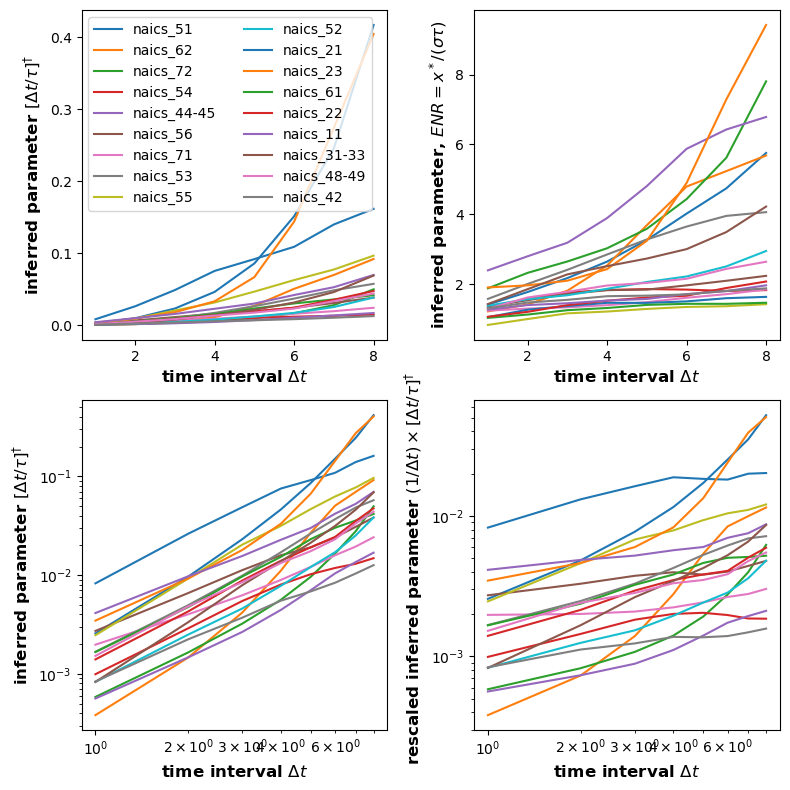

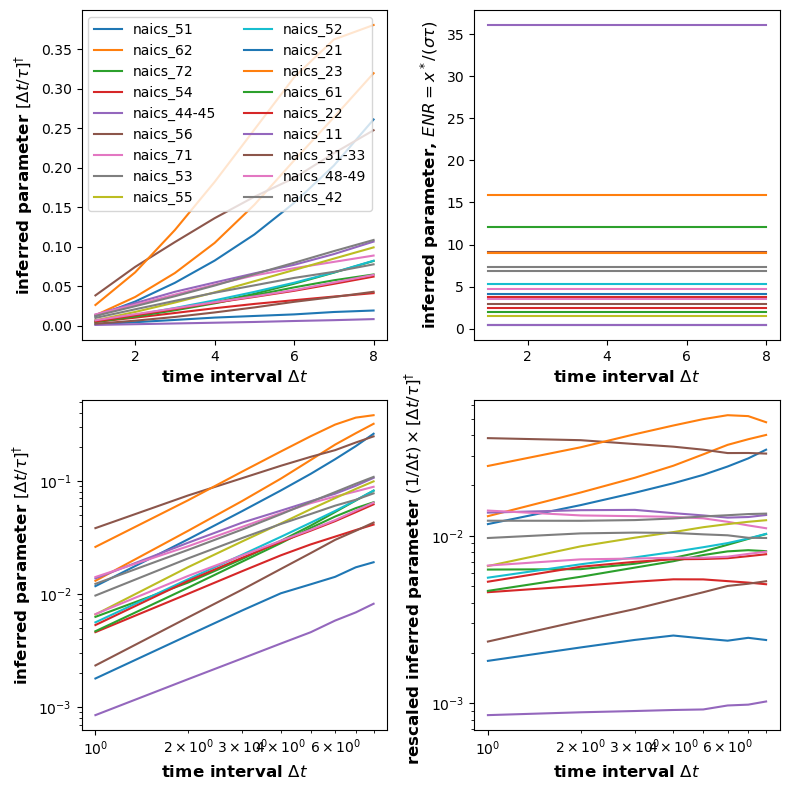

at AFD parameters.


In [69]:
with open(combined_params_path+'city_logG_fitvals_vary_Dt.pkl', 'rb') as handle:
    city_logG_Dt_params=pickle.load(handle)    
plot_rescaled_Dt_plots(city_logG_Dt_params, sp_key='naics',show_legend=True)

with open(combined_params_path+'city_logG_atAFD_fitvals_vary_Dt.pkl', 'rb') as handle:
    city_logG_atAFD_Dt_params=pickle.load(handle)    
plot_rescaled_Dt_plots(city_logG_atAFD_Dt_params, sp_key='naics',show_legend=True)
print ('at AFD parameters.')

In [50]:
np.where(np.array(city_logG_Dt_params['naics'])=='naics_22')

(array([ 2,  6, 10, 14, 18]),)

In [ ]:
idx_sp=np.where(city_logG_Dt_params[sp_key]==sp)[0]

In [15]:
t_over_tau_inferred_list

[0.08386793797328401,
 0.030509709260431023,
 0.31189614513891684,
 0.1237790990323212,
 0.03910363028932184,
 0.3704151590680098,
 0.1210602843230415,
 0.06451702923415742,
 0.407819349293025,
 0.15492707287476898,
 0.07063598279601815,
 0.4802386276270454,
 0.11903252707873163,
 0.06428210350211008,
 0.4426825830230099]

# Comparing fits of forest clusters

see if parameters of one forest cluster fit can provide an acceptable fit to another forest cluster


## log G

In [32]:
# ## takes time to run.so used saved data if possible
# neutral_inst = shared_func.azaele_neutral_logG_distribution()
# with open(combined_params_path+'BCI_rel_logG_clustfitvals.pkl', 'rb') as handle:
#     BCI_rel_clust_err_bars_dict=pickle.load(handle) 
    
# BCI_rel_clust_pwise_compare_LFD_dict={'height_cluster1':[], 'height_cluster2':[],
#    'tp1':[],'tp2':[],
#     'bd1':[], 'bd2':[],
#     'll_of_data2_at_params1':[],
#     'pctile_score_of_data2_at_params1_ll':[],
#     'pctile_score_of_data2_at_params1_jsd':[]                                     
# }
# for i in range(4):
#     clust_id1=i+1
#     for j in range(4):
#         clust_id2=j+1        
#         if i!=j: ## only then we compare.     
#             BCI_logG_clust_j=get_BCI_clust_logG(df_BCI_rel_clust,clust_id2)


#             tp1=BCI_rel_clust_err_bars_dict['tp_fit'][i]
#             bd1=BCI_rel_clust_err_bars_dict['bd_fit'][i]
#             tp2=BCI_rel_clust_err_bars_dict['tp_fit'][j]
#             bd2=BCI_rel_clust_err_bars_dict['bd_fit'][j]
                 
#             log_lik_data2_at_params1=np.sum(neutral_inst.logpdf(
#                 BCI_logG_clust_j, tp1, bd1, loc=0,scale=1.) )
            
#             data_bins=np.histogram_bin_edges(BCI_logG_clust_j, bins='fd') 
#             data_bin_centers = 0.5*(data_bins[1:] + data_bins[:-1])
#             data_hist, bins = np.histogram(BCI_logG_clust_j, bins=data_bins, density=True)
            
#             LFD_hist1= neutral_inst.pdf(data_bin_centers, tp1, bd1, loc=0,scale=1.)
#             JSD_data2_lfd1=scipy_spatial_distance.jensenshannon(
#                 data_hist,LFD_hist1)
                        
#             JSD_sim_list=[]
#             logLik_sim_list=[]
#             for k in range(100):
                
#                 rnd_sample=neutral_inst.rvs(tp1, bd1, loc=0,scale=1.,
#                                                  size=len(BCI_logG_clust_j))
#                 temp=neutral_inst.logpdf(rnd_sample, tp1, bd1, loc=0,scale=1.)
#                 logLik_sim_list.append(np.sum(temp) )  
#                 sample_bins=np.histogram_bin_edges(rnd_sample, bins='fd') 
#                 sample_bin_centers = 0.5*(sample_bins[1:] + sample_bins[:-1])
#                 samples_hist,bins= np.histogram(rnd_sample, bins=sample_bins, density=True)
#                 LFD_hist1= neutral_inst.pdf(sample_bin_centers, tp1, bd1, loc=0,scale=1.)
#                 JSD_sim_list.append(scipy_spatial_distance.jensenshannon(
#                     samples_hist,LFD_hist1))
            
#             logLik_sim_arr=np.array(logLik_sim_list)
#             JSD_sim_arr=np.array(JSD_sim_list)
            
#             if np.any(logLik_sim_arr>log_lik_data2_at_params1):
#                 percentile_score_ll=np.sum(logLik_sim_arr>log_lik_data2_at_params1)*100./len(logLik_sim_arr)
#             else:
#                 percentile_score_ll=0.
                
#             if np.any(JSD_sim_arr>JSD_data2_lfd1):
#                 percentile_score_jsd=np.sum(JSD_sim_arr>JSD_data2_lfd1)*100./len(JSD_sim_arr)
#             else:
#                 percentile_score_jsd=0.
        
#             BCI_rel_clust_pwise_compare_LFD_dict['height_cluster1'].append(clust_id1)
#             BCI_rel_clust_pwise_compare_LFD_dict['height_cluster2'].append(clust_id2)
#             BCI_rel_clust_pwise_compare_LFD_dict['tp1'].append(tp1)
#             BCI_rel_clust_pwise_compare_LFD_dict['bd1'].append(bd1)
#             BCI_rel_clust_pwise_compare_LFD_dict['tp2'].append(tp2)
#             BCI_rel_clust_pwise_compare_LFD_dict['bd2'].append(bd2)
#             BCI_rel_clust_pwise_compare_LFD_dict['ll_of_data2_at_params1'].append(log_lik_data2_at_params1)
#             BCI_rel_clust_pwise_compare_LFD_dict[
#                 'pctile_score_of_data2_at_params1_ll'].append(percentile_score_ll)
#             BCI_rel_clust_pwise_compare_LFD_dict[
#                 'pctile_score_of_data2_at_params1_jsd'].append(percentile_score_jsd)

            
# with open(combined_params_path+'BCI_rel_clust_pwise_compare_LFD_dict.pkl', 'wb') as handle:
#     pickle.dump(BCI_rel_clust_pwise_compare_LFD_dict, handle,protocol=4)  
        

/Users/ashish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide


In [38]:
with open(combined_params_path+'BCI_rel_clust_pwise_compare_LFD_dict.pkl', 'rb') as handle:
    BCI_rel_clust_pwise_compare_LFD_dict=pickle.load(handle) 

In [39]:
pctile_scores_jsd=np.array(BCI_rel_clust_pwise_compare_LFD_dict[
    'pctile_score_of_data2_at_params1_jsd'])
pctile_scores_ll=np.array(BCI_rel_clust_pwise_compare_LFD_dict[
    'pctile_score_of_data2_at_params1_ll'])
print ('in ll test, ', np.sum(pctile_scores_ll>95), ' out of ', len(pctile_scores_ll), 'were rejected')
print ('in jsd test, ', np.sum(pctile_scores_jsd<1), ' out of ', len(pctile_scores_jsd), 
       'were rejected at 1% threshold')
print ('in jsd test, ', np.sum(pctile_scores_jsd<5), ' out of ', len(pctile_scores_jsd), 
       'were rejectedat 5% threshold')

in ll test,  3  out of  12 were rejected
in jsd test,  6  out of  12 were rejected at 1% threshold
in jsd test,  6  out of  12 were rejectedat 5% threshold


In [40]:
pd.DataFrame.from_dict(BCI_rel_clust_pwise_compare_LFD_dict)

,height_cluster1,height_cluster2,tp1,tp2,bd1,bd2,ll_of_data2_at_params1,pctile_score_of_data2_at_params1_ll,pctile_score_of_data2_at_params1_jsd
0,1,2,0.012409,0.004700,0.845959,1.151220,73.647521,0.0,0.0
1,1,3,0.012409,0.003067,0.845959,0.892082,50.284435,0.0,0.0
2,1,4,0.012409,0.002794,0.845959,0.865279,54.371251,0.0,0.0
3,2,1,0.004700,0.012409,1.151220,0.845959,-132.839686,100.0,0.0
4,2,3,0.004700,0.003067,1.151220,0.892082,83.194067,71.0,6.0
5,2,4,0.004700,0.002794,1.151220,0.865279,89.250858,74.0,34.0
6,3,1,0.003067,0.012409,0.892082,0.845959,-121.962327,100.0,0.0
7,3,2,0.003067,0.004700,0.892082,1.151220,116.619683,23.0,71.0
8,3,4,0.003067,0.002794,0.892082,0.865279,90.403160,59.0,62.0
9,4,1,0.002794,0.012409,0.865279,0.845959,-123.858080,100.0,0.0


######  Shrubs are a significantly different cluster

In [66]:
df_BCI_rel_clust_pwise_compare_LFD[
    (df_BCI_rel_clust_pwise_compare_LFD['height_cluster1']==1) |(
        df_BCI_rel_clust_pwise_compare_LFD['height_cluster2']==1)][[
    'height_cluster1','height_cluster2','pctile_score_of_data2_at_params1_jsd']]

,height_cluster1,height_cluster2,pctile_score_of_data2_at_params1_jsd
0,1,2,0.0
1,1,3,0.0
2,1,4,0.0
3,2,1,0.0
6,3,1,0.0
9,4,1,0.0


In [63]:
df_BCI_rel_clust_pwise_compare_LFD=pd.DataFrame.from_dict(BCI_rel_clust_pwise_compare_LFD_dict)

df_BCI_rel_clust_pwise_compare_LFD[[
    'height_cluster1','height_cluster2',
    'pctile_score_of_data2_at_params1_jsd','pctile_score_of_data2_at_params1_ll']]

,height_cluster1,height_cluster2,pctile_score_of_data2_at_params1_jsd,pctile_score_of_data2_at_params1_ll
0,1,2,0.0,0.0
1,1,3,0.0,0.0
2,1,4,0.0,0.0
3,2,1,0.0,100.0
4,2,3,6.0,71.0
5,2,4,34.0,74.0
6,3,1,0.0,100.0
7,3,2,71.0,23.0
8,3,4,62.0,59.0
9,4,1,0.0,100.0


## SSD

In [42]:
with open(combined_params_path+'BCI_rel_clust_AFD_shape_error_estimates.pkl', 'rb') as handle:
    BCI_rel_clust_err_bars_dict=pickle.load(handle) 
    
BCI_rel_clust_pwise_compare_AFD_dict={'height_cluster1':[], 'height_cluster2':[],
    'pctile_score_of_data2_at_params1_ll':[],
    'pctile_score_of_data2_at_params1_jsd':[] ,    
   'a_gamma_true1':[],'a_gamma_true2':[],
    'scale_gamma_true1':[], 'scale_gamma_true2':[],
    'll_of_data2_at_params1':[],                                  
}
for i in range(4):
    clust_id1=i+1
    for j in range(4):
        clust_id2=j+1        
        if i!=j: ## only then we compare.            
            clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust[
                'height_cluster']==clust_id2]['Y1995'].values
            clust_popn_1995=clust_popn_1995[clust_popn_1995>0]

            a_gamma_true1=BCI_rel_clust_err_bars_dict['a_gamma_true'][i]
            scale_gamma_true1=BCI_rel_clust_err_bars_dict['scale_gamma_true'][i]
            a_gamma_true2=BCI_rel_clust_err_bars_dict['a_gamma_true'][j]
            scale_gamma_true2=BCI_rel_clust_err_bars_dict['scale_gamma_true'][j]
                 
            log_lik_data2_at_params1=np.sum(scipy.stats.gamma.logpdf(
                clust_popn_1995, a_gamma_true1, loc=0,scale= scale_gamma_true1) )
            
            data_bins=np.histogram_bin_edges(clust_popn_1995, bins='fd') 
            data_bin_centers = 0.5*(data_bins[1:] + data_bins[:-1])
            data_hist, bins = np.histogram(clust_popn_1995, bins=data_bins, density=True)
            
            SSD_hist_gammma1= scipy.stats.gamma.pdf(data_bin_centers,a_gamma_true1, 
                                    loc=0,scale= scale_gamma_true1)
            JSD_data2_gamma1=scipy_spatial_distance.jensenshannon(
                data_hist,SSD_hist_gammma1)
                        
            JSD_sim_list=[]
            logLik_sim_list=[]
            for k in range(1000):
                
                rnd_sample=scipy.stats.gamma.rvs(a_gamma_true1, loc=0,scale= scale_gamma_true1,
                                                 size=len(clust_popn_1995))
                temp=scipy.stats.gamma.logpdf(rnd_sample, a_gamma_true1, 
                                              loc=0,scale= scale_gamma_true1)
                logLik_sim_list.append(np.sum(temp) )  
                sample_bins=np.histogram_bin_edges(rnd_sample, bins='fd') 
                sample_bin_centers = 0.5*(sample_bins[1:] + sample_bins[:-1])
                samples_hist,bins= np.histogram(rnd_sample, bins=sample_bins, density=True)
                SSD_hist_gammma1= scipy.stats.gamma.pdf(sample_bin_centers,a_gamma_true1, 
                                    loc=0,scale= scale_gamma_true1)
                JSD_sim_list.append(scipy_spatial_distance.jensenshannon(
                    samples_hist,SSD_hist_gammma1))
            
            logLik_sim_arr=np.array(logLik_sim_list)
            JSD_sim_arr=np.array(JSD_sim_list)
            
            if np.any(logLik_sim_arr>log_lik_data2_at_params1):
                percentile_score_ll=np.sum(logLik_sim_arr>log_lik_data2_at_params1)*100./len(logLik_sim_arr)
            else:
                percentile_score_ll=0.
                
            if np.any(JSD_sim_arr>JSD_data2_gamma1):
                percentile_score_jsd=np.sum(JSD_sim_arr>JSD_data2_gamma1)*100./len(JSD_sim_arr)
            else:
                percentile_score_jsd=0.
        
            BCI_rel_clust_pwise_compare_AFD_dict['height_cluster1'].append(clust_id1)
            BCI_rel_clust_pwise_compare_AFD_dict['height_cluster2'].append(clust_id2)
            BCI_rel_clust_pwise_compare_AFD_dict['a_gamma_true1'].append(a_gamma_true1)
            BCI_rel_clust_pwise_compare_AFD_dict['scale_gamma_true1'].append(scale_gamma_true1)
            BCI_rel_clust_pwise_compare_AFD_dict['a_gamma_true2'].append(a_gamma_true2)
            BCI_rel_clust_pwise_compare_AFD_dict['scale_gamma_true2'].append(scale_gamma_true2)
            BCI_rel_clust_pwise_compare_AFD_dict['ll_of_data2_at_params1'].append(log_lik_data2_at_params1)
            BCI_rel_clust_pwise_compare_AFD_dict[
                'pctile_score_of_data2_at_params1_ll'].append(percentile_score_ll)
            BCI_rel_clust_pwise_compare_AFD_dict[
                'pctile_score_of_data2_at_params1_jsd'].append(percentile_score_jsd)

            
with open(combined_params_path+'BCI_rel_clust_pwise_compare_AFD_dict.pkl', 'wb') as handle:
    pickle.dump(BCI_rel_clust_pwise_compare_AFD_dict, handle,protocol=4)  
        

rebinning did not majorly affect the results.

##### with rebinning for random samples.

In [43]:
with open(combined_params_path+'BCI_rel_clust_pwise_compare_AFD_dict.pkl', 'rb') as handle:
    BCI_rel_clust_pwise_compare_AFD_dict=pickle.load(handle) 

In [44]:
pctile_scores_jsd=np.array(BCI_rel_clust_pwise_compare_AFD_dict[
    'pctile_score_of_data2_at_params1_jsd'])
pctile_scores_ll=np.array(BCI_rel_clust_pwise_compare_AFD_dict[
    'pctile_score_of_data2_at_params1_ll'])
print ('in ll test, ', np.sum(pctile_scores_ll>95), ' out of ', len(pctile_scores_ll), 'were rejected')
print ('in jsd test, ', np.sum(pctile_scores_jsd<1), ' out of ', len(pctile_scores_jsd), 
       'were rejected at 1% threshold')
print ('in jsd test, ', np.sum(pctile_scores_jsd<5), ' out of ', len(pctile_scores_jsd), 
       'were rejectedat 5% threshold')

in ll test,  4  out of  12 were rejected
in jsd test,  5  out of  12 were rejected at 1% threshold
in jsd test,  6  out of  12 were rejectedat 5% threshold


In [45]:
pd.DataFrame.from_dict(BCI_rel_clust_pwise_compare_AFD_dict)

,height_cluster1,height_cluster2,pctile_score_of_data2_at_params1_ll,pctile_score_of_data2_at_params1_jsd,a_gamma_true1,a_gamma_true2,scale_gamma_true1,scale_gamma_true2,ll_of_data2_at_params1
0,1,2,98.7,25.6,0.245880,0.350730,0.048417,0.038016,289.858227
1,1,3,99.9,86.2,0.245880,0.445226,0.048417,0.037434,196.676981
2,1,4,100.0,46.4,0.245880,0.393411,0.048417,0.040347,220.516044
3,2,1,0.4,0.0,0.350730,0.245880,0.038016,0.048417,391.326570
4,2,3,96.2,61.6,0.350730,0.445226,0.038016,0.037434,202.656861
5,2,4,87.7,13.5,0.350730,0.393411,0.038016,0.040347,225.273799
6,3,1,0.0,0.0,0.445226,0.245880,0.037434,0.048417,379.832972
7,3,2,1.7,0.0,0.445226,0.350730,0.037434,0.038016,290.786498
8,3,4,23.0,1.0,0.445226,0.393411,0.037434,0.040347,225.523289
9,4,1,0.0,0.0,0.393411,0.245880,0.040347,0.048417,386.303294


shrub parameters were more different.

In [59]:
df_BCI_rel_clust_pwise_compare_AFD=pd.DataFrame.from_dict(BCI_rel_clust_pwise_compare_AFD_dict)

df_BCI_rel_clust_pwise_compare_AFD[
    (df_BCI_rel_clust_pwise_compare_AFD['height_cluster1']==1) |(
        df_BCI_rel_clust_pwise_compare_AFD['height_cluster2']==1)][[
    'height_cluster1','height_cluster2','pctile_score_of_data2_at_params1_jsd']]

,height_cluster1,height_cluster2,pctile_score_of_data2_at_params1_jsd
0,1,2,25.6
1,1,3,86.2
2,1,4,46.4
3,2,1,0.0
6,3,1,0.0
9,4,1,0.0


##### before rebinning for jsd testing

do not rerun below,

In [54]:
pctile_scores_jsd=np.array(BCI_rel_clust_pwise_compare_AFD_dict[
    'pctile_score_of_data2_at_params1_jsd'])
pctile_scores_ll=np.array(BCI_rel_clust_pwise_compare_AFD_dict[
    'pctile_score_of_data2_at_params1_ll'])
print ('in ll test, ', np.sum(pctile_scores_ll>95), ' out of ', len(pctile_scores_ll), 'were rejected')
print ('in jsd test, ', np.sum(pctile_scores_jsd<1), ' out of ', len(pctile_scores_jsd), 
       'were rejected at 1% threshold')
print ('in jsd test, ', np.sum(pctile_scores_jsd<5), ' out of ', len(pctile_scores_jsd), 
       'were rejectedat 5% threshold')

In [17]:
BCI_rel_clust_pwise_compare_AFD_dict

{'height_cluster1': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
 'height_cluster2': [2, 3, 4, 1, 3, 4, 1, 2, 4, 1, 2, 3],
 'a_gamma_true1': [0.24587961300370725,
  0.24587961300370725,
  0.24587961300370725,
  0.35073041012208656,
  0.35073041012208656,
  0.35073041012208656,
  0.44522593031323493,
  0.44522593031323493,
  0.44522593031323493,
  0.3934107798988857,
  0.3934107798988857,
  0.3934107798988857],
 'a_gamma_true2': [0.35073041012208656,
  0.44522593031323493,
  0.3934107798988857,
  0.24587961300370725,
  0.44522593031323493,
  0.3934107798988857,
  0.24587961300370725,
  0.35073041012208656,
  0.3934107798988857,
  0.24587961300370725,
  0.35073041012208656,
  0.44522593031323493],
 'scale_gamma_true1': [0.0484170353098059,
  0.0484170353098059,
  0.0484170353098059,
  0.038015903236597315,
  0.038015903236597315,
  0.038015903236597315,
  0.03743417786771982,
  0.03743417786771982,
  0.03743417786771982,
  0.04034718081974152,
  0.04034718081974152,
  0.04034718081974152],
 'sc

in ll test,  4  out of  12 were rejected
in jsd test,  4  out of  12 were rejected at 1%
in jsd test,  6  out of  12 were rejectedat 5%


In [12]:
logLik_sim_arr


array([336.49602418, 306.18497916, 329.09443333, 308.84346287,
       292.51560222, 318.94315937, 304.22513096, 286.17738803,
       316.7494121 , 317.3233657 , 316.21622111, 259.33332862,
       283.21347295, 297.23100341, 297.77323701, 307.74944259,
       289.8134734 , 295.85468457, 282.34252674, 283.20252861,
       292.25893761, 315.28070662, 273.54448409, 298.05734971,
       274.45553577, 321.44224843, 286.24338615, 301.61841456,
       291.34327339, 332.64667601, 308.63601474, 254.09773002,
       326.67322442, 313.53653432, 328.09362421, 296.36938366,
       238.53342125, 286.93216418, 314.10859267, 288.4647921 ,
       320.01722337, 301.13338036, 292.75501627, 302.89549525,
       307.52027266, 280.99750533, 291.84409103, 324.33004217,
       341.07564568, 302.5331821 , 287.04696657, 324.98398307,
       294.66037252, 310.89701829, 299.94474623, 345.52437926,
       281.08964822, 279.93275435, 259.45177332, 291.03273647,
       260.91638069, 305.48603048, 326.22551783, 278.29

In [5]:
BCI_rel_clust_err_bars_dict.keys()

dict_keys(['height_cluster', 'a_gamma_true', 'scale_gamma_true', 'xfactors', 'a_guess_arr', 'scale_gamma_guess_fit', 'pctile_scores', 'ks_pctile_scores', 'year'])

In [4]:
BCI_rel_clust_err_bars_dict

{'height_cluster': [1, 2, 3, 4],
 'a_gamma_true': [0.24587961300370725,
  0.35073041012208656,
  0.44522593031323493,
  0.3934107798988857],
 'scale_gamma_true': [0.0484170353098059,
  0.038015903236597315,
  0.03743417786771982,
  0.04034718081974152],
 'xfactors': [array([0.2       , 0.21675968, 0.23492379, 0.25461002, 0.27594593,
         0.29906976, 0.32413132, 0.351293  , 0.38073079, 0.41263541,
         0.4472136 , 0.48468937, 0.52530556, 0.56932532, 0.61703386,
         0.6687403 , 0.72477966, 0.78551503, 0.85133992, 0.92268083,
         1.        , 1.08379839, 1.17461894, 1.27305012, 1.37972966,
         1.49534878, 1.6206566 , 1.756465  , 1.90365394, 2.06317707,
         2.23606798, 2.42344687, 2.6265278 , 2.8466266 , 3.08516931,
         3.34370152, 3.62389832, 3.92757515, 4.25669961, 4.61340417,
         5.        ]),
  array([0.2       , 0.21675968, 0.23492379, 0.25461002, 0.27594593,
         0.29906976, 0.32413132, 0.351293  , 0.38073079, 0.41263541,
         0.4472136 , 

In [ ]:
##### BCI clusters absolute counts
BCIclust_pctile_score_list=[]
BCIclust_scale_gamma_guess_fit_list=[]
for i in range(4):
    clust_id=i+1
    clust_popn_1995=df_counts[df_counts['height_cluster']==clust_id]['Y1995'].values
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0]

    a_guess=BCIclust_logG_shape[i]
    a_guess,_, scale_gamma_fit=scipy.stats.gamma.fit(
                            clust_popn_1995, fa=a_guess,floc=0.,scale=2 )
    BCIclust_scale_gamma_guess_fit_list.append(scale_gamma_fit)
    temp=scipy.stats.gamma.logpdf(clust_popn_1995, a_guess, loc=0,scale= scale_gamma_fit)
    logLik_data= np.sum(temp) 
    logLik_sim_list=[]
    for j in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_guess, loc=0,scale= scale_gamma_fit,
                                         size=len(clust_popn_1995))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_guess, loc=0,scale= scale_gamma_fit)
        logLik_sim_list.append(np.sum(temp) )
    logLik_sim_arr=np.array(logLik_sim_list)
    if np.any(logLik_sim_arr>logLik_data):
        percentile_score=np.sum(logLik_sim_arr>logLik_data)*100./len(logLik_sim_arr)
    else:
        percentile_score=0.
    BCIclust_pctile_score_list.append(percentile_score)


# Combine parameter files into excel sheets

In [14]:

#### log fit vals and AIC values   
with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'rb') as handle:
    microbe_logG_params_dict=pickle.load(handle)  
    
with open(combined_params_path+'city_logG_compare_dists.pkl', 'rb') as handle:
    city_logG_params_dict=pickle.load(handle)  
    
with open(combined_params_path+'BCI_rel_logG_compare_dists.pkl', 'rb') as handle:
    BCI_rel_logG_params_dict=pickle.load(handle)  
    
keys_to_remove=['ctr_list', 'ctr_names', 'best_dist_list', 
                'll_normal_list_non0mean', 'll_Laplace_list_non0mean',           
                'ctr_list_onlymean0', 'ctr_names_onlymean0'] 

for key in keys_to_remove:
    microbe_logG_params_dict.pop(key, None)
    city_logG_params_dict.pop(key, None)
    BCI_rel_logG_params_dict.pop(key, None)
    
BCI_rel_logG_params_dict.pop('sp', None)    

microbe_logG_params_df=pd.DataFrame.from_dict(microbe_logG_params_dict)
city_logG_params_df=pd.DataFrame.from_dict(city_logG_params_dict)
BCI_rel_logG_params_df=pd.DataFrame.from_dict(BCI_rel_logG_params_dict)

columns_rename={"logLk": "log_likelihood_SLRM",
               'tp_fit': "t_over_tau",
               'bd_fit': "ENR",
               'll_normal_list':'log_likelihood_normal',
               'll_Laplace_list':'log_likelihood_laplace'}


microbe_logG_params_df.rename(columns=columns_rename,inplace=True)
city_logG_params_df.rename(columns=columns_rename,inplace=True)
BCI_rel_logG_params_df.rename(columns=columns_rename,inplace=True)


#### compute AICS to save.
BCI_rel_logG_params_df['AIC_SLRM']=4- 2*BCI_rel_logG_params_df['log_likelihood_SLRM']
BCI_rel_logG_params_df['AIC_normal']=2- 2*BCI_rel_logG_params_df['log_likelihood_normal']
BCI_rel_logG_params_df['AIC_laplace']=2- 2*BCI_rel_logG_params_df['log_likelihood_laplace']

city_logG_params_df['AIC_SLRM']=4- 2*city_logG_params_df['log_likelihood_SLRM']
city_logG_params_df['AIC_normal']=2- 2*city_logG_params_df['log_likelihood_normal']
city_logG_params_df['AIC_laplace']=2- 2*city_logG_params_df['log_likelihood_laplace']

microbe_logG_params_df['AIC_SLRM']=4- 2*microbe_logG_params_df['log_likelihood_SLRM']
microbe_logG_params_df['AIC_normal']=2- 2*microbe_logG_params_df['log_likelihood_normal']
microbe_logG_params_df['AIC_laplace']=2- 2*microbe_logG_params_df['log_likelihood_laplace']



#########SSD fit and gof tests
with open(combined_params_path+'JSD_pctile_scores_dict.pkl', 'rb') as handle:
        JSD_pctile_scores_dict=pickle.load( handle) 

with open(combined_params_path+'combined_SSD_pctile_scores.pkl', 'rb') as handle:
    combined_SSD_pctile_scores=pickle.load(handle)  
    
with open(combined_params_path+'BCI_rel_clust_AFD_kstest.pkl', 'rb') as handle:
        BCI_rel_clust_AFD_kstest=pickle.load( handle)  
with open(combined_params_path+'microbe_AFD_kstest.pkl', 'rb') as handle:
        microbe_AFD_kstest=pickle.load( handle) 
with open(combined_params_path+'city_AFD_kstest.pkl', 'rb') as handle:
        city_AFD_kstest=pickle.load( handle) 
# with open(combined_params_path+'BCI_rel_clust_AFD_shape_error_estimates.pkl', 'rb') as handle:
#     BCI_rel_clust_err_bars_dict=pickle.load(handle) 
        


BCI_rel_clust_AFD_kstest['pctile_score_likelihood']=combined_SSD_pctile_scores[
    'pct_BCIrel_clust_data']
BCI_rel_clust_AFD_kstest['pctile_score_JSD']=JSD_pctile_scores_dict[
    'pct_score_BCI_rel_clust_JSD']
BCI_year=BCI_rel_clust_AFD_kstest['year']
BCI_rel_clust_AFD_kstest.pop('year', None)   
BCI_rel_clust_AFD_params_df=pd.DataFrame.from_dict(BCI_rel_clust_AFD_kstest)

columns_rename={"a_gamma_true": "ENR",
               'scale_gamma_true': "sigma_tau",               
               'kstat':'KS-statistic',
               'pval':'KS-pvalue'}
BCI_rel_clust_AFD_params_df.rename(columns=columns_rename,inplace=True)



city_AFD_kstest['pctile_score_likelihood']=combined_SSD_pctile_scores[
    'pct_city_data']
city_AFD_kstest['pctile_score_JSD']=JSD_pctile_scores_dict[
    'pct_score_city_JSD']
city_timestamp=city_AFD_kstest['time_stamp_abu']
city_AFD_kstest.pop('time_stamp_abu', None)   
city_AFD_params_df=pd.DataFrame.from_dict(city_AFD_kstest)

columns_rename={"a_gamma_true": "ENR",
               'scale_gamma_true': "sigma_tau",               
               'kstat':'KS-statistic',
               'pval':'KS-pvalue'}
city_AFD_params_df.rename(columns=columns_rename,inplace=True)


microbe_AFD_kstest['pctile_score_likelihood']=combined_SSD_pctile_scores[
    'pct_microbe_data']
microbe_AFD_kstest['pctile_score_JSD']=JSD_pctile_scores_dict[
    'pct_score_microbe_JSD']

microbe_AFD_kstest.pop('year', None)   
microbe_AFD_params_df=pd.DataFrame.from_dict(microbe_AFD_kstest)

columns_rename={"a_gamma_true": "ENR",
               'scale_gamma_true': "sigma_tau",               
               'kstat':'KS-statistic',
               'pval':'KS-pvalue'}
microbe_AFD_params_df.rename(columns=columns_rename,inplace=True)


# # store the dataframe in specified sheet within the excel files

with pd.ExcelWriter(combined_params_path+
                    "city_employment_fit_results.xlsx") as writer:  
    city_logG_params_df.to_excel(writer, sheet_name="LFD_fit_params")
    city_AFD_params_df.to_excel(writer, sheet_name="AFD_fit_params")

    
with pd.ExcelWriter(combined_params_path+
                    "microbes_fit_results.xlsx") as writer:  
    microbe_logG_params_df.to_excel(writer, sheet_name="LFD_fit_params")
    microbe_AFD_params_df.to_excel(writer, sheet_name="AFD_fit_params")

with pd.ExcelWriter(combined_params_path+
                    "forest_clusters_fit_results.xlsx") as writer:  
    BCI_rel_logG_params_df.to_excel(writer, sheet_name="LFD_fit_params")
    BCI_rel_clust_AFD_params_df.to_excel(writer, sheet_name="AFD_fit_params")
     

    

In [34]:
BCI_rel_logG_params_df

,t_over_tau,ENR,data_length,log_likelihood_SLRM,height_cluster,log_likelihood_normal,log_likelihood_laplace,AIC_SLRM,AIC_normal,AIC_laplace
0,0.012409,0.845959,251,-69.766325,1,-118.144132,-75.545556,143.532650,238.288265,153.091112
1,0.004700,1.151220,225,117.509990,2,88.762458,115.871882,-231.019981,-175.524915,-229.743763
2,0.003067,0.892082,179,84.248912,3,-25.799428,62.196684,-164.497824,53.598856,-122.393368
3,0.002794,0.865279,189,90.443332,4,31.153360,82.056757,-176.886664,-60.306721,-162.113514


In [50]:
JSD_pctile_scores_dict.keys()


dict_keys(['pct_score_microbe_JSD', 'pct_score_BCI_rel_clust_JSD', 'pct_score_city_JSD'])

In [47]:
combined_SSD_pctile_scores.keys()

dict_keys(['pct_microbe_data', 'pct_BCIclust_data', 'pct_BCIrel_clust_data', 'pct_BCI_data', 'pct_city_data', 'pct_city_absabu_data'])

In [41]:
BCI_rel_clust_err_bars_dict

{'height_cluster': [1, 2, 3, 4],
 'a_gamma_true': [0.24587961300370725,
  0.35073041012208656,
  0.44522593031323493,
  0.3934107798988857],
 'scale_gamma_true': [0.0484170353098059,
  0.038015903236597315,
  0.03743417786771982,
  0.04034718081974152],
 'xfactors': [array([0.2       , 0.21675968, 0.23492379, 0.25461002, 0.27594593,
         0.29906976, 0.32413132, 0.351293  , 0.38073079, 0.41263541,
         0.4472136 , 0.48468937, 0.52530556, 0.56932532, 0.61703386,
         0.6687403 , 0.72477966, 0.78551503, 0.85133992, 0.92268083,
         1.        , 1.08379839, 1.17461894, 1.27305012, 1.37972966,
         1.49534878, 1.6206566 , 1.756465  , 1.90365394, 2.06317707,
         2.23606798, 2.42344687, 2.6265278 , 2.8466266 , 3.08516931,
         3.34370152, 3.62389832, 3.92757515, 4.25669961, 4.61340417,
         5.        ]),
  array([0.2       , 0.21675968, 0.23492379, 0.25461002, 0.27594593,
         0.29906976, 0.32413132, 0.351293  , 0.38073079, 0.41263541,
         0.4472136 , 

In [39]:
BCI_rel_clust_AFD_kstest

{'height_cluster': [1, 2, 3, 4],
 'a_gamma_true': [0.24587961300370725,
  0.35073041012208656,
  0.44522593031323493,
  0.3934107798988857],
 'scale_gamma_true': [0.0484170353098059,
  0.038015903236597315,
  0.03743417786771982,
  0.04034718081974152],
 'kstat': [0.21091239579594767,
  0.12947666470264285,
  0.11379483850091898,
  0.17671681864794592],
 'pval': [0.0009322012313164225,
  0.148072318342675,
  0.39239224842276543,
  0.03424942399856202],
 'year': '1995'}

In [46]:
combined_SSD_pctile_scores

{'pct_microbe_data': [50.7,
  49.6,
  52.7,
  51.8,
  50.6,
  51.6,
  52.4,
  50.6,
  51.2,
  49.5,
  50.8,
  47.5,
  54.4,
  51.1,
  46.9,
  49.3,
  49.4,
  51.2,
  49.4,
  51.9,
  51.4,
  50.8,
  51.0,
  50.0,
  51.0,
  52.2,
  53.5,
  50.7,
  49.3,
  50.4,
  49.0,
  50.3,
  49.4,
  51.1,
  49.2,
  50.9,
  50.4,
  50.5,
  54.9,
  53.4,
  51.9,
  51.7,
  50.3,
  51.9,
  48.8,
  50.4,
  55.0,
  48.5,
  50.5,
  51.6,
  52.4,
  52.6,
  50.5,
  52.9,
  52.3,
  53.7,
  55.5,
  51.7,
  49.1,
  52.8,
  49.3,
  49.6,
  51.3,
  52.3,
  49.9,
  51.8,
  52.0,
  49.3,
  48.9,
  51.6,
  49.9,
  48.8,
  52.8,
  52.7,
  54.3,
  49.3,
  48.9,
  49.0,
  52.8,
  49.3,
  53.1,
  49.5,
  50.2,
  50.9,
  5.944444444444445],
 'pct_BCIclust_data': [86.21111111111111,
  90.78888888888889,
  60.81111111111111,
  72.31111111111112],
 'pct_BCIrel_clust_data': [16.711111111111112,
  27.666666666666668,
  48.6,
  39.644444444444446],
 'pct_BCI_data': 48.4,
 'pct_city_data': [51.7,
  52.4,
  52.9,
  52.1,
  52.5,


In [40]:
JSD_pctile_scores_dict

{'pct_score_microbe_JSD': array([ 0. ,  0. ,  0. , 69.5, 14.5, 59.4,  0.5, 16.9,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. , 98. , 43.3, 35.4,  1.9, 97.3, 21.4, 45.6, 72.5,
        16.5, 13.4,  0. , 34.7,  0. ,  0. ,  0. , 23.2,  0. ,  0. , 31.8,
         2.9, 86.4,  3.8,  0. , 41.5,  0.1,  0. , 32.5, 37.7, 28. ,  1.1,
         0. ,  0. ,  0. ,  0.1,  0. , 73.8,  2.1,  0. , 61.1, 18.8,  0. ,
         0. ,  6. , 45.5,  0. ,  0. ,  0. , 40.5,  0. ,  1.6, 19.1, 18. ,
         0.1, 28.1, 23.2,  0.4, 58.8,  2.4, 44.9, 18.9,  0. ,  0.5,  0. ,
         1.1,  0.5,  0. ,  0.8,  0. ,  0.3,  0. , 36.1]),
 'pct_score_BCI_rel_clust_JSD': array([ 0.2,  4.5, 33.2,  3.4]),
 'pct_score_city_JSD': array([ 0. ,  0. ,  4.1,  1.5, 15.6,  1.9, 91.8,  2.6,  0.9,  1.2, 82.7,
        42.6, 15. , 55.2, 68.8,  6.6,  0.3,  0. ])}

In [19]:
BCI_rel_logG_params_df.keys()

Index(['tp_fit', 'bd_fit', 'data_length', 'logLk', 'height_cluster',
       'll_normal_list', 'll_Laplace_list'],
      dtype='object')

# bootstrap sampling for error bar in parameter estimates

In [32]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()


microbe_logG_params={'sp':[],'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}

tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

sp_list=[3,10,39]#,39]
n_bootstrap_samples=10
rng = np.random.default_rng()

# sp_list=np.arange(len(rel_abu_mat))
for i,sp in enumerate(sp_list):
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., 1., floc=0,fscale=1.)
    print ('true vals',neut_tp, neut_bd)
    microbe_logG_params['sp'].append(sp)
    microbe_logG_params['tp_fit'].append(neut_tp)
    microbe_logG_params['bd_fit'].append(neut_bd)
    microbe_logG_params['data_length'].append(len(logG))
    for j in range(n_bootstrap_samples):
        logG_sampled=rng.choice(logG, size=len(logG))
        
        neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG_sampled,10., 1., floc=0,fscale=1.)
        
        print ('bootstrap',j,'vals',neut_tp, neut_bd)
    
    
    ll=neutral_inst.logpdf(logG,  neut_tp, neut_bd, loc=0,scale=1.)

    microbe_logG_params['logLk'].append(np.sum(ll) )
# with open(combined_params_path+'microbe_logG_fit_bootstrap.pkl', 'wb') as handle:
#     pickle.dump(microbe_logG_params, handle,protocol=4)  

true vals 0.08386793797328401 0.9317385268924739
bootstrap 0 vals 0.2241992723463811 1.53676128746261
bootstrap 1 vals 0.12823609790797874 1.1787464485889436
bootstrap 2 vals 0.0667281028841256 0.7764771310736687
bootstrap 3 vals 0.12094769757201318 1.2867848462386196
bootstrap 4 vals 0.11629834684228761 1.0715669460299804
bootstrap 5 vals 0.09521797499325121 0.9920034654535568
bootstrap 6 vals 0.11216721133580165 1.1552621690017748
bootstrap 7 vals 0.07972915518752363 0.9574339145802423
bootstrap 8 vals 0.08667295577219977 1.0374676536844536
bootstrap 9 vals 0.07154480718381903 0.8407301848676865
true vals 0.030509709260431023 0.6013812343829379
bootstrap 0 vals 0.027414588094965636 0.542571619670347
bootstrap 1 vals 0.03416331032280301 0.6300770347312603
bootstrap 2 vals 0.031232097936457155 0.6501949050226306
bootstrap 3 vals 0.030816808338126753 0.5671174697966226
bootstrap 4 vals 0.027635794568619483 0.610506627342177
bootstrap 5 vals 0.04434707073086247 0.7076091567756786
bootstr

#### using scipy stats for computing bootstrap statistics
seems to be slower than doing it manually.

In [46]:
def find_tau(temp_logG, axis=-1):
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            np.ravel(temp_logG),10., 1., floc=0,fscale=1.)
    return 1./neut_tp
    

In [48]:
from scipy.stats import bootstrap
data = (logG,)  # samples must be in a sequence
# res = bootstrap(data, np.std, confidence_level=0.9,n_resamples=10,  random_state=rng)

res = bootstrap(data, find_tau, confidence_level=0.9,n_resamples=10, vectorized=False,
                random_state=rng)

In [49]:
res

BootstrapResult(confidence_interval=ConfidenceInterval(low=1.3897036321255496, high=4.061631618020741), standard_error=1.4567827259789454)

In [38]:
np.std(logG)

0.7288765404962412

In [39]:
np.std((logG,))

0.7288765404962412

#### rough